# Natural Language Processing with Deep Learning

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  119M  100  119M    0     0  6998k      0  0:00:17  0:00:17 --:--:-- 8890k    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0 0     0  6823k      0  0:00:17  0:00:16  0:00:01 8539k
x Train_rev1.csv


In [3]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
135200,70263682,"RGN QUALIFIED NURSES – ROTHERHAM, YORKSHIRE S...",Our client has a lovely Care Home specialising...,Rotherham,Rotherham,full_time,NaN,Direct Response Recruitment,Healthcare & Nursing Jobs,"23,000 - 30,000/Year",26500,staffnurse.com,10.184937
8770,65437031,Business Analyst Multi Channel,Computer Futures client based in the Hampshire...,Hampshire,Hampshire,NaN,contract,NaN,IT Jobs,350 - 400 per day,90000,theitjobboard.co.uk,11.407576
242874,72689554,IT Technical Account Manager,Our client is at the forefront of managed serv...,Woking,Woking,NaN,permanent,Hays Marketing,Sales Jobs,40000.00 - 45000.00 pa + car and benefits,42500,jobsite.co.uk,10.657283


## Classic NLP approach (70%)

### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [4]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [5]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [6]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


In [7]:
data["Title"][:100]

0                           engineering systems analyst
1                               stress engineer glasgow
2                      modelling and simulation analyst
3     engineering systems analyst / mathematical mod...
4           pioneer , miser engineering systems analyst
                            ...                        
95    chef de parties required nationwide many with ...
96       chef de partie norfolk live in up to **** tips
97                      plastic extrusion setter nights
98    assistant manager suffolk coastal restaurant ****
99                              cluster revenue manager
Name: Title, Length: 100, dtype: object

Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [8]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for col in text_columns:
  data[col].apply(lambda x:  token_counts.update(x.split()))

In [9]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

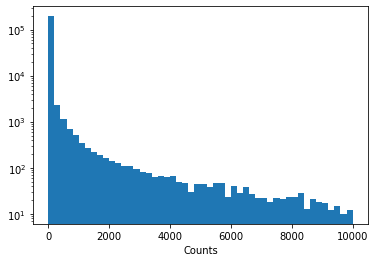

In [13]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [14]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count > min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [15]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 32456
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [19]:
token_to_id = {token: i for i, token in enumerate(tokens)}

In [20]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [21]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [22]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 996  176    1    1    1]
 [  18 3461  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [23]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [24]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [25]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [26]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[ 332, 4215,   88,    1,    1,    1,    1,    1,    1,    1],
        [ 153, 1110,    4,  340,   74,    1,    1,    1,    1,    1],
        [1268,  898,  176, 1269,   11, 5469, 1270, 3263,   64, 1763]],
       dtype=int32),
 'FullDescription': array([[7555, 1591, 1689,  558, 1919,   55, 3006,  217,  561, 1241],
        [ 153, 1110,    4,  340,   74, 2773,   15, 1822,   74,   82],
        [1523, 1795, 6584,   73, 1919, 2107,  732,  657, 1390, 1332]],
       dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]], dtype=float32),
 'Log1pSalary': array([10.959558 , 10.2036295,  9.690232 ], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [48]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [68]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 256)
        self.conv = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3)
        self.dence = nn.Linear(128, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv(h)        
        h = torch.max(h, dim=2)[0]
        h = F.relu(h)
        h = self.dence(h)        
        
        return h

In [69]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [70]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 256)
        self.conv = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3)
        self.dence = nn.Linear(128, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv(h)        
        h = torch.max(h, dim=2)[0]
        h = F.relu(h)
        h = self.dence(h)     
        
        return h

In [71]:
desc_encoder = DescriptionEncoder()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [90]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(n_tokens, out_size=64)
        self.desc_encoder = DescriptionEncoder(n_tokens, out_size = 64)
        
        self.categ_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dence = nn.Sequential(
            nn.Linear(64 * 3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categ_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.dence(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h[:, 0]

In [91]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [92]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [99]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference) - torch.exp(prediction)).mean()

In [94]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [95]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [96]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [97]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix, desc_ix, cat_features)
        # print(prediction[:3])
        # print(reference[:3])
        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


<ipython-input-95-d97ae8b50ffd>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


tensor([ 0.0028, -0.0015, -0.0053], grad_fn=<SliceBackward>)
tensor([11.3791,  9.9282,  9.7002])
tensor([0.2391, 0.2550, 0.2885], grad_fn=<SliceBackward>)
tensor([ 9.5480, 10.9613, 10.1465])
tensor([0.4460, 0.4314, 0.4748], grad_fn=<SliceBackward>)
tensor([ 9.8374, 10.2682, 10.1267])
tensor([0.7642, 0.7516, 0.7633], grad_fn=<SliceBackward>)
tensor([11.0822,  9.9523, 10.3326])
tensor([1.1289, 1.1004, 1.0811], grad_fn=<SliceBackward>)
tensor([10.1812, 10.2751, 10.4502])
tensor([1.6022, 1.5661, 1.6507], grad_fn=<SliceBackward>)
tensor([11.0821,  9.4623, 10.9376])
tensor([2.3871, 2.3259, 2.2208], grad_fn=<SliceBackward>)
tensor([10.4631, 10.7144, 10.0953])
tensor([2.9223, 3.1963, 3.3276], grad_fn=<SliceBackward>)
tensor([ 9.8522, 11.1704,  9.7700])
tensor([4.6074, 4.5025, 4.3674], grad_fn=<SliceBackward>)
tensor([10.1057, 10.8686, 10.2577])
tensor([5.9646, 5.5477, 5.6204], grad_fn=<SliceBackward>)
tensor([10.3890,  9.5751, 10.8968])
tensor([8.1207, 8.2741, 7.5587], grad_fn=<SliceBackward>)

tensor([10.6058, 10.7337, 10.1224], grad_fn=<SliceBackward>)
tensor([10.0433,  9.8985, 10.2057])
tensor([10.1110, 10.9745, 10.8181], grad_fn=<SliceBackward>)
tensor([ 9.6324,  9.9035, 10.6165])
tensor([11.0233, 10.8028, 10.5026], grad_fn=<SliceBackward>)
tensor([10.7790, 10.4043,  9.7982])
tensor([10.5253, 10.0215,  9.8718], grad_fn=<SliceBackward>)
tensor([10.8198,  9.9759,  9.6051])
tensor([ 8.9767, 10.2732, 10.1124], grad_fn=<SliceBackward>)
tensor([10.2922, 10.1849, 10.4913])
tensor([10.3236, 10.3190,  9.0477], grad_fn=<SliceBackward>)
tensor([ 9.7556, 10.7649, 10.6736])
tensor([ 9.8520, 10.6233, 10.5217], grad_fn=<SliceBackward>)
tensor([10.3090, 10.3090, 10.1849])
tensor([10.7267,  9.9468, 10.5589], grad_fn=<SliceBackward>)
tensor([10.7144, 10.1812, 10.0213])
tensor([ 9.7769, 10.6139, 10.3482], grad_fn=<SliceBackward>)
tensor([10.1267, 11.1563,  9.6675])
tensor([ 9.6131,  8.9437, 10.3870], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.5321,  9.7574])
tensor([10.9560, 10.4202,  9.5


	Loss:	0.40756
	MAE:	5833.14258



Training:


tensor([10.3211,  9.9198,  9.9150], grad_fn=<SliceBackward>)
tensor([11.0413, 10.4631,  8.6589])
tensor([ 9.9949,  9.8635, 10.8914], grad_fn=<SliceBackward>)
tensor([10.2682, 10.1096, 10.6573])
tensor([10.2515, 10.6019, 10.2924], grad_fn=<SliceBackward>)
tensor([10.3255, 10.4631, 10.2400])
tensor([ 9.5752, 10.2547, 10.2727], grad_fn=<SliceBackward>)
tensor([10.0213, 10.6628, 10.3272])
tensor([ 9.5763, 10.5792,  9.6560], grad_fn=<SliceBackward>)
tensor([10.3090, 10.7144,  9.9035])
tensor([ 9.9943, 10.3759, 10.6267], grad_fn=<SliceBackward>)
tensor([10.3090, 10.2400, 10.2036])
tensor([ 9.8726, 10.4980, 10.0085], grad_fn=<SliceBackward>)
tensor([ 9.8627, 10.3090, 10.3578])
tensor([10.1010, 10.2675, 10.9802], grad_fn=<SliceBackward>)
tensor([10.3890, 10.4631, 10.4341])
tensor([10.5579, 10.1556, 10.6584], grad_fn=<SliceBackward>)
tensor([ 9.9035,  9.7292, 10.1953])
tensor([11.0316, 10.8176, 10.7081], grad_fn=<SliceBackward>)
tensor([10.7144,  9.5469, 10.3090])
tensor([11.3243, 10.7149, 10.6

tensor([ 9.3579, 10.6687, 11.1897], grad_fn=<SliceBackward>)
tensor([11.2253, 11.1199, 10.5967])
tensor([10.9096, 10.3382, 10.2459], grad_fn=<SliceBackward>)
tensor([10.8686,  9.9523, 10.5805])
tensor([10.2470, 10.6920, 10.6613], grad_fn=<SliceBackward>)
tensor([ 9.6058, 10.1251, 10.1659])
tensor([10.5208, 10.2182, 10.2355], grad_fn=<SliceBackward>)
tensor([10.0213, 11.3794, 10.3519])
tensor([11.1190, 10.0810, 10.3556], grad_fn=<SliceBackward>)
tensor([11.2253, 10.3890, 10.3090])
tensor([10.1097, 10.6879, 10.4320], grad_fn=<SliceBackward>)
tensor([10.4913, 11.0429, 10.5321])
tensor([ 9.4243, 10.3214, 10.0576], grad_fn=<SliceBackward>)
tensor([ 9.7410, 10.4631, 10.3090])
tensor([ 9.5241, 10.4017,  9.8200], grad_fn=<SliceBackward>)
tensor([10.0450, 10.3418, 10.5045])
tensor([10.4510, 10.3289, 10.5581], grad_fn=<SliceBackward>)
tensor([10.3418, 10.3090, 10.1267])
tensor([11.3925, 10.2262, 10.7631], grad_fn=<SliceBackward>)
tensor([10.5967, 10.9151, 10.5051])
tensor([10.0714, 11.1427, 10.8


	Loss:	0.26770
	MAE:	4462.82774



Training:


tensor([10.3771, 10.3408, 10.5212], grad_fn=<SliceBackward>)
tensor([10.3188, 11.0822, 10.6736])
tensor([ 9.5824,  9.9790, 10.5358], grad_fn=<SliceBackward>)
tensor([ 9.7848,  9.6396, 10.6576])
tensor([10.0694, 10.4105, 11.1039], grad_fn=<SliceBackward>)
tensor([10.9151, 11.2253, 11.0822])
tensor([10.2971, 10.4705, 10.4387], grad_fn=<SliceBackward>)
tensor([ 9.8256,  9.9035, 10.2010])
tensor([10.2269, 10.1543, 11.1194], grad_fn=<SliceBackward>)
tensor([10.1849, 10.5321, 11.1563])
tensor([ 9.5341,  9.4898, 10.7649], grad_fn=<SliceBackward>)
tensor([ 9.4320,  9.9988, 10.6573])
tensor([10.6953, 10.3033, 10.3406], grad_fn=<SliceBackward>)
tensor([10.4487, 10.1267,  9.6396])
tensor([10.4005, 10.4998, 10.1573], grad_fn=<SliceBackward>)
tensor([10.0859, 10.5051,  9.7410])
tensor([10.6455, 10.8386, 10.7127], grad_fn=<SliceBackward>)
tensor([10.0859, 11.1563, 11.3445])
tensor([10.3265, 10.0997, 10.3995], grad_fn=<SliceBackward>)
tensor([10.5967, 10.7685,  9.4577])
tensor([ 9.7632, 10.1535, 10.2

tensor([10.4198, 10.0023, 10.9448], grad_fn=<SliceBackward>)
tensor([10.3331,  9.9035, 10.7144])
tensor([ 9.9769, 10.8013, 10.6299], grad_fn=<SliceBackward>)
tensor([10.7685, 10.5187, 10.9151])
tensor([ 9.5984, 10.5307,  9.5549], grad_fn=<SliceBackward>)
tensor([10.0541, 11.0822,  9.5469])
tensor([10.2171,  9.8555, 10.1478], grad_fn=<SliceBackward>)
tensor([10.5967,  9.9759, 10.2629])
tensor([10.0862,  9.4703,  9.9743], grad_fn=<SliceBackward>)
tensor([10.1849,  9.3830,  9.9035])
tensor([11.0169, 10.7887, 10.2626], grad_fn=<SliceBackward>)
tensor([10.4631, 10.6573, 10.3090])
tensor([10.6269, 10.7224, 10.8789], grad_fn=<SliceBackward>)
tensor([ 9.5003, 10.3339, 10.2577])
tensor([10.8127, 10.4266, 11.0572], grad_fn=<SliceBackward>)
tensor([10.5967, 10.1267, 11.1563])
tensor([ 9.9287, 10.0259, 10.1426], grad_fn=<SliceBackward>)
tensor([10.0859,  9.7556,  9.7982])
tensor([10.0540,  9.7080, 10.2724], grad_fn=<SliceBackward>)
tensor([ 9.9988,  9.9874, 10.2220])
tensor([10.1634,  9.7257, 10.3


	Loss:	0.21816
	MAE:	4719.90246



Training:


tensor([10.4384, 10.3502, 10.2551], grad_fn=<SliceBackward>)
tensor([10.2400, 10.7790, 10.5967])
tensor([10.2787, 10.2819, 10.3080], grad_fn=<SliceBackward>)
tensor([ 9.7982,  9.7406, 10.0433])
tensor([10.6958,  9.1477, 10.4702], grad_fn=<SliceBackward>)
tensor([10.8968,  9.4623, 10.5967])
tensor([10.1884, 10.5096,  9.5178], grad_fn=<SliceBackward>)
tensor([10.2343, 10.5713,  9.6396])
tensor([10.2165, 10.3323,  9.7866], grad_fn=<SliceBackward>)
tensor([10.5321, 10.3578, 10.0213])
tensor([10.3170, 11.0620, 10.2600], grad_fn=<SliceBackward>)
tensor([10.3104, 10.9151, 10.2682])
tensor([10.0106, 10.3232, 10.4331], grad_fn=<SliceBackward>)
tensor([12.0599, 10.1659, 10.4505])
tensor([10.4476,  9.1331, 10.3919], grad_fn=<SliceBackward>)
tensor([11.0429,  9.3959, 10.9151])
tensor([10.1805, 10.0731, 10.4582], grad_fn=<SliceBackward>)
tensor([10.0648,  9.9035, 10.1812])
tensor([10.1208, 10.5096,  9.8468], grad_fn=<SliceBackward>)
tensor([ 9.8390, 10.4631,  9.3830])
tensor([11.0969, 10.6784, 10.3

tensor([10.8848, 10.0198, 11.0373], grad_fn=<SliceBackward>)
tensor([11.0822,  9.5105, 10.9596])
tensor([ 9.5003,  9.7863, 10.0823], grad_fn=<SliceBackward>)
tensor([ 9.0372, 10.0433,  9.6959])
tensor([11.4313, 10.4084, 10.6909], grad_fn=<SliceBackward>)
tensor([11.0021,  9.9523, 10.7144])
tensor([10.3764, 10.5832, 10.4485], grad_fn=<SliceBackward>)
tensor([10.5321, 10.2577,  9.4728])
tensor([10.4796,  9.4614, 10.5186], grad_fn=<SliceBackward>)
tensor([10.4886,  9.8782,  9.9523])
tensor([10.6005,  9.5306, 10.8725], grad_fn=<SliceBackward>)
tensor([10.3090,  9.5469, 10.3890])
tensor([10.6423, 10.0609, 10.1770], grad_fn=<SliceBackward>)
tensor([10.5967, 10.6805, 10.0859])
tensor([10.2469, 10.7618, 10.7452], grad_fn=<SliceBackward>)
tensor([10.3090, 10.7790, 10.7685])
tensor([10.8638, 10.4413, 10.1431], grad_fn=<SliceBackward>)
tensor([10.6573, 10.2888, 10.0648])
tensor([10.8180, 10.6771, 10.8229], grad_fn=<SliceBackward>)
tensor([10.3465, 11.2898, 10.7685])
tensor([10.6805, 10.3463,  9.4


	Loss:	0.17382
	MAE:	3896.30195



Training:


tensor([10.7253, 10.2474,  9.9593], grad_fn=<SliceBackward>)
tensor([10.2036, 10.1849,  9.9035])
tensor([10.3167, 10.3221, 10.4390], grad_fn=<SliceBackward>)
tensor([10.0325,  9.5965,  9.7982])
tensor([ 9.8278, 10.9222, 10.7343], grad_fn=<SliceBackward>)
tensor([ 9.5273, 11.3504, 10.4341])
tensor([10.6421, 10.2610, 10.4353], grad_fn=<SliceBackward>)
tensor([10.2343, 11.2253, 10.3090])
tensor([10.4576,  9.8320, 10.4263], grad_fn=<SliceBackward>)
tensor([10.5967,  9.9282, 10.7144])
tensor([ 9.5381,  9.4263, 10.9904], grad_fn=<SliceBackward>)
tensor([ 9.5469,  9.7410, 11.0021])
tensor([10.4026,  9.4255, 10.5202], grad_fn=<SliceBackward>)
tensor([10.4631, 11.0517, 10.2220])
tensor([10.5185, 10.1502, 10.3368], grad_fn=<SliceBackward>)
tensor([10.4631,  9.3830,  9.7971])
tensor([10.3047, 10.6500,  9.8363], grad_fn=<SliceBackward>)
tensor([ 9.8627, 10.8198,  9.8522])
tensor([10.5971, 10.7070, 10.5206], grad_fn=<SliceBackward>)
tensor([10.2220, 11.3794,  9.8256])
tensor([ 9.4829, 10.1987, 10.1

tensor([10.1408, 10.1958, 10.3522], grad_fn=<SliceBackward>)
tensor([10.1065,  9.5751, 10.1849])
tensor([10.6604, 10.5544, 10.4502], grad_fn=<SliceBackward>)
tensor([10.2220, 10.0648, 11.0822])
tensor([10.1923, 10.4100, 10.5575], grad_fn=<SliceBackward>)
tensor([10.0213,  9.5105,  9.7498])
tensor([ 9.8145, 10.4788, 10.0663], grad_fn=<SliceBackward>)
tensor([10.3090,  8.6589, 10.4631])
tensor([10.6970, 10.2778,  9.1857], grad_fn=<SliceBackward>)
tensor([10.8198, 10.5967,  9.8114])
tensor([10.3289,  9.6896,  9.2748], grad_fn=<SliceBackward>)
tensor([10.1267,  9.9115,  9.5061])
tensor([10.1936, 10.3078,  9.9113], grad_fn=<SliceBackward>)
tensor([ 9.7084, 10.6573,  8.8174])
tensor([10.6170, 10.1411, 10.5889], grad_fn=<SliceBackward>)
tensor([10.8855, 10.9151, 10.6920])
tensor([10.3388, 10.4773,  9.0766], grad_fn=<SliceBackward>)
tensor([10.3578, 11.0429,  9.3927])
tensor([10.2832, 10.6500, 10.4515], grad_fn=<SliceBackward>)
tensor([ 9.8679, 10.7144, 10.0213])
tensor([10.0985, 10.3364, 10.1


	Loss:	0.16595
	MAE:	3712.54051



Training:


tensor([ 9.4981,  9.8269, 10.4149], grad_fn=<SliceBackward>)
tensor([ 9.2811, 10.0859, 10.4631])
tensor([10.0101,  9.5460, 10.2822], grad_fn=<SliceBackward>)
tensor([10.1659,  9.7700, 10.1267])
tensor([10.4011, 10.7976, 10.8612], grad_fn=<SliceBackward>)
tensor([10.2400, 11.2898, 10.2220])
tensor([10.5270, 10.4493, 10.3342], grad_fn=<SliceBackward>)
tensor([10.3090, 10.2220, 10.4631])
tensor([ 9.6237, 10.4678, 10.8509], grad_fn=<SliceBackward>)
tensor([10.2401, 10.3578, 10.3890])
tensor([10.7692, 10.5529, 10.4565], grad_fn=<SliceBackward>)
tensor([10.5321, 10.5321, 10.4631])
tensor([10.1898, 11.0670, 10.6859], grad_fn=<SliceBackward>)
tensor([10.2751, 10.5967, 10.5321])
tensor([10.7233, 10.6548, 10.0595], grad_fn=<SliceBackward>)
tensor([10.6091, 11.3329, 10.0411])
tensor([10.4688, 10.4508, 10.8088], grad_fn=<SliceBackward>)
tensor([10.1267, 10.8686, 11.0822])
tensor([10.5559, 10.0752, 10.2027], grad_fn=<SliceBackward>)
tensor([10.8198, 10.4779, 10.0859])
tensor([10.6766, 10.6970,  9.5

tensor([10.6117,  9.3908, 10.5176], grad_fn=<SliceBackward>)
tensor([11.2898,  9.9035, 10.0433])
tensor([10.2093, 10.4735, 10.4269], grad_fn=<SliceBackward>)
tensor([10.1465, 10.1267, 10.0524])
tensor([10.5592, 10.4410, 10.6092], grad_fn=<SliceBackward>)
tensor([10.5321, 10.3890,  9.8627])
tensor([10.6078, 10.2842, 10.3043], grad_fn=<SliceBackward>)
tensor([10.2577, 10.3090, 10.7144])
tensor([ 9.5980,  9.9781, 10.0883], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.6454,  9.7982])
tensor([ 9.9617, 10.1405,  9.8068], grad_fn=<SliceBackward>)
tensor([ 9.6804, 10.2343,  9.9523])
tensor([11.0176,  9.9695, 11.0093], grad_fn=<SliceBackward>)
tensor([10.4631, 10.0433, 10.9151])
tensor([10.1905, 10.3492, 10.5807], grad_fn=<SliceBackward>)
tensor([ 9.8390, 10.2400, 10.2220])
tensor([10.3534,  9.1563, 10.6054], grad_fn=<SliceBackward>)
tensor([10.5051,  9.4727, 10.2751])
tensor([10.5688, 10.6752, 10.4103], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.7144, 10.8182])
tensor([10.1335, 10.5066, 10.2


	Loss:	0.13909
	MAE:	3559.84712



Training:


tensor([ 9.8292,  9.7874, 10.3306], grad_fn=<SliceBackward>)
tensor([10.4223,  9.5061, 10.7010])
tensor([10.1156,  9.1546,  9.2730], grad_fn=<SliceBackward>)
tensor([10.5696,  9.7618,  9.3830])
tensor([ 9.7504, 10.5018,  9.5402], grad_fn=<SliceBackward>)
tensor([10.0648, 10.5321,  9.8051])
tensor([10.4769, 10.3117, 10.2866], grad_fn=<SliceBackward>)
tensor([10.7144,  9.9035, 10.1465])
tensor([ 9.6901, 10.1812,  9.8443], grad_fn=<SliceBackward>)
tensor([ 9.7002, 10.4913,  9.6487])
tensor([10.4486, 10.5493, 10.6961], grad_fn=<SliceBackward>)
tensor([10.5176, 10.0213, 10.1267])
tensor([ 9.4829, 10.0881, 10.3764], grad_fn=<SliceBackward>)
tensor([10.0450,  9.4697, 10.0213])
tensor([10.1928, 10.6227, 10.4379], grad_fn=<SliceBackward>)
tensor([ 9.6143, 10.6573, 10.6573])
tensor([ 9.6503, 10.5093, 10.2897], grad_fn=<SliceBackward>)
tensor([ 9.6159, 11.0822, 11.1131])
tensor([9.9017, 9.9953, 9.6673], grad_fn=<SliceBackward>)
tensor([9.6804, 9.8522, 9.3830])
tensor([ 9.7104, 10.5736,  9.8039], 

tensor([ 9.6905, 10.1469, 10.2374], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.2220, 10.1251])
tensor([10.3245, 10.2630,  9.9167], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.5321, 10.4223])
tensor([10.5900, 10.4811, 10.0646], grad_fn=<SliceBackward>)
tensor([11.2253, 10.3090, 10.2400])
tensor([ 9.7666, 10.0408,  9.4826], grad_fn=<SliceBackward>)
tensor([9.9759, 9.8256, 9.7410])
tensor([10.7352, 10.3275,  9.9642], grad_fn=<SliceBackward>)
tensor([10.7144, 10.1465, 10.6573])
tensor([10.3724, 10.3006,  9.8916], grad_fn=<SliceBackward>)
tensor([ 9.7692, 10.3578, 10.0898])
tensor([10.1691, 10.2148, 10.6877], grad_fn=<SliceBackward>)
tensor([10.1659, 10.0648, 10.6437])
tensor([10.1721, 10.1996, 10.1993], grad_fn=<SliceBackward>)
tensor([10.4631, 10.0859, 10.4913])
tensor([10.1852,  9.1113,  9.6875], grad_fn=<SliceBackward>)
tensor([10.2549, 10.6131,  9.7966])
tensor([10.4633, 10.1472,  9.7770], grad_fn=<SliceBackward>)
tensor([10.6573, 10.1849,  9.6159])
tensor([ 9.7366, 10.8988, 10.5131


	Loss:	0.13024
	MAE:	3436.35468



Training:


tensor([10.5554, 10.7932, 10.4335], grad_fn=<SliceBackward>)
tensor([10.6573, 10.6454, 10.6956])
tensor([10.4406, 10.2879, 10.9387], grad_fn=<SliceBackward>)
tensor([10.5967,  8.7389, 11.0021])
tensor([10.6467,  9.8471, 10.5632], grad_fn=<SliceBackward>)
tensor([11.1419,  9.4728, 10.5187])
tensor([10.5352, 11.1521, 10.5477], grad_fn=<SliceBackward>)
tensor([10.9151, 10.8686, 10.4631])
tensor([ 9.8528,  9.8745, 10.5261], grad_fn=<SliceBackward>)
tensor([10.1065,  9.3830, 10.8198])
tensor([10.8321, 10.4414,  9.7141], grad_fn=<SliceBackward>)
tensor([10.6185, 10.2400,  9.7982])
tensor([10.4354,  9.8556, 10.7497], grad_fn=<SliceBackward>)
tensor([10.6573, 10.0240, 10.7144])
tensor([ 9.9065, 10.5291,  9.8308], grad_fn=<SliceBackward>)
tensor([10.3890, 10.7685, 10.0433])
tensor([ 8.7867, 10.6165,  9.9000], grad_fn=<SliceBackward>)
tensor([ 9.2104, 10.5967, 10.5187])
tensor([ 9.8974, 10.0270, 10.1446], grad_fn=<SliceBackward>)
tensor([9.9580, 9.3830, 9.7410])
tensor([ 9.1870, 10.8392, 10.1866

tensor([10.7051,  9.9745, 10.2021], grad_fn=<SliceBackward>)
tensor([10.4193, 10.1992,  9.8522])
tensor([11.5756, 10.8646,  9.7242], grad_fn=<SliceBackward>)
tensor([11.6953, 10.1267,  9.7700])
tensor([10.0968, 10.2450, 10.5499], grad_fn=<SliceBackward>)
tensor([10.2220, 10.2256, 10.3090])
tensor([10.6937, 10.0274,  9.9900], grad_fn=<SliceBackward>)
tensor([10.6573, 10.2343,  9.8522])
tensor([9.6553, 9.1673, 9.5737], grad_fn=<SliceBackward>)
tensor([ 9.5469, 10.0213,  9.9759])
tensor([10.4031, 10.2131,  9.9433], grad_fn=<SliceBackward>)
tensor([10.5967, 10.4631, 10.0213])
tensor([10.3150, 10.1411, 10.2851], grad_fn=<SliceBackward>)
tensor([10.2220, 10.3090, 10.4268])
tensor([10.3218, 10.1034, 10.1213], grad_fn=<SliceBackward>)
tensor([10.9778,  9.9035,  9.8522])
tensor([10.4132,  9.7834, 10.2823], grad_fn=<SliceBackward>)
tensor([10.5967,  9.4320, 10.1628])
tensor([10.2056, 10.0226, 10.7685], grad_fn=<SliceBackward>)
tensor([10.5321, 10.5967, 10.5051])
tensor([10.2186,  9.6721, 10.6218


	Loss:	0.12815
	MAE:	3338.69482



Training:


tensor([ 9.4982,  9.9895, 11.0762], grad_fn=<SliceBackward>)
tensor([ 9.3742,  9.5751, 10.7144])
tensor([10.6816, 10.5392,  9.8912], grad_fn=<SliceBackward>)
tensor([11.4076, 11.0429,  9.8256])
tensor([10.0847, 10.0898, 10.2725], grad_fn=<SliceBackward>)
tensor([10.4043, 10.4913, 10.9151])
tensor([ 9.7569,  9.4004, 10.2828], grad_fn=<SliceBackward>)
tensor([ 9.9035,  9.7982, 10.2220])
tensor([10.6964, 10.8146, 10.1219], grad_fn=<SliceBackward>)
tensor([10.3090, 10.5321,  9.7112])
tensor([10.9892,  9.8193, 10.9361], grad_fn=<SliceBackward>)
tensor([11.4076,  9.5412, 10.7144])
tensor([10.3665, 10.9033, 10.9639], grad_fn=<SliceBackward>)
tensor([ 9.7410, 11.2645, 10.7378])
tensor([10.1925, 10.6570,  9.9220], grad_fn=<SliceBackward>)
tensor([10.4043, 10.1057,  9.9282])
tensor([10.0091, 10.5698,  9.9514], grad_fn=<SliceBackward>)
tensor([10.7382, 11.0429, 10.2220])
tensor([ 9.6169, 10.3032,  9.8445], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.9151, 10.0213])
tensor([10.5293,  9.4195,  9.9

tensor([ 9.7966,  9.3799, 11.0555], grad_fn=<SliceBackward>)
tensor([ 9.8724,  9.3830, 11.0021])
tensor([10.5192,  9.9974, 10.3604], grad_fn=<SliceBackward>)
tensor([10.5321, 10.4043, 10.0240])
tensor([10.5263,  9.8274, 10.2390], grad_fn=<SliceBackward>)
tensor([10.8198,  9.9035, 10.2751])
tensor([10.6423, 10.9332, 10.4854], grad_fn=<SliceBackward>)
tensor([10.4631, 10.6573, 10.3890])
tensor([10.7986, 11.3913, 10.6599], grad_fn=<SliceBackward>)
tensor([11.0021, 11.0021, 11.0413])
tensor([10.0991, 10.1103, 10.5945], grad_fn=<SliceBackward>)
tensor([10.2922, 10.4341, 10.5321])
tensor([ 9.8142,  9.7490, 10.4424], grad_fn=<SliceBackward>)
tensor([ 9.7469,  9.7410, 10.3090])
tensor([ 9.8791,  9.9108, 10.0050], grad_fn=<SliceBackward>)
tensor([ 9.7410, 10.2220,  9.9580])
tensor([10.4932, 10.6262, 10.2898], grad_fn=<SliceBackward>)
tensor([11.1844, 10.3090,  9.6159])
tensor([10.4680, 11.0138, 10.2980], grad_fn=<SliceBackward>)
tensor([10.1812, 10.7144, 10.0213])
tensor([10.0256, 10.3392, 10.3


	Loss:	0.12059
	MAE:	3246.00255



Training:


tensor([10.0075, 10.4305,  9.9832], grad_fn=<SliceBackward>)
tensor([ 9.5105, 10.4193,  8.9491])
tensor([ 9.8939,  9.4863, 10.8544], grad_fn=<SliceBackward>)
tensor([ 9.7031,  9.7410, 11.0021])
tensor([10.1534,  9.6177, 10.1064], grad_fn=<SliceBackward>)
tensor([10.1065,  9.6895, 10.1659])
tensor([11.2822, 10.6474,  9.6816], grad_fn=<SliceBackward>)
tensor([10.5321, 10.3890,  9.5202])
tensor([ 9.4740, 10.2408, 10.9589], grad_fn=<SliceBackward>)
tensor([ 9.9642, 10.2472, 11.0429])
tensor([10.7764, 10.3819, 10.1334], grad_fn=<SliceBackward>)
tensor([ 9.6159, 10.1812, 10.4644])
tensor([10.3183, 10.9024, 10.2761], grad_fn=<SliceBackward>)
tensor([10.6805, 10.7144,  9.8997])
tensor([10.2198, 10.2667,  9.8281], grad_fn=<SliceBackward>)
tensor([10.4631, 10.1849,  9.7700])
tensor([ 9.1330, 10.2320, 10.3473], grad_fn=<SliceBackward>)
tensor([ 9.6396, 10.4631, 10.9151])
tensor([10.4759,  9.4820, 10.7219], grad_fn=<SliceBackward>)
tensor([10.3090,  9.6078, 10.2220])
tensor([10.1362, 10.1165,  9.9

tensor([ 9.8075, 11.2250, 10.4607], grad_fn=<SliceBackward>)
tensor([ 9.7410,  8.8820, 10.4631])
tensor([ 9.8350, 10.4653,  9.8678], grad_fn=<SliceBackward>)
tensor([10.1251, 10.7685,  9.5751])
tensor([ 9.6647, 10.5057, 10.7800], grad_fn=<SliceBackward>)
tensor([ 9.8522, 11.2898, 11.0429])
tensor([10.2494,  9.9473, 10.5576], grad_fn=<SliceBackward>)
tensor([11.1844, 10.8968, 11.3794])
tensor([10.6735, 10.0070, 10.1807], grad_fn=<SliceBackward>)
tensor([10.4341, 10.1659, 10.2400])
tensor([10.3863, 10.7959, 10.4146], grad_fn=<SliceBackward>)
tensor([10.0433, 10.8743,  9.7112])
tensor([10.7653, 10.7701,  9.8679], grad_fn=<SliceBackward>)
tensor([10.4043, 10.2036,  9.6928])
tensor([ 9.7522, 10.1724, 10.0745], grad_fn=<SliceBackward>)
tensor([ 9.4320, 10.0213,  9.6159])
tensor([10.5302, 10.1048, 10.5926], grad_fn=<SliceBackward>)
tensor([10.9151, 10.4193, 10.3735])
tensor([10.3681, 10.0543,  9.5380], grad_fn=<SliceBackward>)
tensor([10.8686, 10.3890,  9.5105])
tensor([10.4572, 10.5551, 10.4


	Loss:	0.36487
	MAE:	5341.01565



Training:


tensor([9.8189, 9.8186, 9.9710], grad_fn=<SliceBackward>)
tensor([10.3890, 10.1267, 10.3890])
tensor([ 9.8338,  9.8485, 10.4262], grad_fn=<SliceBackward>)
tensor([11.0822, 10.0680, 10.8686])
tensor([ 9.5047, 10.7311, 10.3900], grad_fn=<SliceBackward>)
tensor([ 9.3561, 10.6920, 10.5967])
tensor([10.8308, 10.9996, 10.8472], grad_fn=<SliceBackward>)
tensor([10.6920, 10.4570, 10.4913])
tensor([11.3053, 11.4450, 10.7661], grad_fn=<SliceBackward>)
tensor([10.9596, 10.7685, 10.0213])
tensor([10.7393, 10.5994, 10.3063], grad_fn=<SliceBackward>)
tensor([10.5321, 10.8629, 10.7144])
tensor([10.2923,  9.9892,  9.6058], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.0471,  9.7410])
tensor([ 9.9582,  9.3448, 10.4993], grad_fn=<SliceBackward>)
tensor([10.2220, 10.3299, 10.9133])
tensor([10.6750,  9.0483, 10.0334], grad_fn=<SliceBackward>)
tensor([10.7685,  9.9115, 10.3418])
tensor([ 9.8851,  9.6384, 10.0623], grad_fn=<SliceBackward>)
tensor([10.1849,  9.3502, 10.2400])
tensor([10.6653, 10.0783, 10.6792

tensor([10.5173, 10.3725, 10.8415], grad_fn=<SliceBackward>)
tensor([10.5321, 10.3090, 11.1563])
tensor([10.0396, 10.5468, 10.7336], grad_fn=<SliceBackward>)
tensor([ 9.6551, 10.3890, 10.4913])
tensor([10.0764, 10.5388, 10.4738], grad_fn=<SliceBackward>)
tensor([ 9.3519, 10.2220, 10.2751])
tensor([10.2290,  9.9539, 10.6293], grad_fn=<SliceBackward>)
tensor([10.1465, 10.3156, 10.1659])
tensor([10.3937, 10.1823, 10.5013], grad_fn=<SliceBackward>)
tensor([10.8198, 10.5321, 10.2036])
tensor([10.6739,  9.7248,  9.5411], grad_fn=<SliceBackward>)
tensor([10.7408,  9.4917,  9.7982])
tensor([ 9.8361, 10.0344,  9.8451], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.0450,  9.9035])
tensor([ 9.9778, 10.3557, 10.2885], grad_fn=<SliceBackward>)
tensor([10.4043, 10.2220, 10.6335])
tensor([10.4466, 10.4210, 10.4123], grad_fn=<SliceBackward>)
tensor([ 9.9880, 11.0822, 10.3967])
tensor([10.0926,  9.8424,  9.3003], grad_fn=<SliceBackward>)
tensor([10.1849,  9.7002,  9.3830])
tensor([10.5352, 10.0325, 10.1


	Loss:	0.12188
	MAE:	3516.72516



Training:


tensor([10.8124, 10.1180, 10.6317], grad_fn=<SliceBackward>)
tensor([10.5321, 10.1659, 10.5967])
tensor([11.2428, 11.0787, 10.2974], grad_fn=<SliceBackward>)
tensor([11.0822, 11.1563, 10.1849])
tensor([10.5483, 10.4229,  9.8521], grad_fn=<SliceBackward>)
tensor([10.5051,  9.9759, 10.0648])
tensor([10.4031, 10.1598, 10.1830], grad_fn=<SliceBackward>)
tensor([10.5321, 10.1724, 10.1849])
tensor([10.1898,  9.8964, 10.5206], grad_fn=<SliceBackward>)
tensor([10.7144, 10.0450, 10.6573])
tensor([10.5467, 10.0157,  9.6855], grad_fn=<SliceBackward>)
tensor([10.7144,  9.7556,  9.4258])
tensor([10.1805,  9.7431, 10.0302], grad_fn=<SliceBackward>)
tensor([ 9.9988,  9.4336, 10.0450])
tensor([10.5450, 10.4536, 11.0370], grad_fn=<SliceBackward>)
tensor([10.4631, 10.0859, 10.4223])
tensor([10.8179, 10.9200, 10.0066], grad_fn=<SliceBackward>)
tensor([10.7144, 10.3890,  9.6159])
tensor([10.0652, 10.4601, 10.0039], grad_fn=<SliceBackward>)
tensor([10.2036, 10.8198,  9.9523])
tensor([10.3119, 10.1734, 10.6

tensor([10.6180,  9.6927,  9.8932], grad_fn=<SliceBackward>)
tensor([10.7996,  9.3830,  9.9035])
tensor([ 9.7652, 10.6504, 10.2880], grad_fn=<SliceBackward>)
tensor([10.2343, 10.5967, 10.1267])
tensor([10.0428, 10.5694, 10.5415], grad_fn=<SliceBackward>)
tensor([ 9.4165, 10.2220, 10.1267])
tensor([11.1075, 10.5262, 10.3200], grad_fn=<SliceBackward>)
tensor([10.8182, 10.1960, 10.9151])
tensor([ 9.9417, 10.8016, 10.8024], grad_fn=<SliceBackward>)
tensor([ 9.7136, 10.7685, 11.1563])
tensor([10.9967,  9.9878, 10.4143], grad_fn=<SliceBackward>)
tensor([10.8686, 10.0213, 10.3090])
tensor([10.4963,  9.6908,  9.8269], grad_fn=<SliceBackward>)
tensor([9.9580, 9.7982, 9.2104])
tensor([ 9.8168, 10.9309, 10.1537], grad_fn=<SliceBackward>)
tensor([10.1659, 11.0021, 10.7790])
tensor([10.0954, 10.8044, 10.2350], grad_fn=<SliceBackward>)
tensor([ 9.9523, 11.2253,  9.9523])
tensor([10.9404,  9.9638, 10.8822], grad_fn=<SliceBackward>)
tensor([10.9151,  9.5751, 10.3090])
tensor([10.6940,  9.8946, 10.4855


	Loss:	0.10265
	MAE:	3052.19662



Training:


tensor([10.1333, 10.3076, 10.6396], grad_fn=<SliceBackward>)
tensor([10.5321,  9.6068, 11.3386])
tensor([10.3300,  9.4200, 10.4741], grad_fn=<SliceBackward>)
tensor([10.5558,  9.6159, 10.3090])
tensor([10.4677,  9.9391,  9.9174], grad_fn=<SliceBackward>)
tensor([10.4516,  9.9035,  9.8522])
tensor([10.6071, 10.4757,  9.8844], grad_fn=<SliceBackward>)
tensor([10.1659, 10.7382,  9.9282])
tensor([10.4890, 10.4190, 10.5817], grad_fn=<SliceBackward>)
tensor([10.3090, 11.2253, 10.5454])
tensor([11.2369, 10.9767,  9.6697], grad_fn=<SliceBackward>)
tensor([10.7790, 10.7685,  9.9035])
tensor([10.0952, 10.8187, 10.5943], grad_fn=<SliceBackward>)
tensor([ 9.7574, 10.5321, 10.8198])
tensor([10.2060, 10.1900, 10.1153], grad_fn=<SliceBackward>)
tensor([10.5967, 10.0648, 10.7144])
tensor([10.6143, 10.6096, 10.0577], grad_fn=<SliceBackward>)
tensor([11.2490,  9.9523, 10.2036])
tensor([11.0390, 10.3743, 10.4644], grad_fn=<SliceBackward>)
tensor([10.8198, 11.0429, 10.0346])
tensor([10.1441, 10.4611, 10.9

tensor([10.3509,  9.9663, 10.6627], grad_fn=<SliceBackward>)
tensor([ 9.1851,  9.8627, 10.5454])
tensor([10.2629,  9.5761, 10.4766], grad_fn=<SliceBackward>)
tensor([10.0432,  9.4974, 10.3090])
tensor([ 9.7005, 11.1090,  9.7388], grad_fn=<SliceBackward>)
tensor([10.3327, 11.1199,  9.9523])
tensor([10.5315,  9.8685, 10.1765], grad_fn=<SliceBackward>)
tensor([10.4631, 10.1992, 10.8198])
tensor([10.3053, 10.7475, 10.5693], grad_fn=<SliceBackward>)
tensor([10.3735, 10.6214, 10.3735])
tensor([11.1693, 10.2739, 11.1081], grad_fn=<SliceBackward>)
tensor([11.4076, 10.3090, 11.0021])
tensor([10.4400, 10.4708, 10.2192], grad_fn=<SliceBackward>)
tensor([10.7685, 10.2036, 10.7144])
tensor([10.4562, 10.7417, 11.4501], grad_fn=<SliceBackward>)
tensor([10.4341, 10.7144, 11.1346])
tensor([10.4112, 10.0569, 10.2334], grad_fn=<SliceBackward>)
tensor([10.1465, 10.1267, 10.1659])
tensor([10.9171, 10.7145, 10.5517], grad_fn=<SliceBackward>)
tensor([10.5438, 11.2253, 11.0021])
tensor([10.5006, 10.1175, 10.9


	Loss:	0.15547
	MAE:	4290.79330



Training:


tensor([10.8182, 10.2055, 10.6037], grad_fn=<SliceBackward>)
tensor([10.4574,  9.7410, 10.4631])
tensor([ 9.7674, 11.0909, 10.7703], grad_fn=<SliceBackward>)
tensor([ 9.3519, 10.8198, 10.7144])
tensor([ 9.8139, 10.3874, 10.4718], grad_fn=<SliceBackward>)
tensor([ 9.7410, 10.5967, 10.1267])
tensor([10.5171,  9.8268,  9.6791], grad_fn=<SliceBackward>)
tensor([10.1251, 10.1065, 10.2220])
tensor([10.3151,  9.7270, 10.4732], grad_fn=<SliceBackward>)
tensor([10.4631,  9.7982, 10.6573])
tensor([ 9.8952, 10.0471, 10.7948], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.3578, 10.7996])
tensor([10.0805, 10.3930, 10.1035], grad_fn=<SliceBackward>)
tensor([10.1142, 10.3890, 10.2577])
tensor([10.6457, 10.1591, 10.4979], grad_fn=<SliceBackward>)
tensor([10.5967, 10.1876, 10.1659])
tensor([10.4455, 10.0038, 10.5385], grad_fn=<SliceBackward>)
tensor([10.1024, 10.2256, 10.3090])
tensor([ 9.9259, 10.1114,  9.6501], grad_fn=<SliceBackward>)
tensor([ 9.8782, 10.5967, 10.0648])
tensor([10.4625, 10.4201,  9.5

tensor([10.5254, 10.8554, 10.3361], grad_fn=<SliceBackward>)
tensor([ 9.9759, 10.7685, 10.4631])
tensor([11.3513, 10.5321, 10.7208], grad_fn=<SliceBackward>)
tensor([10.7790,  9.7112, 10.4193])
tensor([10.1156, 10.1831, 10.1938], grad_fn=<SliceBackward>)
tensor([ 9.9115, 10.3578, 10.3337])
tensor([10.6020, 10.1434, 10.2926], grad_fn=<SliceBackward>)
tensor([10.3890, 10.0025, 10.0450])
tensor([10.4962, 11.2945, 10.3155], grad_fn=<SliceBackward>)
tensor([10.4643, 11.1563, 10.8686])
tensor([10.5628, 10.4020, 10.6710], grad_fn=<SliceBackward>)
tensor([10.8923, 10.5321, 10.5842])
tensor([10.0570,  9.6821,  9.4975], grad_fn=<SliceBackward>)
tensor([9.9115, 9.6704, 9.4086])
tensor([ 9.7382, 10.5291, 11.0577], grad_fn=<SliceBackward>)
tensor([10.2577, 11.1331, 10.9151])
tensor([ 9.8142, 11.2940, 10.8476], grad_fn=<SliceBackward>)
tensor([10.0339, 11.2960, 10.4773])
tensor([10.1357, 10.0984, 10.4260], grad_fn=<SliceBackward>)
tensor([10.1065,  9.9580,  9.9759])
tensor([10.1843,  9.5395, 11.1690


	Loss:	0.10747
	MAE:	3250.73031



Training:


tensor([10.5332, 10.4318,  9.9716], grad_fn=<SliceBackward>)
tensor([10.0213, 10.4043,  9.7902])
tensor([10.8458, 10.8793, 10.4493], grad_fn=<SliceBackward>)
tensor([10.8198, 11.2253,  9.6159])
tensor([10.0148,  9.6494, 10.2756], grad_fn=<SliceBackward>)
tensor([10.0859,  9.4258,  9.7982])
tensor([ 9.6591, 10.4778, 10.5571], grad_fn=<SliceBackward>)
tensor([ 9.4078, 10.6573, 10.8198])
tensor([10.7526, 10.9243,  9.6210], grad_fn=<SliceBackward>)
tensor([10.5321, 11.0822, 10.3418])
tensor([ 9.5534, 10.2503,  9.9562], grad_fn=<SliceBackward>)
tensor([ 9.9580, 10.8686,  9.6159])
tensor([10.4710, 10.5296,  9.8876], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.6214,  9.5238])
tensor([10.0542, 10.1204, 10.2567], grad_fn=<SliceBackward>)
tensor([10.1267, 10.5187, 10.3418])
tensor([ 9.9779, 10.4354, 10.2948], grad_fn=<SliceBackward>)
tensor([10.1943, 10.5024, 10.4631])
tensor([10.9630, 10.5077, 10.4579], grad_fn=<SliceBackward>)
tensor([11.0822, 11.0021, 10.5321])
tensor([ 9.8579, 10.7871, 10.4

tensor([10.4714, 10.1687, 10.6756], grad_fn=<SliceBackward>)
tensor([10.5506,  9.7982, 10.7790])
tensor([10.3290,  9.6461, 10.4637], grad_fn=<SliceBackward>)
tensor([10.2682,  9.8522, 10.7685])
tensor([10.5343, 10.2420,  9.3009], grad_fn=<SliceBackward>)
tensor([11.0822,  9.9988,  9.7574])
tensor([10.1336,  9.7242, 11.3715], grad_fn=<SliceBackward>)
tensor([10.6736,  9.7112, 11.4721])
tensor([10.1637, 10.3835,  9.8926], grad_fn=<SliceBackward>)
tensor([9.8522, 9.2104, 9.6873])
tensor([ 9.3953, 10.5452, 10.8529], grad_fn=<SliceBackward>)
tensor([ 9.3927, 10.4631, 11.5129])
tensor([10.5499, 10.3914,  9.8400], grad_fn=<SliceBackward>)
tensor([10.2839, 10.3890,  9.5809])
tensor([10.4244, 10.1715,  9.4537], grad_fn=<SliceBackward>)
tensor([10.4631, 10.3090,  9.5452])
tensor([10.5894,  9.9791,  9.6669], grad_fn=<SliceBackward>)
tensor([10.9151, 10.1659,  9.7410])
tensor([ 9.9718,  9.9192, 10.0234], grad_fn=<SliceBackward>)
tensor([9.5172, 9.6959, 9.9035])
tensor([10.8009, 10.5010, 10.4607], 


	Loss:	0.10023
	MAE:	2983.66552



Training:


tensor([10.2915, 10.3181,  9.9485], grad_fn=<SliceBackward>)
tensor([10.3187,  9.8522,  9.6680])
tensor([10.1886,  9.6915,  9.8947], grad_fn=<SliceBackward>)
tensor([10.1849, 10.0433, 10.5999])
tensor([10.4922, 10.7648, 10.1228], grad_fn=<SliceBackward>)
tensor([10.1065, 10.1267,  9.5289])
tensor([10.4944, 10.5320, 10.4881], grad_fn=<SliceBackward>)
tensor([ 9.9759, 10.3890,  9.9523])
tensor([10.4724, 10.7739, 10.5263], grad_fn=<SliceBackward>)
tensor([10.5321, 10.4341, 10.5321])
tensor([ 9.9953, 10.8529, 10.0091], grad_fn=<SliceBackward>)
tensor([10.2682, 11.0413,  9.8782])
tensor([ 9.2566,  9.9743, 10.3479], grad_fn=<SliceBackward>)
tensor([ 9.3830, 10.2400, 10.3090])
tensor([10.1894, 10.0819, 10.7976], grad_fn=<SliceBackward>)
tensor([11.0822,  9.9759, 11.0258])
tensor([10.7159, 10.5942, 10.1855], grad_fn=<SliceBackward>)
tensor([10.1267, 10.3090, 10.4913])
tensor([11.2933, 10.4161, 10.9271], grad_fn=<SliceBackward>)
tensor([10.5713, 10.3418, 10.4631])
tensor([10.0975, 10.7884, 10.0

tensor([10.5693, 10.0348, 10.0750], grad_fn=<SliceBackward>)
tensor([ 9.9523,  9.5105, 10.3090])
tensor([ 9.8124,  9.9826, 10.2700], grad_fn=<SliceBackward>)
tensor([ 9.6159,  9.9115, 10.0213])
tensor([10.4656, 11.0181,  9.7371], grad_fn=<SliceBackward>)
tensor([10.6573, 11.2580,  9.8627])
tensor([10.2636, 10.3249,  9.3865], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.5967,  9.7410])
tensor([ 9.9507, 10.5906, 10.4811], grad_fn=<SliceBackward>)
tensor([10.3482, 10.0433, 11.0021])
tensor([10.3208, 10.4602, 10.4945], grad_fn=<SliceBackward>)
tensor([10.5967, 10.5584, 10.5187])
tensor([10.0763,  9.6827, 10.9878], grad_fn=<SliceBackward>)
tensor([10.3090,  9.6159, 10.9151])
tensor([10.3249, 10.7102, 10.7429], grad_fn=<SliceBackward>)
tensor([10.7790, 11.2797, 10.3890])
tensor([ 9.8261, 10.0042, 10.0754], grad_fn=<SliceBackward>)
tensor([10.0859,  9.5981, 10.0859])
tensor([ 9.7174,  9.8966, 10.3255], grad_fn=<SliceBackward>)
tensor([ 9.9580, 10.0648, 10.2577])
tensor([10.0044, 10.7301,  9.8


	Loss:	0.09622
	MAE:	2986.30184



Training:


tensor([10.3671, 10.6188, 10.7465], grad_fn=<SliceBackward>)
tensor([10.1366,  9.9988, 10.6573])
tensor([ 9.8486,  9.5496, 10.2037], grad_fn=<SliceBackward>)
tensor([ 9.6045,  9.3807, 10.3735])
tensor([10.2775, 10.4868,  9.9992], grad_fn=<SliceBackward>)
tensor([10.3327, 10.7144, 10.1445])
tensor([10.6943, 10.0793, 10.2199], grad_fn=<SliceBackward>)
tensor([11.2898,  9.5469, 10.3090])
tensor([10.5524, 10.0166, 10.0315], grad_fn=<SliceBackward>)
tensor([10.8590,  9.9523, 10.3090])
tensor([10.3598, 10.3471, 10.2051], grad_fn=<SliceBackward>)
tensor([10.4913, 10.4631,  9.9035])
tensor([11.1656, 10.3428, 10.2940], grad_fn=<SliceBackward>)
tensor([10.9596, 10.0859, 10.4843])
tensor([10.4932, 10.8368, 10.7831], grad_fn=<SliceBackward>)
tensor([10.5321, 11.4721, 10.7144])
tensor([10.3969, 10.8645, 10.6744], grad_fn=<SliceBackward>)
tensor([10.5176, 10.8182, 10.4341])
tensor([10.6189, 10.5430, 10.3439], grad_fn=<SliceBackward>)
tensor([10.5967, 11.0021, 10.3890])
tensor([10.3488, 10.4618,  9.6

tensor([10.4614, 10.7437, 10.3480], grad_fn=<SliceBackward>)
tensor([10.7144, 10.7685, 10.2577])
tensor([10.1648, 10.2361, 10.9616], grad_fn=<SliceBackward>)
tensor([10.0648, 10.5650, 11.0822])
tensor([10.2919,  9.3157,  9.6372], grad_fn=<SliceBackward>)
tensor([10.1267,  9.1696,  9.3830])
tensor([10.0435,  9.7777, 10.5140], grad_fn=<SliceBackward>)
tensor([10.2220,  9.8627, 10.5321])
tensor([10.3455, 10.6625,  9.5737], grad_fn=<SliceBackward>)
tensor([10.2400, 10.5967,  9.5991])
tensor([10.7969, 11.4813, 10.8008], grad_fn=<SliceBackward>)
tensor([10.2751, 10.7685, 10.4239])
tensor([10.2969, 10.4290, 10.2015], grad_fn=<SliceBackward>)
tensor([ 9.9805, 10.2036,  9.0265])
tensor([10.3500, 10.5971, 10.1013], grad_fn=<SliceBackward>)
tensor([ 9.7700, 10.5967, 10.4913])
tensor([9.9482, 9.9531, 9.7875], grad_fn=<SliceBackward>)
tensor([10.1659, 10.1628,  9.2592])
tensor([10.0244, 10.0828, 10.7004], grad_fn=<SliceBackward>)
tensor([10.3353, 10.2220, 10.9151])
tensor([10.3352, 10.8421, 10.3059


	Loss:	0.14404
	MAE:	3558.81204



Training:


tensor([10.0086, 10.1732, 10.6807], grad_fn=<SliceBackward>)
tensor([10.3574, 10.4631, 10.9151])
tensor([ 9.7145, 10.7071, 10.0214], grad_fn=<SliceBackward>)
tensor([ 9.6804, 10.3890, 10.4400])
tensor([ 9.4649, 10.4735,  9.9594], grad_fn=<SliceBackward>)
tensor([ 9.9350, 10.3890,  9.6671])
tensor([10.0050, 10.6983, 10.7701], grad_fn=<SliceBackward>)
tensor([ 9.6396, 10.5967, 10.0213])
tensor([ 9.7470, 10.5965, 10.5819], grad_fn=<SliceBackward>)
tensor([ 9.3830, 10.8198, 10.3890])
tensor([ 9.5670,  9.6078, 10.1311], grad_fn=<SliceBackward>)
tensor([ 9.3830,  9.9035, 10.2682])
tensor([10.3412, 10.3172,  9.8630], grad_fn=<SliceBackward>)
tensor([10.4631, 10.3418, 10.4341])
tensor([10.2606, 10.5180, 10.3647], grad_fn=<SliceBackward>)
tensor([10.0213, 10.7893, 10.0411])
tensor([10.9197, 10.1932, 10.7348], grad_fn=<SliceBackward>)
tensor([10.8198, 10.2751, 10.8198])
tensor([10.7763, 10.7941, 10.7916], grad_fn=<SliceBackward>)
tensor([10.4631, 10.2220, 10.3090])
tensor([10.8730, 10.2039, 10.8

tensor([10.4860, 10.7479,  9.9832], grad_fn=<SliceBackward>)
tensor([10.4773, 10.7685,  9.7982])
tensor([10.7905, 10.6551, 10.4663], grad_fn=<SliceBackward>)
tensor([10.5967, 11.2898, 10.4631])
tensor([ 9.3850, 10.2165, 10.3414], grad_fn=<SliceBackward>)
tensor([ 9.4974, 10.0859, 10.3890])
tensor([10.5947, 10.0136,  9.6984], grad_fn=<SliceBackward>)
tensor([11.1261,  9.9523, 10.2577])
tensor([10.2490,  9.8053, 11.0717], grad_fn=<SliceBackward>)
tensor([10.5967, 10.0433, 11.2253])
tensor([10.9007, 10.2581, 10.1594], grad_fn=<SliceBackward>)
tensor([10.6573,  9.5820,  9.7410])
tensor([11.4866, 11.1537, 10.8995], grad_fn=<SliceBackward>)
tensor([10.7144, 10.7025, 10.4913])
tensor([ 9.6525, 10.2095, 10.0073], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.4631, 10.5321])
tensor([ 9.7871, 10.5666,  9.7898], grad_fn=<SliceBackward>)
tensor([10.0433, 10.7144, 10.3890])
tensor([ 9.6692, 10.2237,  9.8505], grad_fn=<SliceBackward>)
tensor([ 9.7700, 10.7144, 10.1267])
tensor([10.7996, 10.2785, 10.4


	Loss:	0.10063
	MAE:	2988.79545



Training:


tensor([10.5438,  9.5340, 10.3814], grad_fn=<SliceBackward>)
tensor([10.7790,  9.7410,  9.9282])
tensor([10.4762, 10.7193, 10.6699], grad_fn=<SliceBackward>)
tensor([10.5967, 10.0213, 10.1267])
tensor([10.0685, 10.3032, 10.5743], grad_fn=<SliceBackward>)
tensor([10.1267, 10.3890, 10.2400])
tensor([10.5290, 10.4131, 10.7192], grad_fn=<SliceBackward>)
tensor([10.5967, 10.1267, 10.3735])
tensor([10.8384,  9.9253, 10.5315], grad_fn=<SliceBackward>)
tensor([11.4876, 11.5029, 10.8198])
tensor([11.0328, 10.2210, 11.2209], grad_fn=<SliceBackward>)
tensor([10.7382, 10.8182, 11.5129])
tensor([10.1161, 10.2683,  9.8400], grad_fn=<SliceBackward>)
tensor([10.1659,  9.7002,  9.5751])
tensor([10.1238, 10.6971, 10.3172], grad_fn=<SliceBackward>)
tensor([ 9.8825, 10.5321, 10.2036])
tensor([ 9.9247, 11.0470, 10.8404], grad_fn=<SliceBackward>)
tensor([ 9.9035, 11.5129, 10.5841])
tensor([10.3507, 10.2992,  9.9784], grad_fn=<SliceBackward>)
tensor([10.7685, 10.1267, 10.1267])
tensor([10.6122, 10.6924, 10.4

tensor([10.0682, 10.3054, 10.7625], grad_fn=<SliceBackward>)
tensor([11.1050, 10.3890, 10.8968])
tensor([11.0177,  9.0252, 10.6508], grad_fn=<SliceBackward>)
tensor([11.2898,  9.3830, 10.7144])
tensor([10.4933, 10.7502,  9.9871], grad_fn=<SliceBackward>)
tensor([10.5558, 10.6573, 10.1465])
tensor([10.0970, 10.3632,  9.5684], grad_fn=<SliceBackward>)
tensor([10.1659, 10.3090,  9.6238])
tensor([10.0985,  9.9383, 10.3569], grad_fn=<SliceBackward>)
tensor([ 9.5061,  9.9759, 10.5967])
tensor([ 9.7956, 10.3771, 10.2262], grad_fn=<SliceBackward>)
tensor([10.4631, 10.7144, 10.4913])
tensor([11.0420,  9.8325, 10.1162], grad_fn=<SliceBackward>)
tensor([11.2071,  9.9523,  9.7410])
tensor([10.3489, 10.5546, 10.5627], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.3673, 10.0433])
tensor([10.3765, 10.4656,  9.8775], grad_fn=<SliceBackward>)
tensor([10.4631, 10.5051,  9.8782])
tensor([10.3258, 10.8102,  9.9963], grad_fn=<SliceBackward>)
tensor([10.5558, 10.4773, 10.2682])
tensor([10.3201, 10.3493,  9.9


	Loss:	0.09370
	MAE:	2885.36787



Training:


tensor([10.5308, 10.1714, 10.0699], grad_fn=<SliceBackward>)
tensor([11.0791, 10.5713,  9.7700])
tensor([11.2732, 10.1967, 10.2693], grad_fn=<SliceBackward>)
tensor([11.3266, 10.5121, 10.2577])
tensor([10.4595, 10.3592, 10.1947], grad_fn=<SliceBackward>)
tensor([10.7144,  9.4336, 10.5967])
tensor([10.9710, 10.3049, 10.0743], grad_fn=<SliceBackward>)
tensor([10.7685, 10.2220, 10.1465])
tensor([10.0154, 10.1278, 10.4536], grad_fn=<SliceBackward>)
tensor([10.1065,  9.9759, 10.3890])
tensor([10.3181, 10.7507, 10.1597], grad_fn=<SliceBackward>)
tensor([10.6573, 11.0021, 10.8686])
tensor([10.7470,  9.7897,  9.7897], grad_fn=<SliceBackward>)
tensor([10.8781, 10.3090, 10.0433])
tensor([ 9.4792, 10.6866, 10.4841], grad_fn=<SliceBackward>)
tensor([ 9.4062, 10.5713, 10.3890])
tensor([10.2408, 10.2975, 10.7744], grad_fn=<SliceBackward>)
tensor([11.5129, 10.3255, 10.5967])
tensor([10.4752, 10.6796, 10.6098], grad_fn=<SliceBackward>)
tensor([10.1267, 10.8198, 10.3090])
tensor([10.1790,  9.6593, 10.3

tensor([10.3954, 10.0720,  9.9786], grad_fn=<SliceBackward>)
tensor([10.4631,  9.7700,  9.7982])
tensor([10.8505, 10.8078, 10.0911], grad_fn=<SliceBackward>)
tensor([11.0429, 11.0566, 10.2922])
tensor([10.5482, 11.1824, 10.3692], grad_fn=<SliceBackward>)
tensor([10.4773, 11.2253, 10.0025])
tensor([10.1448, 10.5826,  9.8324], grad_fn=<SliceBackward>)
tensor([ 9.8627, 10.9151,  9.8575])
tensor([10.5359, 10.5649, 10.6888], grad_fn=<SliceBackward>)
tensor([10.6573, 10.9596, 11.0822])
tensor([9.8138, 9.5212, 9.4107], grad_fn=<SliceBackward>)
tensor([10.0433,  9.9523,  9.2104])
tensor([10.9030, 10.2067, 10.8425], grad_fn=<SliceBackward>)
tensor([10.6920,  9.8782, 10.7685])
tensor([ 9.7647, 10.8780, 10.3303], grad_fn=<SliceBackward>)
tensor([ 9.5203, 10.8198, 10.4341])
tensor([11.1774, 10.0999, 10.4926], grad_fn=<SliceBackward>)
tensor([10.3090, 10.0240, 10.1992])
tensor([10.6199, 10.0911, 10.0067], grad_fn=<SliceBackward>)
tensor([10.3890,  9.7982,  9.9392])
tensor([ 9.6219, 10.0515, 10.3975


	Loss:	0.24363
	MAE:	4603.91360



Training:


tensor([10.1348,  9.9817, 10.2301], grad_fn=<SliceBackward>)
tensor([10.5967, 10.2036, 10.8198])
tensor([10.1662,  9.6676, 10.6824], grad_fn=<SliceBackward>)
tensor([11.0021,  9.6159, 10.7685])
tensor([ 9.8779,  9.9815, 10.8452], grad_fn=<SliceBackward>)
tensor([ 9.9282,  9.8114, 10.5321])
tensor([11.1996, 11.3303, 10.9436], grad_fn=<SliceBackward>)
tensor([11.0021, 10.5321, 11.2898])
tensor([10.3003, 10.6073,  9.9143], grad_fn=<SliceBackward>)
tensor([ 9.0265, 10.3090,  9.3830])
tensor([ 9.9228,  9.7040, 10.0446], grad_fn=<SliceBackward>)
tensor([10.3735, 10.0068, 10.1267])
tensor([ 9.1402,  9.5600, 10.1099], grad_fn=<SliceBackward>)
tensor([ 9.8627,  9.8256, 10.6214])
tensor([10.5230, 10.0165,  9.0853], grad_fn=<SliceBackward>)
tensor([10.7144, 10.0213,  9.6396])
tensor([10.6800, 10.6497, 10.3839], grad_fn=<SliceBackward>)
tensor([10.4631, 10.1267, 10.5967])
tensor([10.7616, 10.8121, 10.2533], grad_fn=<SliceBackward>)
tensor([ 9.8256, 10.1267, 10.0648])
tensor([10.3887, 10.5863, 10.5

tensor([10.6418, 10.0817, 10.6853], grad_fn=<SliceBackward>)
tensor([10.5374, 10.1267, 10.9613])
tensor([10.7100, 10.6556, 10.1924], grad_fn=<SliceBackward>)
tensor([10.7144, 10.8198, 10.3735])
tensor([ 9.7745, 10.0821, 10.4914], grad_fn=<SliceBackward>)
tensor([ 9.7112, 10.2682, 10.1659])
tensor([10.3320,  9.9588, 10.8826], grad_fn=<SliceBackward>)
tensor([10.2400,  9.8522, 10.6214])
tensor([11.2302,  9.6880,  9.8409], grad_fn=<SliceBackward>)
tensor([10.9596,  9.2802,  9.4804])
tensor([10.4752, 10.1371, 10.0483], grad_fn=<SliceBackward>)
tensor([10.3735, 10.4341, 10.0213])
tensor([10.2243,  9.5719,  9.9687], grad_fn=<SliceBackward>)
tensor([10.3090, 10.0648, 10.2220])
tensor([10.0231,  9.7639,  9.5647], grad_fn=<SliceBackward>)
tensor([9.9988, 9.6804, 9.9759])
tensor([10.6479, 10.4077, 11.0288], grad_fn=<SliceBackward>)
tensor([10.7472, 10.3090, 11.3251])
tensor([ 9.7894, 10.2736,  9.9777], grad_fn=<SliceBackward>)
tensor([9.3725, 9.9665, 9.9580])
tensor([10.4515, 10.2114, 10.0555], 


	Loss:	0.10261
	MAE:	3214.04834



Training:


tensor([10.6502, 11.0369,  9.7270], grad_fn=<SliceBackward>)
tensor([10.7685, 10.9151,  9.6804])
tensor([10.6083,  9.6608, 10.9577], grad_fn=<SliceBackward>)
tensor([10.5967,  9.6396, 11.3386])
tensor([10.4715,  9.4079, 10.0259], grad_fn=<SliceBackward>)
tensor([10.5321,  9.8114, 10.2888])
tensor([10.2572, 10.3130, 10.1562], grad_fn=<SliceBackward>)
tensor([10.2751, 10.3578, 10.4631])
tensor([10.4890, 11.0504,  9.8563], grad_fn=<SliceBackward>)
tensor([10.6335, 11.4076,  9.9523])
tensor([ 9.8291, 10.1861, 10.1482], grad_fn=<SliceBackward>)
tensor([ 9.9035,  9.8782, 11.1563])
tensor([10.3138, 10.7620, 10.0625], grad_fn=<SliceBackward>)
tensor([10.7144, 10.3578,  9.9282])
tensor([10.5535,  9.9520,  9.8787], grad_fn=<SliceBackward>)
tensor([10.3890,  9.9035,  9.6159])
tensor([11.5689,  9.7440, 10.3577], grad_fn=<SliceBackward>)
tensor([10.9613,  9.6159,  9.8264])
tensor([10.1194, 10.3509,  9.9087], grad_fn=<SliceBackward>)
tensor([10.3890, 10.8198, 10.1992])
tensor([11.1888,  9.7890, 10.4

tensor([ 9.8414, 10.6302,  9.9808], grad_fn=<SliceBackward>)
tensor([ 9.6396, 10.4631,  9.6487])
tensor([11.0554, 10.2230, 10.4726], grad_fn=<SliceBackward>)
tensor([10.7685, 10.0213, 10.0213])
tensor([9.3821, 9.8093, 9.8662], grad_fn=<SliceBackward>)
tensor([ 9.6396, 10.1267, 10.0648])
tensor([ 9.5367, 10.3614,  9.6588], grad_fn=<SliceBackward>)
tensor([ 9.6396, 10.5967,  9.7700])
tensor([10.4520, 10.7230, 10.0731], grad_fn=<SliceBackward>)
tensor([10.9151, 10.4631, 10.0859])
tensor([11.0240, 10.7894, 10.1537], grad_fn=<SliceBackward>)
tensor([10.4631, 10.2577, 10.4631])
tensor([10.5067, 10.6147, 10.8113], grad_fn=<SliceBackward>)
tensor([10.3090, 10.4631, 10.3735])
tensor([ 9.6846, 10.1276, 10.4474], grad_fn=<SliceBackward>)
tensor([10.1465, 10.5713, 10.4631])
tensor([10.5729, 10.1932,  9.1817], grad_fn=<SliceBackward>)
tensor([10.4631, 11.3504,  9.4336])
tensor([9.9735, 9.2690, 9.4968], grad_fn=<SliceBackward>)
tensor([10.5967,  9.3493,  9.6551])
tensor([10.6289,  9.5609, 10.3522], 


	Loss:	0.14293
	MAE:	3485.49064



Training:


tensor([ 9.5914,  9.3014, 10.0279], grad_fn=<SliceBackward>)
tensor([10.2751,  9.6159, 10.0433])
tensor([10.8271,  9.6608, 10.4678], grad_fn=<SliceBackward>)
tensor([10.5967,  9.7112, 10.4631])
tensor([10.2093, 10.4638, 11.2005], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.4631, 10.9151])
tensor([10.6862, 10.5177,  9.8173], grad_fn=<SliceBackward>)
tensor([10.0213, 10.3890,  9.8120])
tensor([10.0284, 10.3520, 10.0135], grad_fn=<SliceBackward>)
tensor([ 9.8256, 11.0021, 10.3890])
tensor([10.3443, 10.2295, 10.5217], grad_fn=<SliceBackward>)
tensor([10.6573, 10.4631, 10.5967])
tensor([10.7973, 10.6022, 10.5364], grad_fn=<SliceBackward>)
tensor([11.1563, 10.5321, 10.5584])
tensor([10.7298, 10.2898, 10.9350], grad_fn=<SliceBackward>)
tensor([11.1844,  9.7700, 10.5967])
tensor([10.2432, 10.4079, 11.3259], grad_fn=<SliceBackward>)
tensor([10.1267,  9.8256, 10.5967])
tensor([ 9.7683,  9.8210, 10.5114], grad_fn=<SliceBackward>)
tensor([10.0433, 10.0859, 11.2490])
tensor([10.3145, 10.4695, 10.7

tensor([10.4439, 10.5746, 10.3536], grad_fn=<SliceBackward>)
tensor([10.4043, 10.3735, 10.2682])
tensor([ 9.4751, 11.5461, 10.9282], grad_fn=<SliceBackward>)
tensor([ 8.6589, 11.8086, 11.0822])
tensor([ 9.7949, 10.9225, 10.5201], grad_fn=<SliceBackward>)
tensor([ 9.7700, 11.2253, 10.4631])
tensor([ 9.2272, 10.7718, 10.1277], grad_fn=<SliceBackward>)
tensor([ 9.4873, 11.0021, 10.5967])
tensor([10.5051, 10.3685,  9.8699], grad_fn=<SliceBackward>)
tensor([ 9.9523, 11.0021, 10.3090])
tensor([10.4429, 10.8075, 10.9483], grad_fn=<SliceBackward>)
tensor([10.5713, 10.6335, 10.6214])
tensor([10.2461,  9.8507, 10.7756], grad_fn=<SliceBackward>)
tensor([10.2400, 10.2659, 10.7144])
tensor([10.4042,  9.7363,  9.9934], grad_fn=<SliceBackward>)
tensor([ 9.9759,  9.4771, 10.2220])
tensor([10.6961, 10.4290,  9.9449], grad_fn=<SliceBackward>)
tensor([10.4316, 10.6573,  9.9035])
tensor([9.7977, 9.9443, 9.6341], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.3735,  9.9988])
tensor([10.6266, 10.5081, 11.1757


	Loss:	0.09072
	MAE:	2901.08510



Training:


tensor([10.2090, 10.5837, 10.2992], grad_fn=<SliceBackward>)
tensor([10.2220, 10.3418, 10.1267])
tensor([10.9376, 10.9456, 11.4709], grad_fn=<SliceBackward>)
tensor([10.6631, 10.7144, 11.2253])
tensor([10.8338,  9.9972, 10.4717], grad_fn=<SliceBackward>)
tensor([11.2898, 10.2751, 10.9151])
tensor([ 9.7565,  9.9600, 10.5808], grad_fn=<SliceBackward>)
tensor([ 9.7383, 10.1267, 10.7144])
tensor([10.3023, 10.2952,  9.0043], grad_fn=<SliceBackward>)
tensor([11.2898, 10.3090,  9.6159])
tensor([10.1806, 10.7550, 10.2860], grad_fn=<SliceBackward>)
tensor([10.5045, 10.9596, 10.3482])
tensor([11.1523, 10.6009, 10.4546], grad_fn=<SliceBackward>)
tensor([11.0258, 10.3735, 10.5713])
tensor([10.9165, 10.4281, 10.9811], grad_fn=<SliceBackward>)
tensor([11.0021, 10.3090, 10.3090])
tensor([11.1086, 10.1755, 10.5566], grad_fn=<SliceBackward>)
tensor([11.2253,  9.0479,  9.6159])
tensor([9.9223, 9.9424, 9.9350], grad_fn=<SliceBackward>)
tensor([10.3735, 10.1849,  9.6159])
tensor([ 9.8323, 10.1045, 10.3936

tensor([10.4851,  9.6772, 10.8754], grad_fn=<SliceBackward>)
tensor([10.9151,  9.8627, 10.9596])
tensor([10.3912, 10.0427, 10.5550], grad_fn=<SliceBackward>)
tensor([10.5713,  9.8627, 10.7764])
tensor([10.8433,  9.9201,  9.8529], grad_fn=<SliceBackward>)
tensor([10.7685,  9.5383,  9.5061])
tensor([10.1726, 10.6220, 10.6018], grad_fn=<SliceBackward>)
tensor([10.2577, 10.6454, 10.3890])
tensor([9.6033, 9.9866, 9.5936], grad_fn=<SliceBackward>)
tensor([ 9.8627,  9.5646, 10.0433])
tensor([10.3844,  9.4416,  9.7628], grad_fn=<SliceBackward>)
tensor([10.5584,  9.5469,  9.9282])
tensor([10.0515, 10.2619, 10.0146], grad_fn=<SliceBackward>)
tensor([ 9.9680, 10.4574,  9.7982])
tensor([11.5838, 11.2885, 10.2582], grad_fn=<SliceBackward>)
tensor([10.7144, 10.3890,  9.9191])
tensor([10.3992, 10.2187, 10.7697], grad_fn=<SliceBackward>)
tensor([10.1267,  9.2104, 10.6029])
tensor([10.7964, 10.5961, 10.5248], grad_fn=<SliceBackward>)
tensor([11.0021, 10.3090, 10.7790])
tensor([9.7577, 9.7969, 9.3305], 


	Loss:	0.10242
	MAE:	3002.27444



Training:


tensor([10.6033, 10.2840,  9.7079], grad_fn=<SliceBackward>)
tensor([10.7588, 10.0450, 10.4631])
tensor([10.1391, 10.3184, 10.4564], grad_fn=<SliceBackward>)
tensor([ 9.7700, 10.0213, 10.5321])
tensor([10.3182, 10.5083,  9.7342], grad_fn=<SliceBackward>)
tensor([10.7144, 10.8198, 10.1267])
tensor([10.3096,  9.8980,  9.8254], grad_fn=<SliceBackward>)
tensor([10.3890,  9.8114, 10.4341])
tensor([10.8649, 10.6250, 10.6409], grad_fn=<SliceBackward>)
tensor([11.1020, 10.1267, 10.5967])
tensor([10.7477, 10.8344, 10.3092], grad_fn=<SliceBackward>)
tensor([10.4631, 10.9613, 10.4631])
tensor([ 9.6071, 10.4736, 10.4864], grad_fn=<SliceBackward>)
tensor([ 9.8256, 10.5967, 10.6805])
tensor([10.1932, 10.4654, 10.1502], grad_fn=<SliceBackward>)
tensor([10.6573, 11.1331,  9.7982])
tensor([10.0281, 10.8398, 10.0070], grad_fn=<SliceBackward>)
tensor([ 9.8782, 10.9151, 10.3090])
tensor([10.4610, 10.8562, 11.1108], grad_fn=<SliceBackward>)
tensor([10.1849, 10.5967, 11.0429])
tensor([10.5126, 10.1755, 11.2

tensor([10.8645,  9.4707, 10.2129], grad_fn=<SliceBackward>)
tensor([10.7588,  8.7797, 10.2922])
tensor([ 9.5741,  9.7616, 10.3094], grad_fn=<SliceBackward>)
tensor([ 9.7292, 10.1628, 10.2310])
tensor([10.8366,  9.4979, 10.5805], grad_fn=<SliceBackward>)
tensor([11.5129,  9.9035, 10.3578])
tensor([ 9.5593, 10.2668, 10.9016], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.3396, 10.7579])
tensor([11.0363,  9.8750, 10.5489], grad_fn=<SliceBackward>)
tensor([10.5321,  9.8245, 10.1659])
tensor([10.2269, 10.1050, 10.3363], grad_fn=<SliceBackward>)
tensor([10.3090, 10.0859, 10.2581])
tensor([ 9.6405, 11.1207,  9.9093], grad_fn=<SliceBackward>)
tensor([ 9.6959, 10.9151, 10.0859])
tensor([ 9.8528,  9.0791, 10.2443], grad_fn=<SliceBackward>)
tensor([ 9.6159,  9.4007, 10.5967])
tensor([10.4574, 10.1252, 10.5589], grad_fn=<SliceBackward>)
tensor([10.1267,  9.9580, 10.7790])
tensor([10.1027, 10.9572, 10.0254], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.9345, 10.1465])
tensor([ 9.8591, 10.7801, 10.8


	Loss:	0.10572
	MAE:	3339.54278



Training:


tensor([10.6684,  9.9851, 10.6785], grad_fn=<SliceBackward>)
tensor([10.3890,  9.8228, 10.4631])
tensor([10.5004, 10.7746, 10.2232], grad_fn=<SliceBackward>)
tensor([10.2220, 10.7685, 10.0962])
tensor([10.3408, 10.3469, 10.5450], grad_fn=<SliceBackward>)
tensor([ 9.9282, 10.0648, 10.2751])
tensor([10.1510, 10.3596, 10.3301], grad_fn=<SliceBackward>)
tensor([10.0859, 10.7144, 10.2400])
tensor([10.4796, 11.0774, 10.4163], grad_fn=<SliceBackward>)
tensor([10.3090, 10.9151, 10.5813])
tensor([ 9.7868, 10.7747, 10.1000], grad_fn=<SliceBackward>)
tensor([ 9.9523, 10.9060, 10.1267])
tensor([ 9.5232,  9.6072, 10.7485], grad_fn=<SliceBackward>)
tensor([ 9.7574,  9.8008, 11.1563])
tensor([10.5730,  9.8677, 10.7573], grad_fn=<SliceBackward>)
tensor([10.6454,  9.9523, 10.9151])
tensor([10.8992,  9.9760, 10.4311], grad_fn=<SliceBackward>)
tensor([10.9151, 10.0025, 10.4631])
tensor([10.0487, 10.9984, 10.3116], grad_fn=<SliceBackward>)
tensor([ 9.7982, 11.2898, 10.5321])
tensor([ 9.7724, 10.6927, 10.1

tensor([10.8564, 11.1374, 11.2214], grad_fn=<SliceBackward>)
tensor([10.6573, 11.0429, 11.0021])
tensor([10.2350, 10.3265, 11.2737], grad_fn=<SliceBackward>)
tensor([10.2400, 10.2036, 11.4076])
tensor([10.3129,  9.9837, 10.1257], grad_fn=<SliceBackward>)
tensor([10.3673, 10.4631,  9.9988])
tensor([10.2487, 10.6948, 10.4201], grad_fn=<SliceBackward>)
tensor([10.4913, 11.1563, 10.6573])
tensor([10.5768,  9.8279,  9.4027], grad_fn=<SliceBackward>)
tensor([10.5321,  9.9403,  9.6804])
tensor([10.5019, 11.3912, 10.4371], grad_fn=<SliceBackward>)
tensor([10.7996, 11.1878, 10.2751])
tensor([10.6813, 10.5211,  9.9898], grad_fn=<SliceBackward>)
tensor([10.4473, 10.3578,  9.5469])
tensor([10.5136, 10.5143, 10.3562], grad_fn=<SliceBackward>)
tensor([11.1199, 10.1065, 10.3090])
tensor([10.8205, 10.3313, 10.3754], grad_fn=<SliceBackward>)
tensor([10.9151, 10.3408, 10.3735])
tensor([ 9.9878, 10.4637, 10.4264], grad_fn=<SliceBackward>)
tensor([ 9.6600,  9.9035, 10.8559])
tensor([10.4587, 11.0537, 11.0


	Loss:	0.08537
	MAE:	2798.05079



Training:


tensor([ 9.8281,  9.9687, 10.2333], grad_fn=<SliceBackward>)
tensor([9.6804, 9.9988, 9.7410])
tensor([10.0761, 10.3786, 10.0198], grad_fn=<SliceBackward>)
tensor([10.0213, 10.8420,  9.7410])
tensor([10.9659, 10.4237, 10.3377], grad_fn=<SliceBackward>)
tensor([10.8686, 10.3090, 10.3890])
tensor([10.2367,  9.9954,  9.9205], grad_fn=<SliceBackward>)
tensor([10.2220,  9.8522, 10.0213])
tensor([10.6836, 10.4951, 10.1475], grad_fn=<SliceBackward>)
tensor([11.0822, 10.4341, 10.6573])
tensor([10.0246, 10.3896, 10.6830], grad_fn=<SliceBackward>)
tensor([10.1267, 10.7144, 10.7685])
tensor([10.6706,  9.5765, 10.4090], grad_fn=<SliceBackward>)
tensor([10.4913,  9.9759,  9.9759])
tensor([10.0672,  9.7726, 10.8180], grad_fn=<SliceBackward>)
tensor([10.1267,  9.2104, 11.3022])
tensor([10.3999,  9.7910, 10.8177], grad_fn=<SliceBackward>)
tensor([10.5967,  9.3685, 10.7685])
tensor([10.6046, 10.5442, 10.5858], grad_fn=<SliceBackward>)
tensor([10.3890, 10.3090, 10.4631])
tensor([ 9.6604, 10.7505, 10.0357

tensor([10.7842,  9.9457, 10.1197], grad_fn=<SliceBackward>)
tensor([10.8198, 10.3735, 10.7685])
tensor([10.4015, 11.1164,  9.8065], grad_fn=<SliceBackward>)
tensor([10.7144, 11.5376, 10.3090])
tensor([ 9.5186,  9.6873, 10.0125], grad_fn=<SliceBackward>)
tensor([ 9.8256,  9.8627, 10.4631])
tensor([10.3653, 11.1243, 11.2702], grad_fn=<SliceBackward>)
tensor([10.2682, 10.7255, 11.0021])
tensor([ 9.9399,  9.9860, 10.4756], grad_fn=<SliceBackward>)
tensor([ 9.7112,  9.4211, 10.2220])
tensor([ 9.5349, 10.2808, 11.4795], grad_fn=<SliceBackward>)
tensor([ 9.2104, 10.0656, 11.4350])
tensor([ 9.7334,  9.8906, 10.5494], grad_fn=<SliceBackward>)
tensor([ 9.9035,  9.8256, 11.3329])
tensor([10.1166,  9.7690,  9.6780], grad_fn=<SliceBackward>)
tensor([10.0433,  9.9282,  9.6159])
tensor([10.5916, 10.7601,  9.8220], grad_fn=<SliceBackward>)
tensor([10.3890, 11.0821,  9.7410])
tensor([10.4735,  9.8840, 11.5198], grad_fn=<SliceBackward>)
tensor([10.2922,  9.5412, 11.0429])
tensor([10.6178, 10.7474, 10.3


	Loss:	0.12632
	MAE:	3339.93908



Training:


tensor([ 9.9182, 10.9660,  9.4917], grad_fn=<SliceBackward>)
tensor([10.2810, 11.0744,  9.5325])
tensor([10.1036, 10.3191,  9.7122], grad_fn=<SliceBackward>)
tensor([10.1659, 10.8686,  9.9428])
tensor([10.5449, 11.2619, 10.0836], grad_fn=<SliceBackward>)
tensor([10.2220, 10.6214, 10.7790])
tensor([10.7442, 11.0297, 10.0928], grad_fn=<SliceBackward>)
tensor([10.8743, 10.5967,  9.7574])
tensor([10.9725, 10.6128, 11.0535], grad_fn=<SliceBackward>)
tensor([11.0822, 10.9151, 11.2253])
tensor([11.1804,  9.6061, 10.5302], grad_fn=<SliceBackward>)
tensor([11.4721,  9.6804, 10.1812])
tensor([ 9.8172, 10.4419, 10.2687], grad_fn=<SliceBackward>)
tensor([10.0433, 10.7144, 10.4631])
tensor([10.3108, 10.1914, 10.4125], grad_fn=<SliceBackward>)
tensor([10.7685, 10.5051, 11.0909])
tensor([10.4594,  9.9924, 10.0484], grad_fn=<SliceBackward>)
tensor([10.2888,  9.7700,  9.7700])
tensor([10.6227, 11.2595, 10.7553], grad_fn=<SliceBackward>)
tensor([10.5967, 11.0429, 10.5967])
tensor([ 9.5865, 10.2755,  9.3

tensor([10.5919, 10.0552,  9.4907], grad_fn=<SliceBackward>)
tensor([10.5321,  9.6804,  9.6661])
tensor([10.3286, 10.2894, 11.0043], grad_fn=<SliceBackward>)
tensor([10.2036, 10.0514, 11.0822])
tensor([10.1335,  9.7362, 10.4539], grad_fn=<SliceBackward>)
tensor([10.3090, 10.0433, 10.7144])
tensor([10.7528, 10.1280,  9.7428], grad_fn=<SliceBackward>)
tensor([10.8686, 10.2220,  9.7700])
tensor([11.0461, 11.1087, 10.5736], grad_fn=<SliceBackward>)
tensor([11.0509, 11.0822, 10.4631])
tensor([10.1546, 10.0499,  9.6575], grad_fn=<SliceBackward>)
tensor([ 9.4728, 10.1849,  9.3830])
tensor([10.4862,  9.8431, 10.4906], grad_fn=<SliceBackward>)
tensor([11.1914,  9.7700, 10.2220])
tensor([10.7635, 10.4492, 11.1707], grad_fn=<SliceBackward>)
tensor([10.5967,  9.3502, 11.0822])
tensor([9.7699, 9.9544, 9.8779], grad_fn=<SliceBackward>)
tensor([9.7982, 9.9523, 9.9523])
tensor([ 9.6603, 10.6778, 10.0735], grad_fn=<SliceBackward>)
tensor([ 9.6704, 11.3386,  9.9035])
tensor([10.1969, 10.0441,  9.7692], 


	Loss:	0.08892
	MAE:	2820.33883



Training:


tensor([10.1440, 10.3924, 10.6242], grad_fn=<SliceBackward>)
tensor([10.3890, 10.3090, 10.6335])
tensor([11.0476, 11.0815, 11.2283], grad_fn=<SliceBackward>)
tensor([10.6454, 11.1563, 10.6311])
tensor([10.7470, 11.0295, 10.8095], grad_fn=<SliceBackward>)
tensor([10.0859, 10.8198, 11.4350])
tensor([10.0048,  9.5732, 10.4927], grad_fn=<SliceBackward>)
tensor([10.6573,  9.7008, 11.4564])
tensor([10.0298, 10.4059,  9.9072], grad_fn=<SliceBackward>)
tensor([10.4913, 10.2036, 10.0656])
tensor([10.2373, 10.6848, 10.7654], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.3090, 10.3090])
tensor([10.8978,  9.8140,  9.7670], grad_fn=<SliceBackward>)
tensor([11.2898,  9.8782,  9.6647])
tensor([10.6059, 10.4536, 10.1300], grad_fn=<SliceBackward>)
tensor([10.3418, 11.0429, 10.0433])
tensor([10.9003,  9.7313, 10.6246], grad_fn=<SliceBackward>)
tensor([10.9613,  9.8910, 10.4631])
tensor([10.5646, 10.6350, 11.3322], grad_fn=<SliceBackward>)
tensor([10.6573, 11.3504, 11.0429])
tensor([10.4224, 10.2324, 10.4

tensor([10.9390, 10.5066, 10.5064], grad_fn=<SliceBackward>)
tensor([10.9596, 10.2577, 10.1267])
tensor([10.3290, 10.0580,  9.5814], grad_fn=<SliceBackward>)
tensor([10.0656, 10.0213,  9.9035])
tensor([ 9.5307,  9.7737, 10.2035], grad_fn=<SliceBackward>)
tensor([ 9.7292, 10.1251,  9.8522])
tensor([10.2738,  9.8783,  9.9004], grad_fn=<SliceBackward>)
tensor([11.2253,  9.9988,  9.9035])
tensor([10.7716,  9.7562, 10.3195], grad_fn=<SliceBackward>)
tensor([10.0859,  9.8705, 10.1849])
tensor([10.3822,  9.9088, 10.7941], grad_fn=<SliceBackward>)
tensor([10.6573,  9.7148, 10.8198])
tensor([10.0858,  9.2189, 10.0386], grad_fn=<SliceBackward>)
tensor([10.0213,  9.6244, 10.1659])
tensor([10.0188, 11.3786, 10.7499], grad_fn=<SliceBackward>)
tensor([10.4631, 10.8686, 10.4631])
tensor([10.0778, 10.6557, 10.6555], grad_fn=<SliceBackward>)
tensor([10.3673, 10.8198, 10.6920])
tensor([10.3084,  9.9168, 10.1690], grad_fn=<SliceBackward>)
tensor([10.5321,  9.9988, 10.9151])
tensor([11.2390, 10.1037, 10.6


	Loss:	0.10924
	MAE:	3350.82053



Training:


tensor([10.7487, 11.0524, 10.3792], grad_fn=<SliceBackward>)
tensor([10.5967, 11.0429, 10.3890])
tensor([10.4469, 10.3803, 11.0013], grad_fn=<SliceBackward>)
tensor([10.2400,  9.8343, 10.4773])
tensor([ 9.8146, 10.4286, 10.0145], grad_fn=<SliceBackward>)
tensor([ 9.7989, 11.3481,  9.6159])
tensor([ 9.2993, 10.0387, 10.7395], grad_fn=<SliceBackward>)
tensor([ 9.3830, 10.3890, 10.6956])
tensor([10.8479, 10.6506, 10.9323], grad_fn=<SliceBackward>)
tensor([10.7685, 10.7150, 11.0021])
tensor([10.3883, 10.6369, 10.6725], grad_fn=<SliceBackward>)
tensor([10.8252, 10.5841, 11.1154])
tensor([10.3973, 10.6879,  9.7971], grad_fn=<SliceBackward>)
tensor([10.5558, 10.6046,  9.6159])
tensor([10.6694, 10.4047,  9.6744], grad_fn=<SliceBackward>)
tensor([10.7685, 10.5967,  9.5469])
tensor([10.0867, 10.4303, 10.1293], grad_fn=<SliceBackward>)
tensor([10.0433, 10.2577,  9.8522])
tensor([ 9.7617,  9.7836, 10.1512], grad_fn=<SliceBackward>)
tensor([10.1267,  9.6804, 10.2751])
tensor([10.2992, 10.2116, 10.2

tensor([ 9.9150, 10.7730, 10.8716], grad_fn=<SliceBackward>)
tensor([ 9.6804, 10.7685, 10.5321])
tensor([10.7771, 10.5198, 10.5116], grad_fn=<SliceBackward>)
tensor([11.0021, 10.0213, 10.3255])
tensor([ 9.6553,  9.4658, 10.1686], grad_fn=<SliceBackward>)
tensor([ 9.7410,  9.6078, 10.2220])
tensor([11.0342, 10.8172, 10.6901], grad_fn=<SliceBackward>)
tensor([10.8686, 10.8198, 10.1266])
tensor([10.0767,  9.9549,  9.4455], grad_fn=<SliceBackward>)
tensor([9.9035, 9.8627, 9.4320])
tensor([10.5544,  9.0138, 10.3979], grad_fn=<SliceBackward>)
tensor([10.5321,  9.4320, 10.5967])
tensor([11.0491,  9.6647, 10.3710], grad_fn=<SliceBackward>)
tensor([11.3386,  9.4007, 10.2751])
tensor([10.3278,  9.8149, 10.5349], grad_fn=<SliceBackward>)
tensor([10.0754,  9.6487, 10.3090])
tensor([11.7067,  9.9939, 10.4667], grad_fn=<SliceBackward>)
tensor([11.2253,  9.8522, 10.4193])
tensor([ 9.9161, 10.5904, 10.6205], grad_fn=<SliceBackward>)
tensor([ 9.9282, 10.2220, 10.4505])
tensor([10.0499, 10.1485, 10.4695


	Loss:	0.08526
	MAE:	2806.84909



Training:


tensor([10.7855,  9.7253,  9.6128], grad_fn=<SliceBackward>)
tensor([10.8781,  9.9282,  9.7700])
tensor([10.0683, 10.4304, 10.7975], grad_fn=<SliceBackward>)
tensor([10.1966, 10.4043, 10.7144])
tensor([10.1013,  9.9148, 10.1326], grad_fn=<SliceBackward>)
tensor([10.3890, 10.1992, 10.0754])
tensor([10.3085,  9.9188,  9.9519], grad_fn=<SliceBackward>)
tensor([10.2036,  9.7292, 10.1065])
tensor([11.2749, 10.0208, 11.0465], grad_fn=<SliceBackward>)
tensor([11.2898,  9.9115, 10.3090])
tensor([10.4187, 10.8656,  9.9873], grad_fn=<SliceBackward>)
tensor([10.0213, 11.0914,  9.5061])
tensor([ 9.5397, 10.6574, 10.0105], grad_fn=<SliceBackward>)
tensor([ 9.6396, 10.2848, 10.2220])
tensor([10.1181,  9.4897, 10.7946], grad_fn=<SliceBackward>)
tensor([10.3090,  9.3943, 10.7790])
tensor([10.5492, 10.4909, 10.5102], grad_fn=<SliceBackward>)
tensor([10.2577,  9.9988, 10.0433])
tensor([11.1019, 10.4322, 10.7251], grad_fn=<SliceBackward>)
tensor([11.0021, 10.2922,  9.9035])
tensor([10.7055, 10.4374, 10.7

tensor([ 9.9957, 10.4537,  9.7287], grad_fn=<SliceBackward>)
tensor([ 9.7112, 11.1761,  9.4858])
tensor([10.6550, 10.1437, 11.1285], grad_fn=<SliceBackward>)
tensor([10.3735,  9.8522, 11.4721])
tensor([ 9.5501,  9.5945, 10.1331], grad_fn=<SliceBackward>)
tensor([9.7002, 9.4623, 9.9523])
tensor([10.5574, 10.3610,  9.8804], grad_fn=<SliceBackward>)
tensor([10.5305, 10.5321, 10.9151])
tensor([10.3501, 10.4103, 10.0490], grad_fn=<SliceBackward>)
tensor([10.1267, 11.2253, 10.7144])
tensor([10.4884, 10.3765, 10.1585], grad_fn=<SliceBackward>)
tensor([10.3867, 10.6573,  9.7583])
tensor([10.2742, 10.0212, 10.2544], grad_fn=<SliceBackward>)
tensor([10.1659, 10.0486,  9.9523])
tensor([10.4937,  9.6034, 10.3304], grad_fn=<SliceBackward>)
tensor([10.3090, 10.0433, 10.4913])
tensor([10.6047, 10.2404, 10.2321], grad_fn=<SliceBackward>)
tensor([10.8198, 10.6573, 10.9151])
tensor([10.2738, 10.0920, 10.3268], grad_fn=<SliceBackward>)
tensor([10.1267, 10.4341, 10.3735])
tensor([ 9.9066,  9.8360, 10.4429


	Loss:	0.10420
	MAE:	3310.67130



Training:


tensor([10.6268, 10.3514, 10.2482], grad_fn=<SliceBackward>)
tensor([10.3418, 10.1849, 10.5967])
tensor([ 9.9571,  9.8215, 10.5072], grad_fn=<SliceBackward>)
tensor([ 9.9115,  9.7700, 10.3914])
tensor([ 9.7398,  9.9835, 10.4001], grad_fn=<SliceBackward>)
tensor([10.0859, 10.2751, 10.8198])
tensor([10.0503,  9.4128, 10.3069], grad_fn=<SliceBackward>)
tensor([10.4631,  9.4880, 10.5321])
tensor([ 9.3817,  9.8698, 10.7217], grad_fn=<SliceBackward>)
tensor([ 9.5751,  9.9035, 11.1574])
tensor([11.1239, 10.8460, 10.8203], grad_fn=<SliceBackward>)
tensor([10.7144, 10.4505, 10.3890])
tensor([10.1840, 11.0442, 10.1656], grad_fn=<SliceBackward>)
tensor([ 9.7410, 11.0429, 10.7144])
tensor([10.0039, 10.3454, 10.2359], grad_fn=<SliceBackward>)
tensor([10.1849, 10.4631, 10.5967])
tensor([ 9.6276, 10.0281, 10.0273], grad_fn=<SliceBackward>)
tensor([ 9.6487,  9.8782, 10.2394])
tensor([10.0726, 10.5771, 10.3656], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.5967, 10.8198])
tensor([10.2395, 11.1192, 10.6

tensor([ 9.8474, 10.0320, 11.0030], grad_fn=<SliceBackward>)
tensor([ 9.4415, 10.2220, 10.7685])
tensor([10.5161, 10.1412, 10.2265], grad_fn=<SliceBackward>)
tensor([10.8686, 10.0648, 10.1103])
tensor([ 9.9037, 10.1428, 10.0126], grad_fn=<SliceBackward>)
tensor([ 9.7574, 10.2400, 10.2682])
tensor([10.5686, 10.2177, 11.2236], grad_fn=<SliceBackward>)
tensor([10.4631, 10.7790, 11.3266])
tensor([10.0844, 10.5716, 12.3815], grad_fn=<SliceBackward>)
tensor([ 9.6898, 10.3090, 11.8086])
tensor([10.5388,  9.9269,  9.7996], grad_fn=<SliceBackward>)
tensor([10.3890, 10.0213,  9.6704])
tensor([11.3614,  9.1635,  9.8715], grad_fn=<SliceBackward>)
tensor([11.4076,  9.6159,  9.9350])
tensor([10.2182, 10.3919, 10.4165], grad_fn=<SliceBackward>)
tensor([10.2751, 10.9151, 10.2220])
tensor([10.2359,  9.6517,  9.7747], grad_fn=<SliceBackward>)
tensor([10.3076,  9.7700, 10.1251])
tensor([10.0355, 11.6384, 10.1138], grad_fn=<SliceBackward>)
tensor([ 9.7982, 11.1563, 10.5967])
tensor([10.4272, 10.4650, 11.0


	Loss:	0.11921
	MAE:	3578.87151



Training:


tensor([ 9.7658, 11.3536, 11.0929], grad_fn=<SliceBackward>)
tensor([ 9.4320, 11.0429, 10.4631])
tensor([ 9.9209, 11.2033, 10.5776], grad_fn=<SliceBackward>)
tensor([ 9.4592, 11.0021, 10.2577])
tensor([ 9.9870, 11.0519,  9.5010], grad_fn=<SliceBackward>)
tensor([ 9.7410, 11.0821,  9.7002])
tensor([10.0682,  9.8695,  9.8969], grad_fn=<SliceBackward>)
tensor([10.3418, 10.2220,  9.9988])
tensor([10.3003, 10.5489, 10.5639], grad_fn=<SliceBackward>)
tensor([10.2220, 10.5967, 10.4631])
tensor([ 9.6732, 10.6220,  9.6804], grad_fn=<SliceBackward>)
tensor([ 9.7148, 10.7212,  9.5061])
tensor([11.1915, 10.5171, 10.0657], grad_fn=<SliceBackward>)
tensor([11.1676, 10.1266,  9.3057])
tensor([10.2560,  9.5130, 10.7436], grad_fn=<SliceBackward>)
tensor([ 9.9580,  9.2874, 10.9596])
tensor([ 9.8408, 10.0105, 10.3743], grad_fn=<SliceBackward>)
tensor([ 9.5061,  9.8114, 10.7685])
tensor([ 9.9047, 10.1563, 10.1735], grad_fn=<SliceBackward>)
tensor([10.4631, 10.4193, 10.5321])
tensor([10.0420, 10.9619, 10.0

tensor([ 9.9203,  9.7294, 10.2880], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.0433, 10.7144])
tensor([10.3001, 10.4021,  9.8915], grad_fn=<SliceBackward>)
tensor([10.3890, 10.4631,  9.9035])
tensor([10.4851, 10.4631, 10.3479], grad_fn=<SliceBackward>)
tensor([10.3521, 10.5967, 10.0648])
tensor([10.1165, 10.0426, 10.0816], grad_fn=<SliceBackward>)
tensor([ 9.8627,  9.7574, 10.0648])
tensor([10.3568, 10.7432, 10.3281], grad_fn=<SliceBackward>)
tensor([10.3255, 10.3090, 10.4631])
tensor([ 9.8356,  9.6630, 10.3143], grad_fn=<SliceBackward>)
tensor([ 9.9035,  9.7112, 10.3090])
tensor([10.3874, 10.3788, 10.3966], grad_fn=<SliceBackward>)
tensor([10.5321, 10.5713, 10.3578])
tensor([10.5480,  9.7282, 10.7364], grad_fn=<SliceBackward>)
tensor([10.5454, 10.0213, 11.0021])
tensor([10.3149, 10.4200, 10.3601], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.8559, 10.2220])
tensor([10.6798, 10.1306, 11.0994], grad_fn=<SliceBackward>)
tensor([10.7144, 10.1660, 11.0021])
tensor([10.2431, 10.2097, 10.4


	Loss:	0.09795
	MAE:	3183.07193



Training:


tensor([10.4710, 10.5896, 11.0502], grad_fn=<SliceBackward>)
tensor([10.3255, 10.6091, 10.8198])
tensor([10.8891, 10.5836, 11.4019], grad_fn=<SliceBackward>)
tensor([10.5713, 10.3735, 11.3504])
tensor([ 9.8205, 10.5883, 10.3269], grad_fn=<SliceBackward>)
tensor([ 9.7112, 10.7685, 10.3418])
tensor([10.6526, 10.1642,  9.8242], grad_fn=<SliceBackward>)
tensor([11.0822, 10.3090,  9.8256])
tensor([10.0917,  9.9017, 10.6526], grad_fn=<SliceBackward>)
tensor([10.1665, 10.0213, 10.7144])
tensor([10.1740, 10.1498, 10.9027], grad_fn=<SliceBackward>)
tensor([10.0213,  9.9523, 10.5584])
tensor([10.1923,  9.5212,  9.7638], grad_fn=<SliceBackward>)
tensor([9.8522, 9.5061, 9.7753])
tensor([10.0933, 10.1303, 10.5340], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.8590, 10.5321])
tensor([10.5879, 10.9112, 10.3633], grad_fn=<SliceBackward>)
tensor([11.0219, 10.7588, 10.5321])
tensor([10.4151,  9.9955, 10.1233], grad_fn=<SliceBackward>)
tensor([10.3735, 10.2837, 10.0213])
tensor([11.2540, 10.1643, 10.1005

tensor([10.2332,  9.8050, 10.3003], grad_fn=<SliceBackward>)
tensor([10.2220, 10.3090, 10.2400])
tensor([10.4961,  9.5831, 10.2548], grad_fn=<SliceBackward>)
tensor([ 9.9988,  9.9195, 10.2400])
tensor([10.2707,  9.4824,  9.9930], grad_fn=<SliceBackward>)
tensor([10.4223,  9.4305, 10.0450])
tensor([ 9.6713, 10.0914, 10.4977], grad_fn=<SliceBackward>)
tensor([ 9.2302, 10.0213, 10.5967])
tensor([10.1669,  9.9103, 10.1566], grad_fn=<SliceBackward>)
tensor([10.3735,  9.7292, 10.2400])
tensor([10.4116, 10.6926,  9.9429], grad_fn=<SliceBackward>)
tensor([10.4631, 10.9151, 10.0473])
tensor([11.1857, 10.1849, 10.6955], grad_fn=<SliceBackward>)
tensor([11.3794, 10.5321, 10.8198])
tensor([10.8433, 10.5780, 10.6696], grad_fn=<SliceBackward>)
tensor([11.0429, 10.4341, 10.5967])
tensor([10.0009,  9.9938, 10.6004], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.0213, 10.2514])
tensor([10.6663, 10.2894, 10.8013], grad_fn=<SliceBackward>)
tensor([10.7996, 10.1659, 11.0021])
tensor([10.6494, 10.5765, 10.1


	Loss:	0.08293
	MAE:	2779.08376



Training:


tensor([10.7635, 10.5187, 10.0517], grad_fn=<SliceBackward>)
tensor([11.4076,  9.9988,  9.6487])
tensor([10.6330, 10.2448, 10.7229], grad_fn=<SliceBackward>)
tensor([10.3010,  9.9282, 10.3890])
tensor([11.0782,  9.6980, 10.6282], grad_fn=<SliceBackward>)
tensor([10.9151,  9.8256, 10.4631])
tensor([10.2974, 10.3793,  9.6338], grad_fn=<SliceBackward>)
tensor([10.3890, 10.0213,  9.4320])
tensor([10.5693, 10.7170, 10.5679], grad_fn=<SliceBackward>)
tensor([10.2220, 10.7685, 11.0101])
tensor([10.4383, 10.2252, 10.3901], grad_fn=<SliceBackward>)
tensor([10.5321,  9.9035, 10.1465])
tensor([10.4744, 10.4781, 10.5059], grad_fn=<SliceBackward>)
tensor([10.0213,  9.6159, 10.5321])
tensor([9.4036, 9.5831, 9.4602], grad_fn=<SliceBackward>)
tensor([9.3863, 9.7002, 9.3927])
tensor([10.7088, 10.0740, 10.7334], grad_fn=<SliceBackward>)
tensor([10.7144, 10.3673, 11.0429])
tensor([10.3485, 10.2855,  9.9711], grad_fn=<SliceBackward>)
tensor([10.1992, 10.1849,  9.9035])
tensor([10.6374, 10.2523, 10.0498], 

tensor([ 9.2471, 10.5712, 10.0856], grad_fn=<SliceBackward>)
tensor([ 9.5325, 11.0822,  9.4336])
tensor([10.4406, 10.7425, 10.3301], grad_fn=<SliceBackward>)
tensor([10.2220, 10.8198, 10.5321])
tensor([10.0676, 10.0746, 11.3651], grad_fn=<SliceBackward>)
tensor([10.1465, 10.1849, 11.5129])
tensor([10.3218, 10.8161, 11.1054], grad_fn=<SliceBackward>)
tensor([10.2751, 10.7144, 10.9682])
tensor([11.5358,  9.8816,  9.8963], grad_fn=<SliceBackward>)
tensor([11.4339,  9.9035,  9.6396])
tensor([10.1443, 10.3011, 10.6345], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.5187, 10.8198])
tensor([10.7553,  9.8590, 10.0170], grad_fn=<SliceBackward>)
tensor([10.8198,  9.8627,  9.9282])
tensor([10.6110, 10.4037, 10.4649], grad_fn=<SliceBackward>)
tensor([10.5321, 10.2220, 10.3418])
tensor([10.3270,  9.9411,  9.5820], grad_fn=<SliceBackward>)
tensor([10.5518, 10.2128,  9.5061])
tensor([10.4956, 10.5975,  9.6582], grad_fn=<SliceBackward>)
tensor([10.7651, 10.3735,  9.6396])
tensor([10.1173, 10.6837,  9.8


	Loss:	0.09871
	MAE:	3169.53122



Training:


tensor([10.2941, 10.2094, 10.5979], grad_fn=<SliceBackward>)
tensor([10.4779, 10.6573, 10.1267])
tensor([10.7395, 10.1781, 10.3630], grad_fn=<SliceBackward>)
tensor([10.5967,  9.9035,  9.9988])
tensor([10.4714,  9.5584, 10.3020], grad_fn=<SliceBackward>)
tensor([10.1992,  9.6490, 10.1659])
tensor([ 9.5669, 10.1089, 11.0453], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.0859, 10.5321])
tensor([10.5109, 10.6950,  9.9459], grad_fn=<SliceBackward>)
tensor([11.0021, 10.4043, 10.1267])
tensor([ 9.8479, 10.6216, 11.0569], grad_fn=<SliceBackward>)
tensor([ 9.5061, 10.5321, 10.7382])
tensor([10.8306, 10.9245, 10.1223], grad_fn=<SliceBackward>)
tensor([10.7790, 11.1154, 10.3090])
tensor([10.9688, 10.9450, 10.5119], grad_fn=<SliceBackward>)
tensor([10.8198, 10.8875, 10.1849])
tensor([ 9.8452, 10.6479, 10.7776], grad_fn=<SliceBackward>)
tensor([10.2577, 11.2645, 10.7010])
tensor([10.7020,  9.9886, 10.7966], grad_fn=<SliceBackward>)
tensor([11.3621,  9.7351, 10.7988])
tensor([10.1351, 10.0942, 10.4

tensor([ 9.6299, 10.3254, 10.3668], grad_fn=<SliceBackward>)
tensor([ 9.7700, 11.1563, 10.3890])
tensor([10.9383,  9.9980,  9.8632], grad_fn=<SliceBackward>)
tensor([10.5187,  9.7002, 10.1628])
tensor([10.4295, 10.5957,  9.8578], grad_fn=<SliceBackward>)
tensor([10.2220, 10.5321, 10.0213])
tensor([11.1953, 10.7917, 10.3633], grad_fn=<SliceBackward>)
tensor([11.2253, 10.7144,  9.3927])
tensor([10.6469, 10.6910, 10.0178], grad_fn=<SliceBackward>)
tensor([10.9151, 11.1563, 10.2577])
tensor([10.9362,  9.8414, 10.6293], grad_fn=<SliceBackward>)
tensor([11.5089, 10.1065, 10.7685])
tensor([ 9.9013, 10.4287,  9.7777], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.0859,  9.9282])
tensor([ 9.6616, 10.6569, 10.1064], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.6327, 10.2682])
tensor([ 9.8181, 10.8906, 10.7565], grad_fn=<SliceBackward>)
tensor([ 9.8627, 11.1844, 10.6165])
tensor([ 9.9363, 10.6140, 10.7821], grad_fn=<SliceBackward>)
tensor([ 9.8627, 10.0433, 10.4631])
tensor([10.7766, 10.2282, 10.3


	Loss:	0.08604
	MAE:	2854.58174



Training:


tensor([10.0426,  9.8639, 10.2410], grad_fn=<SliceBackward>)
tensor([10.1849,  9.6551, 10.3617])
tensor([10.3634,  9.7246,  9.6463], grad_fn=<SliceBackward>)
tensor([10.3890, 10.1659, 10.0213])
tensor([ 9.6854, 10.0117, 10.3930], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.2682, 10.4631])
tensor([ 9.8377,  9.8633, 10.0020], grad_fn=<SliceBackward>)
tensor([ 9.6396,  9.9035, 10.0213])
tensor([ 9.9297, 10.4928, 10.8077], grad_fn=<SliceBackward>)
tensor([10.1267, 10.1251, 10.5508])
tensor([10.5328, 10.3136, 10.1192], grad_fn=<SliceBackward>)
tensor([10.3890,  9.8390, 10.1251])
tensor([ 9.9048, 10.2246, 10.6015], grad_fn=<SliceBackward>)
tensor([ 9.6804, 10.4341, 11.0822])
tensor([ 9.8246, 10.9332, 10.2113], grad_fn=<SliceBackward>)
tensor([ 9.8653, 10.9596, 10.6511])
tensor([10.5131, 10.4240, 10.6496], grad_fn=<SliceBackward>)
tensor([10.2577, 10.2220, 10.4631])
tensor([ 9.3936, 10.6834, 10.0346], grad_fn=<SliceBackward>)
tensor([ 9.3830, 10.0962, 10.3930])
tensor([ 9.6999, 10.5722, 11.4

tensor([11.0853, 10.1043, 10.1803], grad_fn=<SliceBackward>)
tensor([11.2898, 10.0068, 10.1267])
tensor([10.2989, 10.6951, 11.3576], grad_fn=<SliceBackward>)
tensor([10.4773, 10.4043,  9.5325])
tensor([10.0058,  9.7950, 10.0656], grad_fn=<SliceBackward>)
tensor([10.3090,  9.7410,  9.9523])
tensor([10.8011,  9.6980, 10.2646], grad_fn=<SliceBackward>)
tensor([11.4845, 10.0025, 10.4631])
tensor([10.2899, 10.2028, 10.1632], grad_fn=<SliceBackward>)
tensor([10.4779,  9.7469, 10.5321])
tensor([10.1970, 10.8781, 11.0235], grad_fn=<SliceBackward>)
tensor([10.1465, 10.4631, 10.7685])
tensor([10.9003,  9.6982, 10.0258], grad_fn=<SliceBackward>)
tensor([10.3890,  9.6618,  9.3927])
tensor([ 9.5883,  9.7692, 10.7928], grad_fn=<SliceBackward>)
tensor([ 9.7002,  9.9988, 11.4076])
tensor([ 9.8720, 10.2547,  9.4093], grad_fn=<SliceBackward>)
tensor([10.0875, 10.4043,  9.6396])
tensor([10.1524, 10.8189,  9.6095], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.8198, 10.0101])
tensor([11.0721,  9.8001, 10.7


	Loss:	0.10259
	MAE:	3285.80892



Training:


tensor([10.2228,  9.9750, 10.4395], grad_fn=<SliceBackward>)
tensor([10.4631, 10.1192, 10.3735])
tensor([10.8709, 11.1010, 10.7096], grad_fn=<SliceBackward>)
tensor([10.3090, 10.5967, 10.7144])
tensor([10.5239,  9.7151, 10.2030], grad_fn=<SliceBackward>)
tensor([10.1065,  9.9282,  9.9988])
tensor([10.1164,  9.1441, 10.3822], grad_fn=<SliceBackward>)
tensor([10.5321,  9.6487, 10.8198])
tensor([10.3625, 10.0606, 10.5519], grad_fn=<SliceBackward>)
tensor([10.3890, 10.2256, 10.8884])
tensor([10.0809, 10.0528, 11.0099], grad_fn=<SliceBackward>)
tensor([ 9.7524,  9.8522, 10.4631])
tensor([11.1159, 10.7730, 11.1065], grad_fn=<SliceBackward>)
tensor([10.8198, 10.4631, 11.0429])
tensor([9.9713, 9.9815, 9.7202], grad_fn=<SliceBackward>)
tensor([10.5061, 10.0025,  9.7292])
tensor([10.0130,  9.2311, 10.1699], grad_fn=<SliceBackward>)
tensor([10.1849,  9.4858, 10.5967])
tensor([ 9.9647, 10.0793, 10.4085], grad_fn=<SliceBackward>)
tensor([10.1267, 10.2003, 10.4631])
tensor([10.0032,  9.8627, 10.0178

tensor([10.2942,  9.7479,  9.6277], grad_fn=<SliceBackward>)
tensor([10.4631, 10.0213,  9.5480])
tensor([10.3266,  9.4647, 10.5300], grad_fn=<SliceBackward>)
tensor([10.3090,  9.2226, 10.5321])
tensor([11.3883,  9.5988, 10.2140], grad_fn=<SliceBackward>)
tensor([11.0429,  9.3717,  9.7982])
tensor([10.8359, 10.0784,  9.6729], grad_fn=<SliceBackward>)
tensor([10.9596,  9.8522,  9.5342])
tensor([10.1306,  9.9942,  9.8272], grad_fn=<SliceBackward>)
tensor([9.8522, 9.7292, 9.5195])
tensor([10.1609, 10.0389, 10.2105], grad_fn=<SliceBackward>)
tensor([10.2220,  9.9759, 10.7588])
tensor([10.0928,  9.9421,  9.8552], grad_fn=<SliceBackward>)
tensor([10.7579,  9.7700,  9.4415])
tensor([ 9.6376, 10.0831, 10.7673], grad_fn=<SliceBackward>)
tensor([ 9.5534,  9.8522, 11.1199])
tensor([11.0258, 10.6987, 11.2287], grad_fn=<SliceBackward>)
tensor([11.2253, 10.5321, 10.5051])
tensor([10.6684, 10.0047, 10.1902], grad_fn=<SliceBackward>)
tensor([10.5967,  9.7410, 10.3090])
tensor([ 9.5742, 10.8236, 10.2495


	Loss:	0.08315
	MAE:	2754.33757



Training:


tensor([10.6173, 11.1491, 10.2619], grad_fn=<SliceBackward>)
tensor([10.7144, 11.0021, 10.5369])
tensor([10.3051, 10.5132, 10.4600], grad_fn=<SliceBackward>)
tensor([10.3418, 10.7790, 11.2253])
tensor([10.2141, 10.2861,  9.8691], grad_fn=<SliceBackward>)
tensor([10.2400, 10.1267,  9.6804])
tensor([11.1793, 11.6113, 10.8626], grad_fn=<SliceBackward>)
tensor([10.9596, 11.4721, 10.5321])
tensor([10.2576, 10.0802, 10.4021], grad_fn=<SliceBackward>)
tensor([10.3890, 10.0213, 10.7144])
tensor([10.2879, 10.5171, 10.3895], grad_fn=<SliceBackward>)
tensor([10.3090, 10.8198, 10.8686])
tensor([10.4156,  9.8550,  9.8551], grad_fn=<SliceBackward>)
tensor([10.2310, 10.5045,  9.3830])
tensor([10.3174,  9.4725,  9.8943], grad_fn=<SliceBackward>)
tensor([10.4631,  9.5469,  9.5061])
tensor([ 9.8558, 10.0393, 10.5151], grad_fn=<SliceBackward>)
tensor([10.3090,  9.9035, 10.5967])
tensor([10.0366, 10.4663, 10.9116], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.7144, 10.8743])
tensor([10.0809, 10.0215, 10.6

tensor([ 9.7239,  9.8229, 10.0873], grad_fn=<SliceBackward>)
tensor([ 9.7410,  9.7112, 10.0648])
tensor([ 9.7939,  9.8768, 10.9343], grad_fn=<SliceBackward>)
tensor([ 9.5497,  9.5061, 10.5321])
tensor([11.0757, 11.1543,  9.9363], grad_fn=<SliceBackward>)
tensor([11.0429, 10.9596,  9.9282])
tensor([10.4371, 10.1671, 10.3529], grad_fn=<SliceBackward>)
tensor([10.7790, 10.1267, 10.1267])
tensor([ 9.6514, 10.6089, 10.8718], grad_fn=<SliceBackward>)
tensor([ 9.3927, 10.2220, 10.7144])
tensor([10.4342, 10.2889, 10.7907], grad_fn=<SliceBackward>)
tensor([10.8743, 10.1659, 11.0822])
tensor([10.2318, 10.4564, 10.5708], grad_fn=<SliceBackward>)
tensor([11.2253, 10.5026, 10.5187])
tensor([10.3864, 10.5989, 10.4076], grad_fn=<SliceBackward>)
tensor([10.1659, 10.1267, 10.3090])
tensor([10.3949, 10.4984,  9.7361], grad_fn=<SliceBackward>)
tensor([10.0520, 10.3890,  9.3927])
tensor([10.4164, 10.6129,  9.4844], grad_fn=<SliceBackward>)
tensor([10.2220, 10.8198,  9.5412])
tensor([10.1190,  9.7550,  9.4


	Loss:	0.09039
	MAE:	2819.23060



Training:


tensor([10.5219,  9.3508, 10.1081], grad_fn=<SliceBackward>)
tensor([10.7685,  9.5061,  9.9889])
tensor([ 9.7559,  9.2703, 10.2125], grad_fn=<SliceBackward>)
tensor([ 9.8256,  9.6804, 10.3890])
tensor([10.8942,  9.8105, 11.3511], grad_fn=<SliceBackward>)
tensor([10.7790,  9.4771, 11.0974])
tensor([10.3436, 10.1444, 10.4021], grad_fn=<SliceBackward>)
tensor([10.2220,  9.5412,  9.9759])
tensor([10.3152, 10.5541, 10.2385], grad_fn=<SliceBackward>)
tensor([10.1992, 10.3890,  9.8522])
tensor([ 9.6363, 10.5867, 10.2902], grad_fn=<SliceBackward>)
tensor([ 9.8374, 11.3794, 10.3090])
tensor([10.0051,  9.5922, 10.0185], grad_fn=<SliceBackward>)
tensor([10.1849,  9.7982, 10.2220])
tensor([ 9.8748, 10.2817, 10.1829], grad_fn=<SliceBackward>)
tensor([ 9.8653, 10.1065, 10.0213])
tensor([10.4702, 10.3614, 10.1786], grad_fn=<SliceBackward>)
tensor([9.9988, 9.9988, 9.8522])
tensor([ 9.9123, 10.0638, 10.1616], grad_fn=<SliceBackward>)
tensor([ 9.6928,  9.5751, 10.0213])
tensor([10.0257,  9.3942,  9.9067

tensor([10.3256, 10.6965, 10.2033], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.5321, 10.2220])
tensor([ 9.8390, 11.0744, 10.3974], grad_fn=<SliceBackward>)
tensor([ 9.7112, 11.0429, 10.4754])
tensor([ 9.7908,  9.5908, 10.1149], grad_fn=<SliceBackward>)
tensor([9.9988, 9.7982, 9.9035])
tensor([10.7992, 10.0361, 11.0927], grad_fn=<SliceBackward>)
tensor([10.8198, 10.2751, 11.5129])
tensor([10.5715,  9.8081,  9.9843], grad_fn=<SliceBackward>)
tensor([10.6573,  9.9035,  9.9035])
tensor([11.0997, 10.9589, 10.5294], grad_fn=<SliceBackward>)
tensor([11.2253, 10.8686, 10.1659])
tensor([ 9.6708, 10.8481, 10.5295], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.1267, 10.2751])
tensor([10.0560, 10.1310, 10.4711], grad_fn=<SliceBackward>)
tensor([10.3405,  9.7410, 10.6573])
tensor([10.4608, 10.9238,  9.6032], grad_fn=<SliceBackward>)
tensor([10.3890, 10.9596,  9.7982])
tensor([10.6269, 10.5016,  9.8704], grad_fn=<SliceBackward>)
tensor([10.4913, 10.2400,  9.8522])
tensor([10.5387,  9.8161, 10.4861


	Loss:	0.08194
	MAE:	2777.20321



Training:


tensor([ 9.9100, 11.0320, 10.1238], grad_fn=<SliceBackward>)
tensor([ 9.6346, 10.7144, 10.2036])
tensor([ 9.7593, 10.2052, 11.2099], grad_fn=<SliceBackward>)
tensor([ 9.5061,  9.9067, 11.3504])
tensor([10.3309, 11.0542, 10.9298], grad_fn=<SliceBackward>)
tensor([10.5967, 11.4927, 10.7685])
tensor([ 9.9059, 10.6443, 10.3070], grad_fn=<SliceBackward>)
tensor([ 9.8256, 10.8198, 10.4193])
tensor([10.3666, 10.3726, 10.1388], grad_fn=<SliceBackward>)
tensor([10.2751, 11.2898, 10.1465])
tensor([10.2491, 10.1051,  9.9337], grad_fn=<SliceBackward>)
tensor([9.7410, 9.9759, 9.5469])
tensor([10.4963, 10.7331, 10.5519], grad_fn=<SliceBackward>)
tensor([10.5967, 10.7144, 10.5321])
tensor([10.5226,  9.9497, 10.0735], grad_fn=<SliceBackward>)
tensor([10.3578, 10.0213, 10.6573])
tensor([10.6482, 10.0858,  9.4048], grad_fn=<SliceBackward>)
tensor([10.7255, 10.2220,  9.6159])
tensor([10.6351, 10.6674,  9.8125], grad_fn=<SliceBackward>)
tensor([11.0021, 10.7144, 10.1085])
tensor([11.0368, 10.2029,  9.9976

tensor([10.7750,  9.5090,  9.2859], grad_fn=<SliceBackward>)
tensor([10.8494,  9.6159,  9.5751])
tensor([ 9.4251, 10.9849,  9.9120], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.7685,  9.7262])
tensor([10.6189, 10.4070, 10.4563], grad_fn=<SliceBackward>)
tensor([10.5321, 10.3255, 10.1267])
tensor([10.7396, 10.6022, 10.6133], grad_fn=<SliceBackward>)
tensor([10.7144, 10.4631, 10.5967])
tensor([10.0424, 10.3415, 10.5643], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.4879, 10.2220])
tensor([10.3366,  9.6648, 10.3532], grad_fn=<SliceBackward>)
tensor([10.2127,  9.8782, 10.1730])
tensor([ 9.8690,  9.8445, 10.0639], grad_fn=<SliceBackward>)
tensor([ 8.7214,  9.9988, 10.2922])
tensor([10.0396,  9.3597,  9.8922], grad_fn=<SliceBackward>)
tensor([10.1465,  9.1696,  9.9523])
tensor([10.1431, 10.6525, 10.0485], grad_fn=<SliceBackward>)
tensor([10.2682, 10.6736, 10.2220])
tensor([ 9.6119, 10.8546, 11.2309], grad_fn=<SliceBackward>)
tensor([ 9.4165, 11.0021, 11.3206])
tensor([10.0766, 10.7615, 10.4


	Loss:	0.07877
	MAE:	2691.29282



Training:


tensor([10.9522, 10.0254, 10.3504], grad_fn=<SliceBackward>)
tensor([11.0429,  9.7982, 10.2220])
tensor([10.1077, 10.4367,  9.9880], grad_fn=<SliceBackward>)
tensor([10.1267, 10.4631, 10.5713])
tensor([10.1550, 10.8764, 10.6318], grad_fn=<SliceBackward>)
tensor([ 9.6159, 10.5321, 10.5051])
tensor([10.0477, 10.5132,  9.8691], grad_fn=<SliceBackward>)
tensor([10.0213, 10.5967,  9.5412])
tensor([10.2312, 10.3842, 11.8003], grad_fn=<SliceBackward>)
tensor([10.0213, 10.3090, 11.3794])
tensor([10.7591, 10.1671, 10.1315], grad_fn=<SliceBackward>)
tensor([10.5321, 10.3010, 10.2682])
tensor([10.1192,  9.8630, 10.2724], grad_fn=<SliceBackward>)
tensor([10.5454,  9.7684, 10.4631])
tensor([10.3054, 10.3320, 10.1369], grad_fn=<SliceBackward>)
tensor([10.5321, 10.1659, 10.1628])
tensor([10.2839, 10.9004, 10.2252], grad_fn=<SliceBackward>)
tensor([10.1267, 10.4913, 10.2220])
tensor([10.7361,  9.6022, 10.5596], grad_fn=<SliceBackward>)
tensor([10.2827,  9.4320, 10.2220])
tensor([10.4747, 10.9190,  9.8

tensor([10.5571,  9.8449,  9.1326], grad_fn=<SliceBackward>)
tensor([10.3090, 10.4193,  9.3830])
tensor([10.2418, 10.1912, 10.0863], grad_fn=<SliceBackward>)
tensor([10.3255,  9.9523,  9.9035])
tensor([10.1706, 10.1624, 11.3236], grad_fn=<SliceBackward>)
tensor([ 9.1592, 10.2922, 11.3504])
tensor([10.4845, 11.1346, 10.6996], grad_fn=<SliceBackward>)
tensor([10.1849, 11.1844, 10.9151])
tensor([ 9.6903, 10.6036,  9.6250], grad_fn=<SliceBackward>)
tensor([10.2888, 10.7588,  9.5061])
tensor([10.2519, 10.4867,  9.1640], grad_fn=<SliceBackward>)
tensor([10.5321, 10.7144,  9.5751])
tensor([10.6261, 10.1738,  9.9972], grad_fn=<SliceBackward>)
tensor([10.5967, 10.4631,  9.9523])
tensor([11.3432, 10.8370, 11.3467], grad_fn=<SliceBackward>)
tensor([11.0822, 11.0822, 11.0549])
tensor([ 9.9825, 10.2561, 11.3360], grad_fn=<SliceBackward>)
tensor([ 9.9523, 10.5321, 11.0429])
tensor([ 9.9877, 10.5522,  9.9035], grad_fn=<SliceBackward>)
tensor([10.0114, 11.2645,  9.8522])
tensor([ 9.6752, 10.1247, 10.4


	Loss:	0.09994
	MAE:	2991.27213



Training:


tensor([10.2105, 10.2785,  9.6432], grad_fn=<SliceBackward>)
tensor([10.2343, 10.3090,  9.6396])
tensor([10.0102, 10.3351,  9.9783], grad_fn=<SliceBackward>)
tensor([10.0433, 10.5967, 10.2256])
tensor([10.9888, 10.4302, 10.6758], grad_fn=<SliceBackward>)
tensor([11.2253, 10.2751, 10.6920])
tensor([10.6810, 10.5633, 10.9546], grad_fn=<SliceBackward>)
tensor([10.7685, 10.5321, 10.6573])
tensor([10.0618, 10.3589, 10.0054], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.2400,  9.7556])
tensor([ 9.6930, 10.1561, 10.0673], grad_fn=<SliceBackward>)
tensor([ 9.8235, 10.1659, 10.3090])
tensor([9.6665, 9.6610, 9.7913], grad_fn=<SliceBackward>)
tensor([9.4336, 9.3927, 9.9074])
tensor([ 9.5147,  9.8913, 10.2927], grad_fn=<SliceBackward>)
tensor([ 9.5643,  9.6804, 10.3859])
tensor([10.6122, 10.7754, 10.6669], grad_fn=<SliceBackward>)
tensor([10.5321, 10.3635, 10.5558])
tensor([10.4639, 10.2036, 10.4531], grad_fn=<SliceBackward>)
tensor([ 9.6882, 10.0433, 10.3890])
tensor([10.0485, 10.6442,  9.3553], 

tensor([ 9.7366, 10.9935, 10.0344], grad_fn=<SliceBackward>)
tensor([ 9.5188, 11.1563,  9.9759])
tensor([10.0478, 10.3987, 10.0473], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.5967,  9.7982])
tensor([10.2604, 10.7361,  9.8201], grad_fn=<SliceBackward>)
tensor([10.7685, 11.3504, 10.1267])
tensor([ 9.9180,  9.9578, 10.2472], grad_fn=<SliceBackward>)
tensor([ 9.7700,  9.9796, 10.3255])
tensor([10.3795,  9.9995, 10.4479], grad_fn=<SliceBackward>)
tensor([10.1267, 10.0450, 10.3735])
tensor([11.0808, 10.5443, 10.4692], grad_fn=<SliceBackward>)
tensor([11.1154, 10.2888, 10.3090])
tensor([10.3735,  9.8304, 10.2358], grad_fn=<SliceBackward>)
tensor([10.6573,  9.7701, 10.2220])
tensor([10.5490, 11.0278, 10.2276], grad_fn=<SliceBackward>)
tensor([10.3255, 10.8968, 10.3090])
tensor([10.4676, 10.4086, 10.0415], grad_fn=<SliceBackward>)
tensor([10.5967, 10.3890, 10.3090])
tensor([10.0314, 10.5747, 10.1218], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.5967,  9.8522])
tensor([ 9.8675, 10.6069, 10.3


	Loss:	0.10390
	MAE:	3294.90326



Training:


tensor([11.5575, 10.1047, 10.1415], grad_fn=<SliceBackward>)
tensor([11.3206,  9.7292, 10.1267])
tensor([10.8872, 10.0241, 11.0615], grad_fn=<SliceBackward>)
tensor([10.5321, 10.0389, 11.0021])
tensor([10.3251,  9.9613, 10.8459], grad_fn=<SliceBackward>)
tensor([ 9.6158,  9.7982, 10.5967])
tensor([10.0894,  9.1238, 10.4676], grad_fn=<SliceBackward>)
tensor([10.2036,  9.5289, 10.9151])
tensor([ 9.7814, 10.8067,  9.3323], grad_fn=<SliceBackward>)
tensor([10.2220, 11.1563,  9.6551])
tensor([10.9665, 10.5542, 10.7472], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.0859, 10.5967])
tensor([10.2156, 10.4955, 10.3341], grad_fn=<SliceBackward>)
tensor([ 9.7410, 10.3090,  9.7410])
tensor([10.8765, 10.1467, 10.2841], grad_fn=<SliceBackward>)
tensor([10.8182, 10.2220, 10.2220])
tensor([10.1690,  9.4060, 10.4139], grad_fn=<SliceBackward>)
tensor([10.8494,  9.5325, 10.4631])
tensor([ 9.6955,  9.1253, 10.2991], grad_fn=<SliceBackward>)
tensor([10.9151,  9.5412, 10.8686])
tensor([ 9.9861, 10.2569, 10.1

tensor([ 9.9147, 10.6095, 10.3980], grad_fn=<SliceBackward>)
tensor([10.0648, 10.8559, 10.5967])
tensor([10.4266, 10.7848, 10.9245], grad_fn=<SliceBackward>)
tensor([10.4193, 11.3125, 10.8559])
tensor([10.3977, 10.1300, 10.4999], grad_fn=<SliceBackward>)
tensor([10.3090, 10.0033, 10.0859])
tensor([ 9.7883, 10.4274, 11.5256], grad_fn=<SliceBackward>)
tensor([ 9.5252, 10.3890, 11.2580])
tensor([10.0443,  9.9817, 10.3358], grad_fn=<SliceBackward>)
tensor([10.2400,  9.8522, 10.2400])
tensor([10.9827, 10.9260,  9.6475], grad_fn=<SliceBackward>)
tensor([10.8875, 11.2253,  9.6396])
tensor([10.9861, 10.1906, 10.3230], grad_fn=<SliceBackward>)
tensor([10.6327,  9.8627, 10.3578])
tensor([10.5548,  9.9490, 10.3454], grad_fn=<SliceBackward>)
tensor([10.1849,  9.7848, 10.8686])
tensor([10.2842, 10.0963, 10.8697], grad_fn=<SliceBackward>)
tensor([10.7144,  9.5790, 10.5967])
tensor([10.2474, 10.1745, 10.2613], grad_fn=<SliceBackward>)
tensor([ 9.9799,  9.7700, 10.3735])
tensor([10.7426,  9.9124,  9.6


	Loss:	0.10321
	MAE:	3318.72539



Training:


tensor([11.1541, 10.1585, 10.4634], grad_fn=<SliceBackward>)
tensor([10.5321, 10.7685, 10.2577])
tensor([ 9.9328, 10.0616, 10.8142], grad_fn=<SliceBackward>)
tensor([10.3090, 10.5967, 10.5967])
tensor([ 9.9859, 10.3723, 10.5687], grad_fn=<SliceBackward>)
tensor([10.3890,  9.8782, 10.8198])
tensor([10.7378, 10.3374, 10.4705], grad_fn=<SliceBackward>)
tensor([10.8686, 10.3673, 10.3735])
tensor([10.7664, 10.5877, 10.1378], grad_fn=<SliceBackward>)
tensor([10.7685, 10.2220,  9.6804])
tensor([10.1668, 10.7657, 10.2090], grad_fn=<SliceBackward>)
tensor([10.2183, 10.4118, 10.3090])
tensor([10.6808, 10.2458, 10.1831], grad_fn=<SliceBackward>)
tensor([10.7144, 10.4660, 10.3090])
tensor([10.8247, 10.4791,  9.9920], grad_fn=<SliceBackward>)
tensor([10.9596, 10.3090, 10.4631])
tensor([10.5539, 11.1942,  9.7547], grad_fn=<SliceBackward>)
tensor([10.4341, 11.0429,  9.6804])
tensor([10.7750, 10.6019, 10.0531], grad_fn=<SliceBackward>)
tensor([11.0021, 10.5967, 10.1659])
tensor([ 9.9101, 10.5868,  9.8

tensor([10.1467,  9.8447,  9.9205], grad_fn=<SliceBackward>)
tensor([10.4631,  9.5061, 10.3890])
tensor([10.9473, 11.1389, 10.8169], grad_fn=<SliceBackward>)
tensor([10.5967, 10.8198, 10.6091])
tensor([10.2987,  9.6160,  9.5029], grad_fn=<SliceBackward>)
tensor([10.0213,  9.5469,  9.7540])
tensor([10.5871, 10.0425, 10.1609], grad_fn=<SliceBackward>)
tensor([10.7144, 10.1267, 10.2256])
tensor([10.4558, 10.2182,  9.3143], grad_fn=<SliceBackward>)
tensor([10.8686, 10.5558,  9.3830])
tensor([ 9.1903, 10.3166,  9.4951], grad_fn=<SliceBackward>)
tensor([ 9.3969, 10.3090,  9.5412])
tensor([10.4086, 10.2338, 10.4155], grad_fn=<SliceBackward>)
tensor([ 9.8782, 10.2220, 10.1267])
tensor([10.5984, 10.7103, 10.9817], grad_fn=<SliceBackward>)
tensor([10.3090, 10.3288, 10.5967])
tensor([10.2932, 10.9541, 10.5546], grad_fn=<SliceBackward>)
tensor([10.3578, 11.4721, 10.5967])
tensor([ 9.9247, 10.4651, 10.1615], grad_fn=<SliceBackward>)
tensor([ 9.9580, 10.4913,  9.8933])
tensor([10.4494, 10.5376, 10.4


	Loss:	0.11974
	MAE:	3210.33061



Training:


tensor([9.4103, 9.9477, 9.8685], grad_fn=<SliceBackward>)
tensor([ 9.5935, 10.2682, 10.2256])
tensor([10.7649, 10.8391, 10.2222], grad_fn=<SliceBackward>)
tensor([10.9151, 10.5321, 10.3090])
tensor([10.8853,  9.5290, 10.2181], grad_fn=<SliceBackward>)
tensor([10.9853,  9.6594,  9.5646])
tensor([10.6845, 10.4836, 10.5957], grad_fn=<SliceBackward>)
tensor([10.5967, 10.3090, 11.0822])
tensor([10.3342, 10.5617,  9.8690], grad_fn=<SliceBackward>)
tensor([10.5558, 11.3504, 10.0648])
tensor([10.0706, 10.2899, 10.2033], grad_fn=<SliceBackward>)
tensor([10.2682, 10.9151, 10.0859])
tensor([10.2540,  9.8760, 10.0185], grad_fn=<SliceBackward>)
tensor([10.0859,  9.3057,  9.9350])
tensor([10.4008, 10.7919, 10.1676], grad_fn=<SliceBackward>)
tensor([10.6573, 11.0021, 10.5321])
tensor([11.0228, 10.3439, 10.5109], grad_fn=<SliceBackward>)
tensor([10.5967, 10.4631, 10.5321])
tensor([ 9.8445,  9.2776, 10.5507], grad_fn=<SliceBackward>)
tensor([ 9.6158,  9.4871, 10.1849])
tensor([10.3033,  9.2832, 10.1065

tensor([10.4116, 10.7357, 10.3509], grad_fn=<SliceBackward>)
tensor([10.1441, 10.5321, 10.3090])
tensor([10.5577, 10.5028, 10.3467], grad_fn=<SliceBackward>)
tensor([10.3090, 10.5967, 10.1465])
tensor([10.4001, 11.0188,  9.9577], grad_fn=<SliceBackward>)
tensor([10.3735, 11.0429, 10.1346])
tensor([ 9.9726,  9.4974, 10.4589], grad_fn=<SliceBackward>)
tensor([ 9.6551,  9.7410, 10.6214])
tensor([10.4638,  9.8110, 11.1017], grad_fn=<SliceBackward>)
tensor([10.2220,  9.1051, 11.1676])
tensor([10.4089,  9.7845, 10.6081], grad_fn=<SliceBackward>)
tensor([10.5967,  9.8114, 10.9326])
tensor([10.1242,  9.6610, 10.0209], grad_fn=<SliceBackward>)
tensor([10.3819,  9.5820, 10.1659])
tensor([10.3659,  9.9762, 10.6803], grad_fn=<SliceBackward>)
tensor([10.4631,  9.9035, 10.6214])
tensor([10.7685, 10.2623,  9.8900], grad_fn=<SliceBackward>)
tensor([10.7685, 10.0213,  9.3927])
tensor([10.2493, 10.3966, 10.1886], grad_fn=<SliceBackward>)
tensor([10.4631, 10.2922, 10.2220])
tensor([ 9.6661, 10.1471,  9.9


	Loss:	0.10085
	MAE:	3287.15654



Training:


tensor([10.2803, 11.1480, 10.4545], grad_fn=<SliceBackward>)
tensor([ 9.4231, 10.7685, 10.3890])
tensor([10.1571, 10.4994,  9.9902], grad_fn=<SliceBackward>)
tensor([10.3090, 10.7685, 10.0432])
tensor([9.9711, 9.4299, 9.5333], grad_fn=<SliceBackward>)
tensor([9.9035, 9.3830, 9.8830])
tensor([10.1589, 10.7991,  9.9523], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.5841,  9.8522])
tensor([10.6888,  9.8207, 11.1070], grad_fn=<SliceBackward>)
tensor([10.1247,  9.9035, 10.8968])
tensor([10.8562,  9.9698, 10.6115], grad_fn=<SliceBackward>)
tensor([10.3010,  9.9403, 10.3639])
tensor([10.7259,  9.7068, 10.4712], grad_fn=<SliceBackward>)
tensor([10.8686,  9.9282, 10.7144])
tensor([10.3983,  9.9289, 10.0165], grad_fn=<SliceBackward>)
tensor([10.3735, 10.0433,  9.9988])
tensor([11.2286, 10.4052, 10.8360], grad_fn=<SliceBackward>)
tensor([11.3504, 10.3255, 10.7790])
tensor([10.6144,  9.8763, 11.2282], grad_fn=<SliceBackward>)
tensor([10.2220,  9.9035, 10.8198])
tensor([10.3051, 10.0303, 10.5422], 

tensor([ 9.7110, 10.4751, 10.1685], grad_fn=<SliceBackward>)
tensor([ 9.1051, 10.2220, 10.1267])
tensor([ 9.9371,  9.7413, 10.0834], grad_fn=<SliceBackward>)
tensor([10.5967, 10.1562, 10.2751])
tensor([10.6737, 10.5800, 11.0712], grad_fn=<SliceBackward>)
tensor([10.8198, 11.2253, 11.2580])
tensor([10.2796, 10.0148, 10.1873], grad_fn=<SliceBackward>)
tensor([10.3090,  9.9035,  9.8782])
tensor([10.1404, 10.5869, 10.2670], grad_fn=<SliceBackward>)
tensor([ 9.8588, 10.0213, 10.4631])
tensor([10.4307, 10.2928, 10.3463], grad_fn=<SliceBackward>)
tensor([ 9.9160, 10.4193, 10.5584])
tensor([ 9.5598, 10.2029,  9.7449], grad_fn=<SliceBackward>)
tensor([ 9.6159, 10.3090,  9.6396])
tensor([10.1181,  9.7420,  9.8503], grad_fn=<SliceBackward>)
tensor([10.3255,  9.7410, 10.0025])
tensor([ 9.9586, 11.0048, 10.0366], grad_fn=<SliceBackward>)
tensor([10.0186, 11.0822,  9.8653])
tensor([10.7470, 10.0710, 11.2424], grad_fn=<SliceBackward>)
tensor([10.5321,  9.9282, 10.5967])
tensor([10.4939, 10.0618, 10.7


	Loss:	0.08022
	MAE:	2672.25860



Training:


tensor([10.0851, 10.1835, 10.8184], grad_fn=<SliceBackward>)
tensor([10.0213, 10.2220, 11.2253])
tensor([10.5599, 10.1026, 10.9573], grad_fn=<SliceBackward>)
tensor([10.3890, 10.3482, 11.0822])
tensor([10.2513, 10.1743, 10.4770], grad_fn=<SliceBackward>)
tensor([10.3578, 10.2220, 10.6573])
tensor([ 9.5877, 10.0958, 10.1658], grad_fn=<SliceBackward>)
tensor([ 9.3830, 10.2335, 10.3890])
tensor([10.4702, 10.5412, 10.7126], grad_fn=<SliceBackward>)
tensor([10.5374, 10.3418, 10.3735])
tensor([10.0886, 10.5140,  9.6064], grad_fn=<SliceBackward>)
tensor([10.2751, 10.4631,  9.5751])
tensor([10.1937, 10.1034, 10.5186], grad_fn=<SliceBackward>)
tensor([10.3090, 10.2220, 10.6573])
tensor([10.3642,  8.9146, 10.2302], grad_fn=<SliceBackward>)
tensor([10.4631,  8.8820, 10.2036])
tensor([11.0066, 10.2116, 11.0216], grad_fn=<SliceBackward>)
tensor([10.4631, 10.2036, 10.5321])
tensor([10.4038, 11.0865,  9.7380], grad_fn=<SliceBackward>)
tensor([10.0213, 10.8968,  9.0532])
tensor([10.4022, 10.0176, 10.3

tensor([ 9.9322, 10.3466, 10.6640], grad_fn=<SliceBackward>)
tensor([ 9.9233, 10.2220, 10.6335])
tensor([10.6959, 10.4722, 10.1914], grad_fn=<SliceBackward>)
tensor([10.7685, 10.3890, 10.3090])
tensor([ 9.9095, 10.9056, 10.1511], grad_fn=<SliceBackward>)
tensor([ 9.9035, 11.4721, 10.3090])
tensor([10.1027, 10.0745,  9.9690], grad_fn=<SliceBackward>)
tensor([10.4341, 10.1849, 10.2220])
tensor([10.7800,  9.3529, 10.7032], grad_fn=<SliceBackward>)
tensor([10.6454,  9.0372, 10.3890])
tensor([ 9.8072, 10.4897, 10.5231], grad_fn=<SliceBackward>)
tensor([10.0859, 10.4473, 10.5841])
tensor([ 9.7080, 10.3080, 10.7418], grad_fn=<SliceBackward>)
tensor([ 9.8627,  9.8522, 11.1346])
tensor([10.3374, 10.0456,  9.7985], grad_fn=<SliceBackward>)
tensor([10.8198,  9.9523, 10.0213])
tensor([10.1600, 10.3756,  9.8832], grad_fn=<SliceBackward>)
tensor([10.1065, 10.6335, 10.0213])
tensor([ 9.9497, 11.3197, 10.1456], grad_fn=<SliceBackward>)
tensor([10.1267, 11.0429,  9.9642])
tensor([10.6031, 10.0862, 10.4


	Loss:	0.08903
	MAE:	2821.22331



Training:


tensor([10.5122, 10.7934, 10.4365], grad_fn=<SliceBackward>)
tensor([10.5967, 10.6573, 10.1465])
tensor([10.6561, 11.4197, 10.5295], grad_fn=<SliceBackward>)
tensor([10.7144, 11.0429, 10.4631])
tensor([10.2760, 11.0801,  9.4669], grad_fn=<SliceBackward>)
tensor([10.1812, 10.9151,  9.5820])
tensor([11.2028, 11.1258, 10.5971], grad_fn=<SliceBackward>)
tensor([11.0021, 11.0021, 10.4913])
tensor([10.3293,  9.8256, 10.4141], grad_fn=<SliceBackward>)
tensor([10.3890,  9.7982, 10.3337])
tensor([ 9.7420, 10.3458,  9.9949], grad_fn=<SliceBackward>)
tensor([ 9.6159, 10.8968, 10.2751])
tensor([ 9.7269, 10.3267, 10.1790], grad_fn=<SliceBackward>)
tensor([ 9.8114, 10.3578, 11.1214])
tensor([10.1201, 10.5624,  9.8399], grad_fn=<SliceBackward>)
tensor([10.0859, 10.4193,  9.7700])
tensor([ 9.8861, 10.4634,  9.8345], grad_fn=<SliceBackward>)
tensor([ 9.9580, 10.5051,  9.5751])
tensor([10.0468, 10.2266,  9.9741], grad_fn=<SliceBackward>)
tensor([10.2220,  9.7982,  9.7982])
tensor([ 9.9540, 10.2159, 10.7

tensor([10.1502, 11.4529, 10.0673], grad_fn=<SliceBackward>)
tensor([10.2400, 11.2253, 10.0648])
tensor([ 9.4623, 10.1417, 10.1463], grad_fn=<SliceBackward>)
tensor([9.7410, 9.5616, 9.9523])
tensor([ 9.7837, 10.1080, 10.7332], grad_fn=<SliceBackward>)
tensor([ 9.5548, 10.3090, 10.6736])
tensor([ 9.7837, 10.4613, 10.1203], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.5967, 10.4043])
tensor([10.0179, 10.3797, 10.0799], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.7685, 10.6573])
tensor([10.6991, 10.9090, 11.0567], grad_fn=<SliceBackward>)
tensor([11.0021, 10.5454, 10.5321])
tensor([ 9.9907, 10.8690, 10.3212], grad_fn=<SliceBackward>)
tensor([ 9.7836, 10.4631, 10.4631])
tensor([10.0650, 10.4179, 10.6372], grad_fn=<SliceBackward>)
tensor([ 9.6892, 10.5321, 10.4631])
tensor([11.3722, 10.6886, 10.7759], grad_fn=<SliceBackward>)
tensor([11.0822, 10.3418, 10.7144])
tensor([10.4329,  9.5994, 10.6421], grad_fn=<SliceBackward>)
tensor([10.8686,  9.5061, 11.4876])
tensor([10.4626, 10.6365, 10.2025


	Loss:	0.09140
	MAE:	2850.62716



Training:


tensor([10.0227,  9.7793,  9.8308], grad_fn=<SliceBackward>)
tensor([10.2220,  9.5751,  9.9988])
tensor([ 9.8288,  9.9757, 10.2433], grad_fn=<SliceBackward>)
tensor([10.1849, 10.1659, 10.3890])
tensor([ 9.8380, 10.0370, 10.4647], grad_fn=<SliceBackward>)
tensor([10.0450, 10.1267, 10.3578])
tensor([10.1939, 10.8755, 10.3821], grad_fn=<SliceBackward>)
tensor([10.0213, 11.1914, 10.1267])
tensor([10.2413,  9.8030, 10.5500], grad_fn=<SliceBackward>)
tensor([ 9.8632,  9.6640, 10.6335])
tensor([10.2276, 10.3087, 10.4713], grad_fn=<SliceBackward>)
tensor([10.2220, 10.4631, 10.4631])
tensor([10.4129, 10.3499, 10.7369], grad_fn=<SliceBackward>)
tensor([10.4631, 10.3090, 10.3090])
tensor([ 9.6771,  9.9467, 10.6656], grad_fn=<SliceBackward>)
tensor([ 9.6159, 10.3890, 11.1634])
tensor([ 9.8344, 10.2325, 10.5143], grad_fn=<SliceBackward>)
tensor([10.4223, 10.4631, 11.0974])
tensor([10.3268,  9.8397, 10.6505], grad_fn=<SliceBackward>)
tensor([10.0794,  9.9035, 10.5321])
tensor([ 9.7304, 10.9923, 10.0

tensor([ 9.8717, 10.1028,  9.9405], grad_fn=<SliceBackward>)
tensor([10.0648, 10.4516,  9.7700])
tensor([10.1464, 10.5145, 10.7895], grad_fn=<SliceBackward>)
tensor([10.0433, 10.7144, 11.0429])
tensor([10.8707,  9.8947, 10.5860], grad_fn=<SliceBackward>)
tensor([10.7144,  9.7095, 10.1582])
tensor([10.5581, 10.5142, 10.1497], grad_fn=<SliceBackward>)
tensor([10.2577,  9.9035,  9.7410])
tensor([10.9386,  9.9720, 10.4082], grad_fn=<SliceBackward>)
tensor([11.0822, 10.1267, 10.5967])
tensor([10.4699,  9.9507, 10.1675], grad_fn=<SliceBackward>)
tensor([10.6877,  9.8522, 10.3890])
tensor([10.5469,  9.9038, 11.0651], grad_fn=<SliceBackward>)
tensor([10.9151,  9.8627, 11.0429])
tensor([11.0431, 10.0296,  9.7612], grad_fn=<SliceBackward>)
tensor([11.1982,  9.9282,  9.4030])
tensor([10.5249, 11.0859, 10.7883], grad_fn=<SliceBackward>)
tensor([10.4400, 10.5321, 10.6573])
tensor([10.6956, 10.6362,  9.9765], grad_fn=<SliceBackward>)
tensor([11.0186, 10.3890, 10.1849])
tensor([ 9.3226, 10.2608,  9.9


	Loss:	0.07746
	MAE:	2647.30828



Training:


tensor([ 9.1671, 10.1740, 10.9431], grad_fn=<SliceBackward>)
tensor([ 9.3847, 10.0859, 11.0822])
tensor([10.4285,  9.7058, 11.0143], grad_fn=<SliceBackward>)
tensor([10.3890,  9.5469, 11.2490])
tensor([ 9.9163,  9.7917, 11.2049], grad_fn=<SliceBackward>)
tensor([ 9.6396,  9.6159, 11.0429])
tensor([10.2720, 10.4290, 10.4641], grad_fn=<SliceBackward>)
tensor([10.7144, 10.4631, 10.7144])
tensor([10.3748, 10.2824, 10.7010], grad_fn=<SliceBackward>)
tensor([10.6091, 10.1267, 10.9596])
tensor([10.4033, 10.7207,  9.8998], grad_fn=<SliceBackward>)
tensor([10.3890, 10.4631,  9.6919])
tensor([10.2766, 10.2958, 10.0181], grad_fn=<SliceBackward>)
tensor([10.1628, 10.1659,  9.9282])
tensor([ 9.9507, 10.3377,  9.9930], grad_fn=<SliceBackward>)
tensor([ 9.9282, 10.3090, 10.0025])
tensor([10.1302,  9.9683,  9.8289], grad_fn=<SliceBackward>)
tensor([10.3890, 10.1267, 10.1267])
tensor([10.6824,  9.9464, 10.4407], grad_fn=<SliceBackward>)
tensor([11.1563,  9.6804, 10.4631])
tensor([10.7886,  9.6027, 10.5

tensor([10.2226, 10.8801,  9.9318], grad_fn=<SliceBackward>)
tensor([10.0861, 10.9151,  9.8015])
tensor([11.2303,  9.3051,  9.7893], grad_fn=<SliceBackward>)
tensor([11.3794,  9.5370,  9.6804])
tensor([ 9.6435, 10.3247,  9.8276], grad_fn=<SliceBackward>)
tensor([ 9.8256, 11.0021,  9.8256])
tensor([ 9.6436, 10.1443, 10.0970], grad_fn=<SliceBackward>)
tensor([ 9.5469, 10.1267, 10.1992])
tensor([10.1351, 10.3474, 10.5477], grad_fn=<SliceBackward>)
tensor([ 9.9523, 10.0213, 10.2256])
tensor([10.4712, 11.0782, 10.1676], grad_fn=<SliceBackward>)
tensor([10.2751, 10.7144, 10.0213])
tensor([10.5478, 10.3780, 10.2970], grad_fn=<SliceBackward>)
tensor([10.5321, 10.2922, 10.3735])
tensor([10.3110, 10.1150,  9.9721], grad_fn=<SliceBackward>)
tensor([10.4631, 10.9596,  9.9035])
tensor([10.4785, 10.6180, 10.2887], grad_fn=<SliceBackward>)
tensor([10.5967, 10.3418, 10.9151])
tensor([10.7457, 10.2344, 10.4416], grad_fn=<SliceBackward>)
tensor([10.8686, 10.0025, 10.1659])
tensor([ 9.9905, 10.2758, 10.0


	Loss:	0.11636
	MAE:	3241.79280



Training:


tensor([10.4721, 10.7999, 10.4035], grad_fn=<SliceBackward>)
tensor([10.7144, 10.8396, 10.0171])
tensor([ 9.7326, 10.7135,  9.4558], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.4927,  9.7574])
tensor([10.1069, 10.3303, 10.3225], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.4631, 10.3890])
tensor([10.1612, 10.7998, 10.9990], grad_fn=<SliceBackward>)
tensor([10.1628, 10.4844, 10.9596])
tensor([ 9.6362, 10.1803, 10.3829], grad_fn=<SliceBackward>)
tensor([ 9.6804, 10.1659, 10.2751])
tensor([10.0035, 10.3701, 10.8609], grad_fn=<SliceBackward>)
tensor([ 9.6487, 10.2036, 11.4721])
tensor([10.1258, 10.0358, 10.8693], grad_fn=<SliceBackward>)
tensor([10.1251, 10.2577, 10.4631])
tensor([10.0343, 10.4787,  9.8191], grad_fn=<SliceBackward>)
tensor([10.3090, 10.5321,  9.9847])
tensor([10.6939, 10.1561, 10.3041], grad_fn=<SliceBackward>)
tensor([10.4631, 10.1267, 10.3882])
tensor([ 9.9554, 11.1548, 10.9103], grad_fn=<SliceBackward>)
tensor([ 9.7292, 10.8686, 10.5321])
tensor([10.3997, 11.0140, 10.5

tensor([10.4557, 10.2704, 10.9243], grad_fn=<SliceBackward>)
tensor([10.4631, 10.0213, 10.3418])
tensor([9.9685, 9.1928, 9.9859], grad_fn=<SliceBackward>)
tensor([10.2400,  9.5469, 10.2682])
tensor([ 9.5989, 10.1448,  9.8929], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.3735, 10.2036])
tensor([10.8360, 10.1051, 10.2884], grad_fn=<SliceBackward>)
tensor([10.7144,  9.9523, 10.5454])
tensor([10.4298, 11.0024, 10.6958], grad_fn=<SliceBackward>)
tensor([10.1267, 10.4631, 10.4773])
tensor([10.8978, 10.1375, 10.8430], grad_fn=<SliceBackward>)
tensor([11.2898, 10.2400, 11.0021])
tensor([10.2686, 10.6216, 10.4317], grad_fn=<SliceBackward>)
tensor([10.2220, 10.5713, 10.4631])
tensor([10.0456,  9.3662, 10.5333], grad_fn=<SliceBackward>)
tensor([10.4982,  9.4418, 10.8198])
tensor([10.4994, 10.0169,  9.9875], grad_fn=<SliceBackward>)
tensor([11.1382, 10.3735, 10.1267])
tensor([10.4333, 10.4066, 10.5711], grad_fn=<SliceBackward>)
tensor([10.1992, 10.2036, 10.5967])
tensor([ 9.9884, 11.1209, 10.4931


	Loss:	0.11142
	MAE:	3455.98268



Training:


tensor([11.2721,  9.7362,  9.9126], grad_fn=<SliceBackward>)
tensor([10.5841,  9.5469,  9.6159])
tensor([11.5043, 10.7696, 10.6524], grad_fn=<SliceBackward>)
tensor([11.2721, 10.7996, 10.5321])
tensor([10.3700,  9.7444,  9.5056], grad_fn=<SliceBackward>)
tensor([10.5623,  9.8522,  9.5820])
tensor([10.0021, 10.7913, 10.8423], grad_fn=<SliceBackward>)
tensor([10.0433, 10.7144, 10.7171])
tensor([11.2243, 10.5075, 10.0200], grad_fn=<SliceBackward>)
tensor([10.9151, 10.4574,  9.6487])
tensor([10.5927, 10.9568, 10.7542], grad_fn=<SliceBackward>)
tensor([10.8198, 10.8198, 10.7144])
tensor([10.0987, 10.4635, 10.1912], grad_fn=<SliceBackward>)
tensor([10.2220, 10.1267, 10.2922])
tensor([10.4397, 10.4329, 10.1671], grad_fn=<SliceBackward>)
tensor([10.5321, 10.3498, 10.1992])
tensor([10.3159, 10.9166, 10.3445], grad_fn=<SliceBackward>)
tensor([10.6454, 11.2253, 10.3090])
tensor([10.6522, 10.5631, 10.0007], grad_fn=<SliceBackward>)
tensor([10.6573, 10.5967, 10.2386])
tensor([10.3568,  9.5007,  9.8

tensor([ 9.7578, 10.3784, 10.0391], grad_fn=<SliceBackward>)
tensor([ 9.5195, 10.2220, 10.0433])
tensor([ 9.9320, 10.3888, 10.8238], grad_fn=<SliceBackward>)
tensor([ 9.4534, 10.2220, 10.8686])
tensor([10.0511, 10.4453,  9.4883], grad_fn=<SliceBackward>)
tensor([10.1267, 10.3890,  9.3927])
tensor([ 9.7902, 10.6362, 10.4711], grad_fn=<SliceBackward>)
tensor([ 9.9988, 11.0429, 10.5713])
tensor([10.5815, 10.3789, 10.0706], grad_fn=<SliceBackward>)
tensor([10.5584, 10.3090, 10.3735])
tensor([11.2226, 10.5275, 10.5818], grad_fn=<SliceBackward>)
tensor([11.3206, 10.9151, 10.6282])
tensor([11.0832, 10.1450,  9.9646], grad_fn=<SliceBackward>)
tensor([11.4076,  9.9988,  9.8575])
tensor([10.1756, 10.7136, 10.5425], grad_fn=<SliceBackward>)
tensor([ 9.4097, 11.1563, 10.8198])
tensor([10.3215, 10.3209, 10.7016], grad_fn=<SliceBackward>)
tensor([10.2400, 10.0433, 11.1990])
tensor([10.3465, 10.2401,  9.5871], grad_fn=<SliceBackward>)
tensor([10.5967, 10.2036,  9.9035])
tensor([10.5461, 11.0201,  9.2


	Loss:	0.07642
	MAE:	2633.27362



Training:


tensor([10.2626, 10.4482, 10.9329], grad_fn=<SliceBackward>)
tensor([10.3486, 10.6920, 11.2490])
tensor([ 9.6871, 10.5074, 10.2111], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.5321, 10.2577])
tensor([ 9.2657, 10.1010,  9.6746], grad_fn=<SliceBackward>)
tensor([ 9.4320, 10.2220,  9.0769])
tensor([10.1940, 10.7920, 10.7086], grad_fn=<SliceBackward>)
tensor([10.5321, 11.1436, 10.4631])
tensor([10.5901, 10.9617, 10.9110], grad_fn=<SliceBackward>)
tensor([10.5967, 10.7685, 10.7144])
tensor([10.6725, 10.2221,  9.6392], grad_fn=<SliceBackward>)
tensor([10.4223, 10.1065,  9.6159])
tensor([10.5236,  9.9708, 10.6121], grad_fn=<SliceBackward>)
tensor([10.1465,  9.3927, 10.6573])
tensor([10.3600, 10.4944, 10.0023], grad_fn=<SliceBackward>)
tensor([10.5967, 10.3090, 10.3090])
tensor([11.1941, 10.8942,  9.9760], grad_fn=<SliceBackward>)
tensor([11.5129, 10.8198,  9.4632])
tensor([10.3041, 10.0299, 10.5356], grad_fn=<SliceBackward>)
tensor([ 9.7969,  9.7700, 10.3090])
tensor([10.7875, 10.0207, 10.2

tensor([10.3436, 10.3968, 10.9904], grad_fn=<SliceBackward>)
tensor([10.4631, 10.3890, 11.0429])
tensor([9.7232, 9.5289, 9.4989], grad_fn=<SliceBackward>)
tensor([9.7753, 9.7982, 9.5289])
tensor([10.4919,  9.9942, 10.4866], grad_fn=<SliceBackward>)
tensor([10.1659,  9.9035, 10.2922])
tensor([10.8150, 10.1178,  9.9458], grad_fn=<SliceBackward>)
tensor([10.2036,  9.9350,  9.8627])
tensor([ 9.8029, 10.5769,  9.9319], grad_fn=<SliceBackward>)
tensor([ 9.5469, 10.3090,  9.9523])
tensor([10.5194, 10.4967, 10.4726], grad_fn=<SliceBackward>)
tensor([10.5967, 10.6454, 10.9151])
tensor([10.4765, 10.3407, 10.4551], grad_fn=<SliceBackward>)
tensor([10.4043, 10.0648, 10.1251])
tensor([ 9.9659,  9.8568, 10.6432], grad_fn=<SliceBackward>)
tensor([ 9.6159,  9.7700, 10.5649])
tensor([10.6438, 10.3556,  9.6470], grad_fn=<SliceBackward>)
tensor([10.4043, 10.1659,  9.2104])
tensor([10.4969, 10.4833, 10.3534], grad_fn=<SliceBackward>)
tensor([11.0822, 10.2751, 10.2939])
tensor([11.0458, 10.2154, 10.5000], 


	Loss:	0.07733
	MAE:	2636.50156



Training:


tensor([10.5014, 10.2937, 10.2664], grad_fn=<SliceBackward>)
tensor([10.2751, 10.1946, 10.4631])
tensor([ 9.8742,  9.5773, 10.4126], grad_fn=<SliceBackward>)
tensor([ 9.7982,  9.6804, 10.1267])
tensor([10.7531,  9.9536, 10.1946], grad_fn=<SliceBackward>)
tensor([10.8198, 10.3090, 10.4631])
tensor([10.7495, 10.6898,  9.7403], grad_fn=<SliceBackward>)
tensor([10.7144, 10.7144, 10.1267])
tensor([10.0184, 11.0195, 11.5469], grad_fn=<SliceBackward>)
tensor([ 9.6642, 11.0429, 10.7144])
tensor([ 9.8694,  9.7276, 11.0227], grad_fn=<SliceBackward>)
tensor([ 9.9523,  9.5238, 10.7685])
tensor([ 9.9263, 10.1358, 10.4090], grad_fn=<SliceBackward>)
tensor([10.2036, 10.0648, 10.5321])
tensor([ 9.4692,  9.5283, 10.5305], grad_fn=<SliceBackward>)
tensor([ 9.4592,  9.3830, 10.5967])
tensor([10.1007, 10.1889, 10.9615], grad_fn=<SliceBackward>)
tensor([10.8198, 10.1659, 11.2898])
tensor([10.6518, 10.3393,  9.9293], grad_fn=<SliceBackward>)
tensor([10.2220, 10.0648,  9.8114])
tensor([ 9.7807,  9.5871, 10.5

tensor([ 9.3784, 10.3350, 10.4747], grad_fn=<SliceBackward>)
tensor([ 9.6959, 10.0433, 10.5967])
tensor([10.6623, 10.4789, 11.4071], grad_fn=<SliceBackward>)
tensor([10.5584, 10.7144, 11.3504])
tensor([ 9.7482,  9.9546, 10.5493], grad_fn=<SliceBackward>)
tensor([ 9.1592,  9.8627, 10.6573])
tensor([10.0461, 10.4311, 10.2100], grad_fn=<SliceBackward>)
tensor([ 9.9304, 10.3090, 10.2751])
tensor([10.5830,  9.5519, 10.0215], grad_fn=<SliceBackward>)
tensor([10.9151,  9.6396, 10.1465])
tensor([ 9.9144, 10.6856, 10.2626], grad_fn=<SliceBackward>)
tensor([ 9.9115, 10.8198, 10.2682])
tensor([10.5953, 10.7105, 11.0837], grad_fn=<SliceBackward>)
tensor([10.4631, 10.4631, 11.0822])
tensor([10.2861,  9.6641, 10.4569], grad_fn=<SliceBackward>)
tensor([10.1267,  9.6990, 10.7144])
tensor([10.0203, 10.6913, 10.9462], grad_fn=<SliceBackward>)
tensor([10.2751, 11.0822, 11.0429])
tensor([10.3440, 10.8262, 10.7484], grad_fn=<SliceBackward>)
tensor([10.4631, 10.9596, 10.6573])
tensor([10.1983,  9.8733, 10.7


	Loss:	0.08545
	MAE:	2902.70988



Training:


tensor([10.1087, 10.4560,  9.9343], grad_fn=<SliceBackward>)
tensor([10.1992, 10.5321,  9.7410])
tensor([10.0370, 10.6277, 10.8234], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.2036, 10.5321])
tensor([10.6450, 10.6988,  9.8744], grad_fn=<SliceBackward>)
tensor([10.6573, 11.2253,  9.8923])
tensor([10.3548, 10.2872,  9.6661], grad_fn=<SliceBackward>)
tensor([10.5321, 10.4631,  9.6804])
tensor([10.1263, 10.0384, 10.4034], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.2682, 10.5321])
tensor([10.7203, 10.0409, 10.8062], grad_fn=<SliceBackward>)
tensor([10.5321,  9.6487, 10.7144])
tensor([10.2758, 10.1679, 12.0448], grad_fn=<SliceBackward>)
tensor([10.0859, 10.3482, 11.5129])
tensor([11.0520, 10.4132, 10.4174], grad_fn=<SliceBackward>)
tensor([10.8198, 10.1518, 10.8198])
tensor([ 9.5320, 10.4311, 10.6157], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.7685, 10.5967])
tensor([10.4914, 10.9890, 10.8677], grad_fn=<SliceBackward>)
tensor([10.9151, 11.3794, 10.2220])
tensor([10.1388, 10.5011,  9.4

tensor([10.3782, 10.7228, 10.5207], grad_fn=<SliceBackward>)
tensor([10.0648, 10.7144, 10.8198])
tensor([10.1415, 10.9359, 10.7647], grad_fn=<SliceBackward>)
tensor([ 9.7410, 10.5321, 10.7144])
tensor([11.1960, 10.0621, 10.1778], grad_fn=<SliceBackward>)
tensor([11.0822, 10.0859, 10.0433])
tensor([10.3183, 10.6531, 10.2002], grad_fn=<SliceBackward>)
tensor([ 9.2103, 10.5713,  9.8910])
tensor([10.6693, 10.4417, 10.4935], grad_fn=<SliceBackward>)
tensor([10.8686, 10.7144, 10.2220])
tensor([9.4150, 9.6647, 9.9874], grad_fn=<SliceBackward>)
tensor([ 9.7002,  9.7700, 10.2220])
tensor([10.9856,  9.9258, 10.2883], grad_fn=<SliceBackward>)
tensor([11.1914, 10.1065, 10.5045])
tensor([10.3162, 10.5059, 10.4124], grad_fn=<SliceBackward>)
tensor([10.4487,  9.7410, 10.3090])
tensor([10.0815,  9.7508, 10.2435], grad_fn=<SliceBackward>)
tensor([10.1065,  9.5469, 10.3255])
tensor([10.8898,  9.6068, 10.6265], grad_fn=<SliceBackward>)
tensor([10.5305,  9.6594, 10.5967])
tensor([ 9.7662, 10.2809, 10.0277


	Loss:	0.08738
	MAE:	2807.95161



Training:


tensor([10.6381, 10.4108, 10.2746], grad_fn=<SliceBackward>)
tensor([10.4631, 10.4268, 10.3090])
tensor([10.4829, 10.3773, 10.1897], grad_fn=<SliceBackward>)
tensor([10.7144, 10.5967, 10.5321])
tensor([9.7659, 9.9296, 9.6696], grad_fn=<SliceBackward>)
tensor([8.9228, 9.3502, 9.7394])
tensor([ 9.6040, 10.0670,  9.4375], grad_fn=<SliceBackward>)
tensor([ 9.7008, 10.2256,  9.5469])
tensor([10.7601, 10.3426, 10.9128], grad_fn=<SliceBackward>)
tensor([10.6956, 10.0213, 10.7685])
tensor([ 9.8551, 10.1495, 10.1369], grad_fn=<SliceBackward>)
tensor([ 9.8092, 10.2577, 10.6573])
tensor([ 9.6117, 10.4658, 10.5553], grad_fn=<SliceBackward>)
tensor([ 9.4320, 10.3090,  9.9035])
tensor([10.2167, 10.5283, 10.1251], grad_fn=<SliceBackward>)
tensor([ 9.7292, 10.9596, 10.0213])
tensor([10.3256,  9.5521, 10.1752], grad_fn=<SliceBackward>)
tensor([10.4043,  9.7700,  9.7112])
tensor([10.2737, 10.8208, 10.2535], grad_fn=<SliceBackward>)
tensor([10.2400, 10.9151, 10.4341])
tensor([10.0464, 10.3446, 10.0995], 

tensor([ 9.7187, 10.1053, 11.2329], grad_fn=<SliceBackward>)
tensor([ 9.4697,  9.9282, 10.9613])
tensor([9.9987, 9.9245, 9.6707], grad_fn=<SliceBackward>)
tensor([10.3890, 10.2036, 10.3090])
tensor([ 9.7775, 10.7505, 10.8347], grad_fn=<SliceBackward>)
tensor([10.4341, 10.9151, 11.2898])
tensor([10.1853, 10.5793,  9.9238], grad_fn=<SliceBackward>)
tensor([10.5321,  9.9035, 10.2036])
tensor([10.3441, 11.1256, 10.2801], grad_fn=<SliceBackward>)
tensor([ 9.9282, 11.3504,  9.9282])
tensor([10.0902, 11.0399, 10.4973], grad_fn=<SliceBackward>)
tensor([ 9.7310, 10.7144, 10.0025])
tensor([11.0339, 10.7535, 10.2685], grad_fn=<SliceBackward>)
tensor([11.5129, 10.8198, 10.2577])
tensor([ 9.7728, 10.8624, 10.2835], grad_fn=<SliceBackward>)
tensor([10.0859, 10.6454, 10.7144])
tensor([10.3341, 10.5235, 10.2532], grad_fn=<SliceBackward>)
tensor([10.6335, 10.9151, 10.6454])
tensor([9.6716, 9.9129, 9.8998], grad_fn=<SliceBackward>)
tensor([ 9.4697, 10.1267, 10.1659])
tensor([11.0590, 10.4151, 10.5369], 


	Loss:	0.09015
	MAE:	3035.71789



Training:


tensor([ 9.8746, 10.3205, 10.3209], grad_fn=<SliceBackward>)
tensor([ 9.6159,  9.7410, 10.2220])
tensor([ 9.7475, 10.8899, 11.0512], grad_fn=<SliceBackward>)
tensor([ 9.8627, 10.7144, 10.5051])
tensor([11.1791,  9.8854, 10.0150], grad_fn=<SliceBackward>)
tensor([11.3386,  9.7410,  9.7982])
tensor([10.0222, 10.5712, 10.5093], grad_fn=<SliceBackward>)
tensor([10.3890, 10.5967, 10.6454])
tensor([10.4752, 10.5080, 10.5434], grad_fn=<SliceBackward>)
tensor([10.7144, 10.9853, 11.0822])
tensor([10.5064, 10.9570, 10.5270], grad_fn=<SliceBackward>)
tensor([ 9.6158, 10.6573, 10.7790])
tensor([10.2586,  9.6144, 11.0756], grad_fn=<SliceBackward>)
tensor([10.1849,  9.8522, 10.8198])
tensor([ 9.3419, 10.5407, 10.4558], grad_fn=<SliceBackward>)
tensor([ 9.3830, 10.5584, 10.5321])
tensor([10.9823,  9.8512, 10.1882], grad_fn=<SliceBackward>)
tensor([10.7685, 10.2400, 10.2220])
tensor([10.0045, 11.1275,  9.7907], grad_fn=<SliceBackward>)
tensor([ 9.3649, 11.2253,  9.7002])
tensor([10.6350,  9.9322, 10.2

tensor([10.7477,  9.7962, 10.8421], grad_fn=<SliceBackward>)
tensor([10.5967,  9.9115, 10.8968])
tensor([10.6501, 10.2676, 10.8229], grad_fn=<SliceBackward>)
tensor([11.2580, 10.0450, 10.6573])
tensor([10.4586,  9.6334,  9.8672], grad_fn=<SliceBackward>)
tensor([10.2220,  9.5888,  9.6396])
tensor([ 9.8958, 10.1798, 10.1212], grad_fn=<SliceBackward>)
tensor([ 9.6804, 10.0648, 10.2220])
tensor([10.8654,  9.9753,  9.7933], grad_fn=<SliceBackward>)
tensor([11.4616, 10.0754,  9.9282])
tensor([10.7094,  9.9443,  9.7104], grad_fn=<SliceBackward>)
tensor([10.4631, 10.0213,  9.8256])
tensor([10.2461, 10.9315, 10.0091], grad_fn=<SliceBackward>)
tensor([10.4193, 11.0021,  9.4336])
tensor([10.7220, 10.0654, 10.1508], grad_fn=<SliceBackward>)
tensor([10.5967, 10.0681,  9.9282])
tensor([ 9.5663, 11.3666, 10.4566], grad_fn=<SliceBackward>)
tensor([ 9.8910, 11.4076, 10.7144])
tensor([10.4820, 10.4741,  9.4697], grad_fn=<SliceBackward>)
tensor([10.5713, 10.3890,  9.3830])
tensor([10.6716, 10.2536, 10.3


	Loss:	0.07586
	MAE:	2644.36470



Training:


tensor([10.0941, 10.2802,  9.7477], grad_fn=<SliceBackward>)
tensor([ 9.7292, 10.1267,  9.5820])
tensor([10.3155,  9.7894,  9.7837], grad_fn=<SliceBackward>)
tensor([10.6335,  9.9115,  9.6804])
tensor([10.5077,  9.6569, 10.3602], grad_fn=<SliceBackward>)
tensor([10.6335,  9.6748, 10.4282])
tensor([ 9.8129, 10.1425,  9.6725], grad_fn=<SliceBackward>)
tensor([10.0433,  9.5820,  9.5616])
tensor([11.1553, 10.3956,  9.7338], grad_fn=<SliceBackward>)
tensor([11.1914, 10.3090,  9.8522])
tensor([10.2458,  9.8277, 10.5732], grad_fn=<SliceBackward>)
tensor([10.1065, 10.0450, 10.4631])
tensor([ 9.9068, 10.5975, 10.5308], grad_fn=<SliceBackward>)
tensor([ 9.7842, 10.4341, 10.5967])
tensor([10.2793,  9.9969, 10.0210], grad_fn=<SliceBackward>)
tensor([10.7144,  9.9035, 10.4631])
tensor([10.4051, 10.3921, 10.1159], grad_fn=<SliceBackward>)
tensor([11.5129, 10.3255, 10.2400])
tensor([10.6748, 10.0972, 10.4395], grad_fn=<SliceBackward>)
tensor([10.5321,  9.9759, 10.1812])
tensor([10.8634, 10.0972,  9.9

tensor([ 9.8217,  9.8420, 10.0465], grad_fn=<SliceBackward>)
tensor([ 9.7410,  9.7982, 10.1251])
tensor([10.0695, 10.3333, 10.8301], grad_fn=<SliceBackward>)
tensor([10.2400, 10.3890, 10.5967])
tensor([ 9.8862,  9.9751, 10.4328], grad_fn=<SliceBackward>)
tensor([ 9.8627, 10.0213, 10.3090])
tensor([11.0446,  9.9897, 10.2097], grad_fn=<SliceBackward>)
tensor([11.3386, 10.3090, 10.4341])
tensor([ 9.9910,  9.5725, 10.4358], grad_fn=<SliceBackward>)
tensor([10.0450,  9.5061, 10.4560])
tensor([10.3153, 10.4316, 10.0265], grad_fn=<SliceBackward>)
tensor([10.2751, 10.6573, 10.0563])
tensor([ 9.9960, 10.0629, 10.5978], grad_fn=<SliceBackward>)
tensor([10.0859, 10.1267, 10.4631])
tensor([10.2864, 10.9181,  9.9945], grad_fn=<SliceBackward>)
tensor([10.4631, 10.7685,  9.9859])
tensor([10.2675, 10.5734, 10.1566], grad_fn=<SliceBackward>)
tensor([10.4631, 10.7144, 10.2036])
tensor([10.7527, 11.2581, 10.5245], grad_fn=<SliceBackward>)
tensor([10.7685, 11.0021, 10.2751])
tensor([10.2718, 10.5660, 10.4


	Loss:	0.07264
	MAE:	2547.42261



Training:


tensor([10.6808, 10.3820, 10.1928], grad_fn=<SliceBackward>)
tensor([10.7144, 10.2751, 11.0822])
tensor([ 9.6006,  9.6035, 10.6052], grad_fn=<SliceBackward>)
tensor([ 9.5751,  9.3830, 10.3890])
tensor([10.0256, 10.9266, 10.5594], grad_fn=<SliceBackward>)
tensor([10.3578, 10.7144, 10.3090])
tensor([11.2057, 10.6161, 10.2510], grad_fn=<SliceBackward>)
tensor([10.5713, 11.0566, 10.4631])
tensor([10.5715,  9.3154,  9.3791], grad_fn=<SliceBackward>)
tensor([11.2332,  9.3927,  9.4314])
tensor([ 9.9688, 10.0471,  9.8618], grad_fn=<SliceBackward>)
tensor([10.3090,  9.9642, 10.0213])
tensor([10.7205, 10.3248, 10.3112], grad_fn=<SliceBackward>)
tensor([10.7685, 10.2220, 10.3090])
tensor([10.8317, 10.2984, 11.0867], grad_fn=<SliceBackward>)
tensor([10.9596,  9.8374, 11.4076])
tensor([11.0052, 11.0683, 10.5331], grad_fn=<SliceBackward>)
tensor([10.9151, 11.0021, 10.6736])
tensor([ 9.2765, 10.3774, 10.0583], grad_fn=<SliceBackward>)
tensor([ 9.5224, 10.5967, 10.0648])
tensor([10.8106,  9.4581,  9.6

tensor([10.5506, 10.1657, 10.7694], grad_fn=<SliceBackward>)
tensor([10.2927, 10.7144, 11.1914])
tensor([ 9.7294,  9.9565, 10.1910], grad_fn=<SliceBackward>)
tensor([10.0719,  9.3502, 10.2036])
tensor([10.1991, 10.2433, 10.1601], grad_fn=<SliceBackward>)
tensor([ 9.9115,  9.8983, 10.0450])
tensor([11.1868,  9.9197, 10.7684], grad_fn=<SliceBackward>)
tensor([11.1563,  9.7147, 10.7685])
tensor([11.2297, 10.7999,  9.9557], grad_fn=<SliceBackward>)
tensor([11.4076, 10.7685,  9.8720])
tensor([10.4092, 10.4379, 10.0552], grad_fn=<SliceBackward>)
tensor([10.3578, 10.5967, 10.5187])
tensor([10.1086,  9.9616, 10.2462], grad_fn=<SliceBackward>)
tensor([10.3890, 10.1065, 10.1267])
tensor([10.3966, 11.0822, 10.0418], grad_fn=<SliceBackward>)
tensor([10.3890, 11.2898, 10.1065])
tensor([10.8251, 10.1712, 10.5310], grad_fn=<SliceBackward>)
tensor([10.5584, 10.0978, 10.5584])
tensor([11.1895,  9.6004, 10.7163], grad_fn=<SliceBackward>)
tensor([10.6573,  9.6159, 10.5967])
tensor([ 9.9667, 10.6512, 10.1


	Loss:	0.10992
	MAE:	3460.02292



Training:


tensor([10.4219, 10.8928, 10.9715], grad_fn=<SliceBackward>)
tensor([10.3735, 10.7790, 11.4350])
tensor([10.5882,  9.7228, 10.4215], grad_fn=<SliceBackward>)
tensor([10.6573,  9.5412, 10.7144])
tensor([9.7092, 9.6937, 9.9179], grad_fn=<SliceBackward>)
tensor([10.2220,  9.5325,  9.7814])
tensor([ 9.9897, 10.1741, 10.0251], grad_fn=<SliceBackward>)
tensor([10.3090, 10.0213, 10.1267])
tensor([10.5869,  9.5894,  9.7912], grad_fn=<SliceBackward>)
tensor([10.7685,  9.7982,  9.3927])
tensor([10.5676, 10.5296, 10.8493], grad_fn=<SliceBackward>)
tensor([10.5967, 10.1849, 10.9151])
tensor([10.4419, 10.7138, 10.4466], grad_fn=<SliceBackward>)
tensor([10.1849, 10.5321, 10.1849])
tensor([10.3745, 10.6131, 10.6806], grad_fn=<SliceBackward>)
tensor([10.4574, 10.5045, 11.2252])
tensor([10.0273,  9.7392, 10.2230], grad_fn=<SliceBackward>)
tensor([10.6359,  9.7700, 10.2577])
tensor([10.1885, 10.0352,  9.9695], grad_fn=<SliceBackward>)
tensor([10.4631, 10.2220,  9.7712])
tensor([10.6835, 10.2884, 10.0330

tensor([10.7209, 10.8094,  9.8236], grad_fn=<SliceBackward>)
tensor([10.8743, 11.0822, 10.1628])
tensor([10.8400, 10.6485, 10.9336], grad_fn=<SliceBackward>)
tensor([10.8198, 10.6573, 10.8198])
tensor([10.0102, 10.3164, 10.4612], grad_fn=<SliceBackward>)
tensor([ 9.6396, 10.5454, 10.1267])
tensor([10.4032, 10.2708, 10.4892], grad_fn=<SliceBackward>)
tensor([10.0859,  9.9035, 10.8686])
tensor([10.6235, 10.0419,  9.9433], grad_fn=<SliceBackward>)
tensor([10.3578, 10.2400,  9.5820])
tensor([10.9364,  9.8205,  9.7098], grad_fn=<SliceBackward>)
tensor([11.3794,  9.3519,  9.7976])
tensor([10.1042, 10.0454, 10.1769], grad_fn=<SliceBackward>)
tensor([10.0648, 10.1267, 10.1992])
tensor([ 9.9104, 10.6678, 10.9397], grad_fn=<SliceBackward>)
tensor([ 9.9282, 10.4601, 10.5713])
tensor([10.6223, 10.1093, 10.5088], grad_fn=<SliceBackward>)
tensor([10.7144, 10.1628, 10.8198])
tensor([10.4023, 10.4669,  9.8463], grad_fn=<SliceBackward>)
tensor([10.3829, 10.6335,  9.6159])
tensor([10.2836, 10.1174, 10.3


	Loss:	0.07233
	MAE:	2540.48700



Training:


tensor([10.7694, 10.3392, 10.7058], grad_fn=<SliceBackward>)
tensor([11.0413, 10.3090, 10.4043])
tensor([10.2771, 10.1735,  9.7614], grad_fn=<SliceBackward>)
tensor([10.3090, 10.3090,  9.5342])
tensor([ 9.7160,  9.5639, 10.4583], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.1267, 10.5967])
tensor([10.2890, 10.1916, 10.4373], grad_fn=<SliceBackward>)
tensor([10.2220, 10.2220, 10.4631])
tensor([10.7253, 10.3681, 10.7726], grad_fn=<SliceBackward>)
tensor([11.2490, 10.3418, 10.4631])
tensor([10.0585,  9.8151, 10.6111], grad_fn=<SliceBackward>)
tensor([ 9.9523,  9.9523, 10.5967])
tensor([10.4963,  9.2496, 10.5825], grad_fn=<SliceBackward>)
tensor([10.5967,  9.5061, 10.4719])
tensor([10.7096, 10.4180,  9.9810], grad_fn=<SliceBackward>)
tensor([10.8198, 10.0213,  9.9988])
tensor([ 9.9061, 10.8488,  9.6904], grad_fn=<SliceBackward>)
tensor([ 9.6804, 10.6511,  9.7982])
tensor([10.2362, 10.5014, 10.1606], grad_fn=<SliceBackward>)
tensor([10.3919, 10.5321, 10.2400])
tensor([10.2820, 10.1049,  9.8

tensor([10.0057, 10.5887, 10.3916], grad_fn=<SliceBackward>)
tensor([ 9.7292, 10.7144, 10.5454])
tensor([10.3656,  9.8431,  9.9104], grad_fn=<SliceBackward>)
tensor([10.5321,  9.8522,  9.5105])
tensor([10.9010, 10.2461,  9.6594], grad_fn=<SliceBackward>)
tensor([11.0429, 10.1849,  9.4800])
tensor([10.4249, 10.9574, 10.8075], grad_fn=<SliceBackward>)
tensor([10.5454, 11.3504, 10.7010])
tensor([ 9.9663, 10.0290, 10.8165], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.0433, 11.0429])
tensor([10.4975, 10.0824,  9.9072], grad_fn=<SliceBackward>)
tensor([10.5321,  9.9523,  9.7700])
tensor([10.9437, 10.3394, 10.1619], grad_fn=<SliceBackward>)
tensor([11.4616, 10.3890, 10.4631])
tensor([ 9.8635,  9.9858, 11.4219], grad_fn=<SliceBackward>)
tensor([ 9.9967, 10.2220, 11.4076])
tensor([10.3225, 10.5144, 10.1972], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.3090, 10.5967])
tensor([10.4732, 10.2226, 10.0525], grad_fn=<SliceBackward>)
tensor([10.4631, 10.0213,  9.7848])
tensor([10.4355, 10.6659, 10.0


	Loss:	0.11162
	MAE:	3474.30636



Training:


tensor([10.7301, 11.0651, 10.4398], grad_fn=<SliceBackward>)
tensor([10.4631, 10.8198, 10.1849])
tensor([10.0789, 10.3942, 10.0918], grad_fn=<SliceBackward>)
tensor([11.0822, 10.5967, 10.2287])
tensor([9.9501, 9.4988, 9.7652], grad_fn=<SliceBackward>)
tensor([10.0758,  9.6396,  9.9642])
tensor([ 9.5777, 10.3908,  9.1738], grad_fn=<SliceBackward>)
tensor([ 9.6507, 10.2577,  9.5469])
tensor([10.7052, 10.1093, 10.1866], grad_fn=<SliceBackward>)
tensor([10.7685,  9.7643, 10.4193])
tensor([10.9975, 10.0343,  9.8894], grad_fn=<SliceBackward>)
tensor([10.6335,  9.7002,  9.7410])
tensor([10.7950, 10.0984, 10.4790], grad_fn=<SliceBackward>)
tensor([10.7685,  9.9035, 10.3090])
tensor([10.0152,  9.3994, 10.7913], grad_fn=<SliceBackward>)
tensor([10.3890,  9.5061, 10.9151])
tensor([10.2319, 10.3601,  9.8246], grad_fn=<SliceBackward>)
tensor([10.6573, 10.4631, 10.2751])
tensor([10.4912, 10.4045, 10.4537], grad_fn=<SliceBackward>)
tensor([10.3090, 10.3090, 10.0648])
tensor([10.7543, 10.6200, 10.2621

tensor([10.3077, 10.5368,  9.9241], grad_fn=<SliceBackward>)
tensor([10.3890, 10.4043,  9.6764])
tensor([10.1195,  9.9383, 11.2790], grad_fn=<SliceBackward>)
tensor([10.2343,  9.1695, 11.3386])
tensor([11.7070, 10.6558, 10.3400], grad_fn=<SliceBackward>)
tensor([11.3794, 10.6573, 10.4631])
tensor([11.0081,  9.5643, 10.2484], grad_fn=<SliceBackward>)
tensor([10.7144,  9.9523,  9.9523])
tensor([10.3789,  9.8209, 10.4698], grad_fn=<SliceBackward>)
tensor([10.1267, 10.1267, 10.3890])
tensor([ 9.5672, 10.1434, 10.1314], grad_fn=<SliceBackward>)
tensor([ 9.7002, 10.2010, 10.5051])
tensor([10.2514,  9.5694, 10.5972], grad_fn=<SliceBackward>)
tensor([10.2310,  9.6358, 10.7893])
tensor([ 9.8296, 10.6773, 10.3116], grad_fn=<SliceBackward>)
tensor([ 9.6159, 10.8686, 10.4631])
tensor([ 9.9193, 10.2343, 10.8755], grad_fn=<SliceBackward>)
tensor([ 9.5916,  9.9403, 11.0021])
tensor([10.4812,  9.9339, 10.8273], grad_fn=<SliceBackward>)
tensor([10.4631,  9.9642, 10.8686])
tensor([10.9398, 10.4474, 10.4


	Loss:	0.07653
	MAE:	2687.92029



Training:


tensor([10.1816, 10.1611, 10.3335], grad_fn=<SliceBackward>)
tensor([10.2400, 10.4341,  9.9988])
tensor([ 9.8309, 10.1351,  9.4715], grad_fn=<SliceBackward>)
tensor([ 9.9805, 10.0859,  9.6450])
tensor([10.3204, 10.0074,  9.6852], grad_fn=<SliceBackward>)
tensor([10.5967, 10.3090,  9.6704])
tensor([ 9.7915, 10.3211, 10.6061], grad_fn=<SliceBackward>)
tensor([10.1849, 10.9151, 10.3578])
tensor([10.9894, 10.7861, 10.7500], grad_fn=<SliceBackward>)
tensor([10.4631, 11.0429, 10.3255])
tensor([10.5104, 10.1766, 11.0366], grad_fn=<SliceBackward>)
tensor([10.5713, 10.1267, 11.0021])
tensor([ 9.5958, 10.3645, 10.0675], grad_fn=<SliceBackward>)
tensor([10.2003, 10.4631, 10.1161])
tensor([10.0264, 10.6547,  9.5742], grad_fn=<SliceBackward>)
tensor([10.0450, 10.6335,  9.5105])
tensor([ 9.9165, 10.5522, 10.4235], grad_fn=<SliceBackward>)
tensor([10.2682, 10.7144, 10.2751])
tensor([10.1405,  9.6961,  9.5731], grad_fn=<SliceBackward>)
tensor([10.1267,  9.6158,  9.6408])
tensor([10.7055, 10.6808, 10.2

tensor([ 9.9349, 10.5259, 10.6035], grad_fn=<SliceBackward>)
tensor([10.1267, 10.7144, 10.5967])
tensor([11.0069, 10.2106, 10.1105], grad_fn=<SliceBackward>)
tensor([10.7790, 10.2220,  9.9035])
tensor([10.6391, 10.5653,  9.7549], grad_fn=<SliceBackward>)
tensor([10.7144, 10.5584,  9.7574])
tensor([ 9.3768, 10.1609, 10.6814], grad_fn=<SliceBackward>)
tensor([ 9.3847,  9.7700, 11.2319])
tensor([10.7713,  9.7014, 10.5395], grad_fn=<SliceBackward>)
tensor([10.5321,  9.6804, 10.2036])
tensor([ 9.9692, 10.1800,  9.6571], grad_fn=<SliceBackward>)
tensor([ 9.9233, 10.0433,  9.5751])
tensor([10.7471, 10.5826, 10.5106], grad_fn=<SliceBackward>)
tensor([10.4487, 10.2400, 10.4223])
tensor([10.0767, 10.2587,  9.6115], grad_fn=<SliceBackward>)
tensor([10.2036, 10.3890, 10.0213])
tensor([10.1506, 10.9559, 10.7181], grad_fn=<SliceBackward>)
tensor([10.1267, 11.1346, 10.3890])
tensor([10.5985, 10.6349, 10.3119], grad_fn=<SliceBackward>)
tensor([10.1251, 10.6573, 10.7144])
tensor([10.6472, 10.6745, 10.3


	Loss:	0.07486
	MAE:	2638.31970



Training:


tensor([10.6800, 10.2478, 10.7131], grad_fn=<SliceBackward>)
tensor([10.6573, 10.5967, 10.1267])
tensor([11.6189, 11.1116, 10.7325], grad_fn=<SliceBackward>)
tensor([11.5129, 11.3386, 10.3418])
tensor([10.3694, 10.9129, 10.6741], grad_fn=<SliceBackward>)
tensor([10.3890, 11.0822, 10.7144])
tensor([10.1171, 10.7648, 10.0929], grad_fn=<SliceBackward>)
tensor([10.0859, 10.7144,  9.5061])
tensor([ 9.6958,  9.9480, 10.9132], grad_fn=<SliceBackward>)
tensor([ 9.5751,  9.7112, 11.0822])
tensor([10.0864, 10.0691,  9.3997], grad_fn=<SliceBackward>)
tensor([10.2869, 10.1166,  9.7574])
tensor([10.3771, 10.0826,  9.5479], grad_fn=<SliceBackward>)
tensor([10.2036,  9.9380,  9.4697])
tensor([10.4920, 10.4627, 10.9005], grad_fn=<SliceBackward>)
tensor([10.4223, 10.0213, 10.5584])
tensor([10.4464, 10.1519,  9.9276], grad_fn=<SliceBackward>)
tensor([10.2220, 10.0025,  9.7410])
tensor([ 9.6632, 10.6106, 10.4056], grad_fn=<SliceBackward>)
tensor([ 9.6159, 10.4043, 10.6573])
tensor([10.3733, 10.3251, 10.0

tensor([11.0734, 10.7337, 10.5006], grad_fn=<SliceBackward>)
tensor([11.1199, 10.4341, 10.3735])
tensor([10.3355, 10.4109,  9.5207], grad_fn=<SliceBackward>)
tensor([10.0433, 10.3418,  9.4510])
tensor([ 9.3342, 10.7685, 10.6299], grad_fn=<SliceBackward>)
tensor([ 9.5412, 10.4631, 10.5051])
tensor([11.0497, 10.4986,  9.4721], grad_fn=<SliceBackward>)
tensor([11.0429, 10.7144,  9.7869])
tensor([ 9.8311, 10.4519, 11.1146], grad_fn=<SliceBackward>)
tensor([ 9.9629,  9.9523, 10.8686])
tensor([10.1079, 10.4312,  9.5446], grad_fn=<SliceBackward>)
tensor([10.2343, 10.4631,  9.5061])
tensor([11.3165,  9.8132, 10.7488], grad_fn=<SliceBackward>)
tensor([10.7685,  9.7112, 10.4631])
tensor([ 9.7919,  9.8457, 11.0492], grad_fn=<SliceBackward>)
tensor([ 9.3830,  9.7017, 11.3206])
tensor([10.3333, 10.1192, 10.1228], grad_fn=<SliceBackward>)
tensor([10.3890,  9.9805,  9.9790])
tensor([ 9.5769,  9.9059, 10.7323], grad_fn=<SliceBackward>)
tensor([10.1876, 10.2220, 10.7144])
tensor([10.1863, 10.5434, 10.1


	Loss:	0.07195
	MAE:	2540.99706



Training:


tensor([10.2792, 10.6946, 10.7069], grad_fn=<SliceBackward>)
tensor([ 9.9282, 10.7144, 10.7685])
tensor([10.2014, 10.9385, 10.5264], grad_fn=<SliceBackward>)
tensor([10.1812, 10.7144, 10.3890])
tensor([10.5217,  9.9370, 10.6087], grad_fn=<SliceBackward>)
tensor([10.0213, 10.1849, 10.4341])
tensor([ 9.4555,  9.6978, 10.6521], grad_fn=<SliceBackward>)
tensor([ 9.6396,  9.5061, 10.7685])
tensor([10.7363, 10.0018, 11.0119], grad_fn=<SliceBackward>)
tensor([10.8198, 10.0213, 11.4616])
tensor([10.2811, 10.1191, 10.6753], grad_fn=<SliceBackward>)
tensor([10.5967, 10.0433, 11.0429])
tensor([11.1500, 10.6604, 10.7295], grad_fn=<SliceBackward>)
tensor([11.0021, 10.5119, 10.4631])
tensor([10.4118, 10.5861, 11.3695], grad_fn=<SliceBackward>)
tensor([10.2922, 10.7144, 11.0429])
tensor([10.8120, 10.8785, 10.2955], grad_fn=<SliceBackward>)
tensor([10.7685, 10.8686, 10.0962])
tensor([10.0593,  9.7743,  9.8697], grad_fn=<SliceBackward>)
tensor([11.0413,  9.5992,  9.8782])
tensor([10.7217, 10.2212, 10.9

tensor([11.0636, 10.7691,  9.2044], grad_fn=<SliceBackward>)
tensor([11.3386, 10.6573,  9.3830])
tensor([ 9.6878, 10.1028, 10.3719], grad_fn=<SliceBackward>)
tensor([ 9.3927, 10.1267, 10.3890])
tensor([10.6441,  9.8606, 10.4337], grad_fn=<SliceBackward>)
tensor([11.0021,  9.7410, 10.3418])
tensor([10.3330, 10.6590, 10.6381], grad_fn=<SliceBackward>)
tensor([10.3482, 10.7144, 11.0021])
tensor([10.1374, 10.3204, 10.0219], grad_fn=<SliceBackward>)
tensor([9.7814, 9.7700, 9.5751])
tensor([ 9.5819, 10.6888,  9.9275], grad_fn=<SliceBackward>)
tensor([ 9.7700, 11.0021,  9.9035])
tensor([10.2404, 10.3997,  9.7255], grad_fn=<SliceBackward>)
tensor([10.7144, 10.4365,  9.8114])
tensor([10.3813,  9.8182,  9.8807], grad_fn=<SliceBackward>)
tensor([10.9151,  9.7700, 10.1267])
tensor([10.0996, 10.0020, 10.5674], grad_fn=<SliceBackward>)
tensor([10.1267, 10.2254, 10.3090])
tensor([10.7647, 11.4263, 10.2189], grad_fn=<SliceBackward>)
tensor([10.5967, 11.0429, 10.0433])
tensor([ 9.9829, 10.0688, 10.0753


	Loss:	0.08495
	MAE:	2743.23746



Training:


tensor([11.0699, 10.6593,  9.9591], grad_fn=<SliceBackward>)
tensor([11.5899, 10.8097,  9.8256])
tensor([10.2578, 10.1438, 10.0610], grad_fn=<SliceBackward>)
tensor([10.4631, 10.3952, 10.0648])
tensor([10.6585, 10.3162, 10.3341], grad_fn=<SliceBackward>)
tensor([10.5713, 10.2220, 10.3255])
tensor([10.1119, 10.1261, 10.7459], grad_fn=<SliceBackward>)
tensor([ 9.9759,  9.6325, 10.4631])
tensor([10.3626, 10.4143, 10.6423], grad_fn=<SliceBackward>)
tensor([ 9.9677, 10.6091, 10.8182])
tensor([ 9.8770, 10.1709,  9.9272], grad_fn=<SliceBackward>)
tensor([10.1267, 10.1267, 10.3042])
tensor([ 9.8835, 10.5655, 10.7509], grad_fn=<SliceBackward>)
tensor([10.2383, 10.4631, 10.5967])
tensor([10.9830, 10.6305, 10.2135], grad_fn=<SliceBackward>)
tensor([10.8198, 10.8182, 10.1251])
tensor([10.9503, 10.0214, 10.7033], grad_fn=<SliceBackward>)
tensor([10.4631,  9.7383, 10.4631])
tensor([10.7684,  9.3588, 10.5135], grad_fn=<SliceBackward>)
tensor([11.0101,  9.4649, 10.1876])
tensor([10.2300, 10.0071,  9.6

tensor([10.1871, 10.2915, 10.4430], grad_fn=<SliceBackward>)
tensor([10.4913, 10.5051, 10.9151])
tensor([10.2238,  9.9384, 10.7121], grad_fn=<SliceBackward>)
tensor([10.3255,  9.7443, 10.8198])
tensor([10.4847, 10.9296, 10.0425], grad_fn=<SliceBackward>)
tensor([10.4631, 11.4076, 10.2577])
tensor([ 9.9221, 11.0096, 11.2786], grad_fn=<SliceBackward>)
tensor([ 9.5061, 11.0021, 10.8686])
tensor([10.5651, 10.3182, 10.2184], grad_fn=<SliceBackward>)
tensor([10.6335, 10.4913, 10.0648])
tensor([ 9.9320, 10.2565,  9.4788], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.3090,  9.7574])
tensor([10.2268, 10.0461, 11.0038], grad_fn=<SliceBackward>)
tensor([10.2343, 10.0594, 11.1563])
tensor([ 9.3130, 10.1198, 10.5760], grad_fn=<SliceBackward>)
tensor([ 8.5566, 10.0754, 10.5321])
tensor([11.2715, 11.0383, 10.9867], grad_fn=<SliceBackward>)
tensor([10.9596, 11.0021, 11.0822])
tensor([10.6355, 10.5666, 10.7679], grad_fn=<SliceBackward>)
tensor([10.7144, 11.0822, 10.7685])
tensor([10.5110, 10.1819, 10.1


	Loss:	0.07116
	MAE:	2534.95394



Training:


tensor([10.3387,  9.8739, 10.2002], grad_fn=<SliceBackward>)
tensor([10.2577, 10.1465, 10.3890])
tensor([10.7732, 10.5620, 10.7601], grad_fn=<SliceBackward>)
tensor([10.6690, 10.5967, 10.7144])
tensor([10.8926, 10.8203,  9.9257], grad_fn=<SliceBackward>)
tensor([10.7144, 10.5967, 10.0471])
tensor([10.3948,  9.2247, 10.8206], grad_fn=<SliceBackward>)
tensor([10.2825,  9.4086, 10.5584])
tensor([ 9.8774,  9.6126, 10.2854], grad_fn=<SliceBackward>)
tensor([9.3927, 9.7982, 9.9035])
tensor([10.7521, 10.5794, 10.5639], grad_fn=<SliceBackward>)
tensor([10.6573, 10.5967, 10.2220])
tensor([10.0246, 10.1802, 11.0416], grad_fn=<SliceBackward>)
tensor([ 9.4472, 10.3090, 11.1563])
tensor([10.4829, 10.5240, 10.6839], grad_fn=<SliceBackward>)
tensor([10.6573, 10.3578, 10.7144])
tensor([10.4028, 10.2391, 10.7409], grad_fn=<SliceBackward>)
tensor([10.3090,  9.9759, 10.7144])
tensor([ 9.9078, 10.7709, 10.3722], grad_fn=<SliceBackward>)
tensor([ 9.5751, 10.4631, 10.3735])
tensor([10.9028,  9.7850, 10.3551

tensor([ 9.4566, 11.3370, 11.2166], grad_fn=<SliceBackward>)
tensor([ 9.6396, 11.2898, 11.0429])
tensor([10.7168, 10.1463,  9.7148], grad_fn=<SliceBackward>)
tensor([10.5967,  9.9759, 10.0329])
tensor([10.5443, 10.8592, 10.2610], grad_fn=<SliceBackward>)
tensor([10.8686, 10.3890,  9.9035])
tensor([ 9.9500,  9.9121, 10.1049], grad_fn=<SliceBackward>)
tensor([10.0648, 10.0450, 10.2220])
tensor([10.2682,  9.8126,  9.9663], grad_fn=<SliceBackward>)
tensor([10.7144,  9.6804, 10.0213])
tensor([10.6435, 10.8043, 10.4937], grad_fn=<SliceBackward>)
tensor([10.7790, 10.9151,  9.9988])
tensor([10.6183, 10.4578, 11.0375], grad_fn=<SliceBackward>)
tensor([10.1267, 10.4745, 10.8686])
tensor([ 9.9376, 10.7252, 10.7824], grad_fn=<SliceBackward>)
tensor([ 9.8692, 10.9151, 10.9151])
tensor([10.1437, 10.2501,  9.8087], grad_fn=<SliceBackward>)
tensor([10.1582, 10.5967, 10.3578])
tensor([10.6064, 10.5986,  9.7268], grad_fn=<SliceBackward>)
tensor([11.0429, 10.5967,  9.9135])
tensor([10.1610, 10.9068, 10.5


	Loss:	0.08346
	MAE:	2854.39448



Training:


tensor([10.3420, 10.5036, 10.9784], grad_fn=<SliceBackward>)
tensor([10.3090, 10.2751, 10.8198])
tensor([10.0028,  9.8967,  9.8702], grad_fn=<SliceBackward>)
tensor([9.6804, 9.7982, 9.6159])
tensor([ 9.8051, 10.3894, 10.4312], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.1849, 10.2220])
tensor([10.6808, 10.7049, 10.1885], grad_fn=<SliceBackward>)
tensor([10.8198, 11.0429, 10.5374])
tensor([10.8162, 10.5123, 10.0423], grad_fn=<SliceBackward>)
tensor([10.8686, 10.7144, 10.2220])
tensor([10.4299, 10.0538, 10.3974], grad_fn=<SliceBackward>)
tensor([10.3890,  9.9035, 10.3859])
tensor([10.3314,  9.8976, 10.4124], grad_fn=<SliceBackward>)
tensor([10.4631,  9.7112, 10.8198])
tensor([11.1351,  9.4480,  9.9736], grad_fn=<SliceBackward>)
tensor([10.8494,  8.7797, 10.4631])
tensor([ 9.0875, 10.0860, 10.3757], grad_fn=<SliceBackward>)
tensor([ 9.5733, 10.0213, 10.5584])
tensor([10.0936, 10.3870, 10.0339], grad_fn=<SliceBackward>)
tensor([10.6046, 10.5967, 10.5967])
tensor([10.0276, 10.1968,  9.9080

tensor([10.1889, 10.0796,  9.8991], grad_fn=<SliceBackward>)
tensor([10.2577,  9.8256,  9.8627])
tensor([ 9.9426, 10.2339, 10.3774], grad_fn=<SliceBackward>)
tensor([10.0656, 10.3890, 10.8686])
tensor([10.5354, 10.4479, 10.6851], grad_fn=<SliceBackward>)
tensor([10.3090, 10.7144, 10.7685])
tensor([10.6840, 10.9930, 10.1676], grad_fn=<SliceBackward>)
tensor([10.5321, 10.9151,  9.7696])
tensor([10.0077,  9.8817, 10.9406], grad_fn=<SliceBackward>)
tensor([ 9.6359,  9.8627, 10.5321])
tensor([10.5185, 10.0520, 10.3820], grad_fn=<SliceBackward>)
tensor([10.4516, 10.7685, 10.2036])
tensor([10.2383, 10.8711, 10.5670], grad_fn=<SliceBackward>)
tensor([10.2751, 11.0021, 10.7685])
tensor([10.6929,  9.8348, 10.2409], grad_fn=<SliceBackward>)
tensor([11.0822,  9.0826, 10.2400])
tensor([10.4108, 10.2094, 10.8174], grad_fn=<SliceBackward>)
tensor([10.2036, 10.1849, 10.5374])
tensor([11.0329, 10.7249, 10.3120], grad_fn=<SliceBackward>)
tensor([10.6573, 11.0429,  9.9035])
tensor([ 9.8548, 10.2354, 10.1


	Loss:	0.07236
	MAE:	2576.05868



Training:


tensor([10.5033, 10.3890, 10.1553], grad_fn=<SliceBackward>)
tensor([10.5558, 10.3890, 10.0433])
tensor([10.8950,  9.6385, 11.2038], grad_fn=<SliceBackward>)
tensor([11.0822,  9.7410, 11.0429])
tensor([10.2057, 10.3216,  9.5360], grad_fn=<SliceBackward>)
tensor([10.2220, 10.4631,  9.2104])
tensor([ 9.8091, 10.6139, 10.0853], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.7144, 10.2220])
tensor([10.6061, 10.1336, 10.0328], grad_fn=<SliceBackward>)
tensor([10.7144,  9.9523, 10.1267])
tensor([10.1226, 10.3061, 10.1553], grad_fn=<SliceBackward>)
tensor([ 9.7912, 10.4193,  9.8092])
tensor([11.2085, 10.6146, 10.5759], grad_fn=<SliceBackward>)
tensor([11.4076, 10.7144, 10.3090])
tensor([10.1995,  9.3876, 10.0514], grad_fn=<SliceBackward>)
tensor([10.5967,  9.4320, 10.1755])
tensor([10.3909,  9.6116,  9.5870], grad_fn=<SliceBackward>)
tensor([10.2751,  9.4771,  9.5737])
tensor([10.2619,  9.4539,  9.5918], grad_fn=<SliceBackward>)
tensor([10.0213,  9.3800,  9.6487])
tensor([10.7167, 10.3543, 10.2

tensor([10.9437, 10.1035, 10.4829], grad_fn=<SliceBackward>)
tensor([10.3090,  9.9035, 10.2036])
tensor([ 9.8877, 10.9827,  9.7178], grad_fn=<SliceBackward>)
tensor([ 9.7410, 10.9596,  9.4548])
tensor([10.3937, 10.4908,  9.2836], grad_fn=<SliceBackward>)
tensor([10.4631, 10.2400,  9.3559])
tensor([10.1008, 10.3614, 10.0368], grad_fn=<SliceBackward>)
tensor([10.4341, 10.4223, 10.0213])
tensor([10.0723, 10.0962, 10.3623], grad_fn=<SliceBackward>)
tensor([10.3890, 10.1465, 10.8198])
tensor([10.6251, 10.7946, 10.2329], grad_fn=<SliceBackward>)
tensor([10.3859, 10.9151,  9.9759])
tensor([10.0892,  9.9374, 10.5048], grad_fn=<SliceBackward>)
tensor([10.0025,  9.6078, 10.2036])
tensor([10.3712, 10.3809,  9.5861], grad_fn=<SliceBackward>)
tensor([10.4341, 10.5321,  9.5061])
tensor([10.2605, 10.3220, 10.5593], grad_fn=<SliceBackward>)
tensor([10.5321, 10.3418, 11.1563])
tensor([10.3329,  9.8599, 10.1921], grad_fn=<SliceBackward>)
tensor([10.4341, 10.3735, 10.6573])
tensor([10.1213, 10.3418, 10.5


	Loss:	0.07729
	MAE:	2626.32152



Training:


tensor([10.0112, 10.1075, 10.2854], grad_fn=<SliceBackward>)
tensor([10.1465, 10.2220, 10.3090])
tensor([11.0255, 10.7574, 10.0282], grad_fn=<SliceBackward>)
tensor([10.5051, 10.5321,  9.6158])
tensor([10.0809, 10.5165, 10.3991], grad_fn=<SliceBackward>)
tensor([10.1267, 10.6573, 10.4631])
tensor([10.6869, 10.0793, 10.0580], grad_fn=<SliceBackward>)
tensor([10.9596, 10.2036,  9.7982])
tensor([ 9.6373, 10.2574,  9.9507], grad_fn=<SliceBackward>)
tensor([ 9.7112, 10.2220, 10.0859])
tensor([10.5068, 10.5245,  9.6158], grad_fn=<SliceBackward>)
tensor([10.2220, 10.5078,  9.6873])
tensor([9.7598, 9.9754, 9.7514], grad_fn=<SliceBackward>)
tensor([ 9.9580, 10.0859,  9.6804])
tensor([ 9.8329,  9.4969, 10.3623], grad_fn=<SliceBackward>)
tensor([ 9.9035,  9.7002, 10.2682])
tensor([10.3089,  9.8332, 10.1589], grad_fn=<SliceBackward>)
tensor([10.7542,  9.9282, 10.3090])
tensor([ 9.8310, 10.1539, 10.1156], grad_fn=<SliceBackward>)
tensor([9.5751, 9.9035, 9.7700])
tensor([10.1843, 10.5141, 10.3466], 

tensor([10.5495, 10.6711, 10.6373], grad_fn=<SliceBackward>)
tensor([10.7144, 10.5051, 10.3890])
tensor([10.2106, 10.9856, 10.5344], grad_fn=<SliceBackward>)
tensor([10.2577, 10.6573, 10.7790])
tensor([ 9.9529, 10.8242,  9.9762], grad_fn=<SliceBackward>)
tensor([10.0213, 11.2253,  9.8092])
tensor([10.9069, 11.0322, 10.4297], grad_fn=<SliceBackward>)
tensor([11.4721, 10.7033, 10.3578])
tensor([11.1793, 10.7237, 10.0408], grad_fn=<SliceBackward>)
tensor([11.2252, 10.7685,  9.7933])
tensor([10.2252, 10.1405,  9.9143], grad_fn=<SliceBackward>)
tensor([10.3090, 10.0450,  9.4534])
tensor([10.7604, 10.5079, 10.3349], grad_fn=<SliceBackward>)
tensor([10.7144, 10.5967, 10.2220])
tensor([10.0442, 10.1165,  9.9364], grad_fn=<SliceBackward>)
tensor([ 9.7002, 10.4913, 10.3841])
tensor([10.3040, 10.3849,  9.5909], grad_fn=<SliceBackward>)
tensor([10.3890, 10.8198,  9.8256])
tensor([ 9.9940, 11.0035,  9.9794], grad_fn=<SliceBackward>)
tensor([9.8522, 9.9523, 9.9316])
tensor([10.2729, 11.0597, 10.7925


	Loss:	0.12633
	MAE:	3892.10348



Training:


tensor([10.3420, 10.1780, 10.8606], grad_fn=<SliceBackward>)
tensor([ 9.8114, 10.2682, 10.7144])
tensor([ 9.4975, 10.4604,  9.4912], grad_fn=<SliceBackward>)
tensor([ 9.6804, 11.0021,  9.6396])
tensor([10.1108, 10.0608, 10.1344], grad_fn=<SliceBackward>)
tensor([ 9.7982,  9.9988, 10.2888])
tensor([ 9.8102, 10.0354,  9.6296], grad_fn=<SliceBackward>)
tensor([10.3327, 10.0859,  9.4078])
tensor([10.7112, 10.4258, 10.4306], grad_fn=<SliceBackward>)
tensor([11.2898, 10.1628, 10.1659])
tensor([10.9608, 10.1641, 10.2596], grad_fn=<SliceBackward>)
tensor([11.1914, 10.1160, 10.3090])
tensor([ 9.3687, 10.5892, 10.6798], grad_fn=<SliceBackward>)
tensor([ 9.4320, 10.6920, 10.3578])
tensor([10.1865,  9.9712, 10.6452], grad_fn=<SliceBackward>)
tensor([10.3578,  9.5469, 10.7277])
tensor([ 9.5801,  9.9512, 11.1809], grad_fn=<SliceBackward>)
tensor([ 9.7112,  9.7410, 11.0822])
tensor([10.2073,  9.2133, 10.0480], grad_fn=<SliceBackward>)
tensor([9.9282, 9.4125, 9.9035])
tensor([10.7680, 10.8447,  9.8909

tensor([10.4439, 10.4527, 10.1795], grad_fn=<SliceBackward>)
tensor([ 9.9759, 10.3090, 10.3327])
tensor([10.9436, 10.4461,  9.9634], grad_fn=<SliceBackward>)
tensor([10.9447, 10.2220,  9.6804])
tensor([10.6422, 10.0704, 10.3286], grad_fn=<SliceBackward>)
tensor([10.9151, 10.1267, 10.9151])
tensor([ 9.7750, 11.1408, 10.1255], grad_fn=<SliceBackward>)
tensor([ 9.7700, 11.0429, 10.0433])
tensor([10.2262, 10.0520, 10.0078], grad_fn=<SliceBackward>)
tensor([9.9988, 9.5751, 9.7700])
tensor([10.8865, 10.0658, 10.5043], grad_fn=<SliceBackward>)
tensor([10.8198, 10.3890, 10.4913])
tensor([10.7603,  9.5953,  9.8936], grad_fn=<SliceBackward>)
tensor([10.8198,  9.5751,  9.9580])
tensor([11.1595,  9.3714, 10.1744], grad_fn=<SliceBackward>)
tensor([11.0021,  9.7428, 10.3578])
tensor([10.2862, 10.8862, 10.5123], grad_fn=<SliceBackward>)
tensor([ 9.9988, 11.1844, 10.5321])
tensor([ 9.9239, 10.3413, 10.0565], grad_fn=<SliceBackward>)
tensor([10.1205, 10.2220, 10.1267])
tensor([10.3635,  9.8703, 10.7232


	Loss:	0.09476
	MAE:	3162.77255



Training:


tensor([ 9.8430, 10.9651, 10.3392], grad_fn=<SliceBackward>)
tensor([ 9.7112, 10.7144, 10.3090])
tensor([ 9.5635, 10.6397,  9.4393], grad_fn=<SliceBackward>)
tensor([ 9.2649, 10.4631,  9.3057])
tensor([10.1138,  9.7110, 10.2424], grad_fn=<SliceBackward>)
tensor([ 9.9988,  9.7700, 10.5219])
tensor([10.4207,  9.4903, 10.7633], grad_fn=<SliceBackward>)
tensor([10.7255,  9.8627, 11.4166])
tensor([11.0779, 10.2402,  9.9018], grad_fn=<SliceBackward>)
tensor([10.8198,  9.8782,  9.6645])
tensor([10.3994, 10.9650,  9.9815], grad_fn=<SliceBackward>)
tensor([10.3090, 10.9941,  9.9988])
tensor([10.4176, 10.4673, 10.3030], grad_fn=<SliceBackward>)
tensor([10.7144, 10.6920, 10.7144])
tensor([10.3471, 10.6566, 10.4093], grad_fn=<SliceBackward>)
tensor([10.3822, 10.6335, 10.6454])
tensor([10.4245, 10.0798,  9.8947], grad_fn=<SliceBackward>)
tensor([10.7579, 10.2751,  9.8522])
tensor([10.7900, 10.0905, 11.3712], grad_fn=<SliceBackward>)
tensor([10.5967,  9.3502, 11.4076])
tensor([10.4859,  9.8858, 10.2

tensor([10.2035, 10.4288,  9.8154], grad_fn=<SliceBackward>)
tensor([10.3578, 10.4631,  9.8522])
tensor([10.2762, 10.0578,  9.5914], grad_fn=<SliceBackward>)
tensor([10.5051, 10.2922,  9.8114])
tensor([10.6429,  9.7432, 10.3657], grad_fn=<SliceBackward>)
tensor([10.5967,  9.5105, 10.5584])
tensor([10.0347, 10.3324, 10.7286], grad_fn=<SliceBackward>)
tensor([10.0840, 10.1267, 10.9151])
tensor([10.1111, 10.2280, 10.3965], grad_fn=<SliceBackward>)
tensor([ 9.8120, 10.3076, 10.5967])
tensor([10.1779, 10.5624, 10.3383], grad_fn=<SliceBackward>)
tensor([10.2682, 10.5967,  9.9523])
tensor([10.2117, 10.5271, 10.9690], grad_fn=<SliceBackward>)
tensor([10.1659, 11.0429, 10.8686])
tensor([ 9.9747, 10.8171, 10.6353], grad_fn=<SliceBackward>)
tensor([10.0213, 10.8686, 10.5967])
tensor([ 9.9680, 10.3285,  9.6586], grad_fn=<SliceBackward>)
tensor([10.0859, 10.0213,  9.7700])
tensor([ 9.6295, 10.1551, 10.4656], grad_fn=<SliceBackward>)
tensor([ 9.4804, 10.0213, 10.3586])
tensor([10.3404, 10.0039, 11.3


	Loss:	0.07310
	MAE:	2587.59068



Training:


tensor([10.1208, 10.0753, 11.1795], grad_fn=<SliceBackward>)
tensor([10.0433,  9.9035, 11.0822])
tensor([10.1176,  9.6901, 10.0308], grad_fn=<SliceBackward>)
tensor([10.7790, 10.1465, 10.4913])
tensor([10.8555,  9.4170,  9.4370], grad_fn=<SliceBackward>)
tensor([10.6573,  9.7292,  9.6159])
tensor([10.5772,  9.7478, 10.4208], grad_fn=<SliceBackward>)
tensor([10.7144,  9.5105, 10.5967])
tensor([10.2612, 10.7557, 11.3063], grad_fn=<SliceBackward>)
tensor([10.0450, 10.3090, 11.0429])
tensor([10.5654, 10.8900, 10.4754], grad_fn=<SliceBackward>)
tensor([10.3090, 10.5955, 10.7171])
tensor([ 9.8983, 10.3443, 10.1729], grad_fn=<SliceBackward>)
tensor([10.0213, 10.7685, 10.5584])
tensor([11.0787,  9.6122, 10.2263], grad_fn=<SliceBackward>)
tensor([11.0822, 10.0025, 10.3327])
tensor([10.2123, 10.1512, 10.5431], grad_fn=<SliceBackward>)
tensor([10.1161, 10.0213, 10.4041])
tensor([10.3177,  9.7799, 10.5594], grad_fn=<SliceBackward>)
tensor([ 9.9523,  9.7982, 10.3255])
tensor([10.3188, 10.4995, 10.4

tensor([10.0977,  9.7317, 10.3857], grad_fn=<SliceBackward>)
tensor([10.3090,  9.6487, 10.5713])
tensor([ 9.9959, 11.1607, 10.3627], grad_fn=<SliceBackward>)
tensor([10.4631, 11.4721, 10.3890])
tensor([10.0677,  9.8277, 11.1522], grad_fn=<SliceBackward>)
tensor([ 9.5105, 10.3090, 11.4616])
tensor([10.3019,  9.8745, 10.7488], grad_fn=<SliceBackward>)
tensor([10.2751,  9.7410, 10.6573])
tensor([ 9.8998, 10.3026, 10.6684], grad_fn=<SliceBackward>)
tensor([ 9.8470, 10.5967, 10.5321])
tensor([10.4220, 10.0210, 10.0653], grad_fn=<SliceBackward>)
tensor([10.7100, 10.0533, 10.4043])
tensor([10.9714, 10.5173, 11.1119], grad_fn=<SliceBackward>)
tensor([10.5967, 10.3578, 10.7685])
tensor([10.3152, 10.2970, 10.4260], grad_fn=<SliceBackward>)
tensor([10.2400, 10.4043, 10.4642])
tensor([ 9.9708, 10.0601,  9.6633], grad_fn=<SliceBackward>)
tensor([10.0213, 10.0859,  9.9759])
tensor([10.1166, 10.2237, 10.1258], grad_fn=<SliceBackward>)
tensor([10.0213, 10.2220,  9.6159])
tensor([10.7507,  9.4254, 10.6


	Loss:	0.07529
	MAE:	2580.21051



Training:


tensor([ 9.5566, 10.5404, 10.0923], grad_fn=<SliceBackward>)
tensor([ 9.9115, 10.4631, 10.0324])
tensor([10.8970, 10.8414, 10.4957], grad_fn=<SliceBackward>)
tensor([10.8686, 10.7171, 10.2220])
tensor([ 9.9499, 10.9882, 10.5686], grad_fn=<SliceBackward>)
tensor([ 9.7095, 11.1563, 10.4341])
tensor([ 9.9028, 10.4027, 10.5635], grad_fn=<SliceBackward>)
tensor([ 9.4989, 10.6214, 11.0413])
tensor([10.2134, 10.3658, 10.4847], grad_fn=<SliceBackward>)
tensor([10.3090, 10.3418, 10.5967])
tensor([ 9.8142, 10.1484,  9.7208], grad_fn=<SliceBackward>)
tensor([10.3890, 10.4341,  9.9580])
tensor([ 9.9473, 10.0810, 10.4718], grad_fn=<SliceBackward>)
tensor([ 9.9282, 10.1849, 10.5841])
tensor([10.6793, 10.3554, 10.7645], grad_fn=<SliceBackward>)
tensor([10.0433, 10.1024, 10.3578])
tensor([10.9197, 11.3134, 10.3893], grad_fn=<SliceBackward>)
tensor([10.5967, 11.0429, 11.2253])
tensor([10.1370, 11.0684, 10.0090], grad_fn=<SliceBackward>)
tensor([10.4631, 11.5129,  9.8120])
tensor([11.2349,  9.9950, 10.4

tensor([10.2016, 10.3696, 10.9542], grad_fn=<SliceBackward>)
tensor([10.4400, 10.6573, 10.9151])
tensor([10.9338, 10.7088, 10.7366], grad_fn=<SliceBackward>)
tensor([10.6573, 10.8198, 10.8198])
tensor([10.0066, 11.0756, 10.2420], grad_fn=<SliceBackward>)
tensor([ 9.8627, 11.0104, 10.1267])
tensor([ 9.4826, 10.4750,  9.9425], grad_fn=<SliceBackward>)
tensor([ 9.6804, 10.4100, 10.3090])
tensor([9.8756, 9.8636, 9.7699], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.0433,  9.1051])
tensor([10.0497, 10.3152, 10.9173], grad_fn=<SliceBackward>)
tensor([10.3890, 10.5321, 11.2253])
tensor([10.1405, 10.5806, 10.5100], grad_fn=<SliceBackward>)
tensor([10.3090, 10.7364, 10.5183])
tensor([10.5103, 10.6135, 10.5836], grad_fn=<SliceBackward>)
tensor([10.5187, 10.0213, 10.3890])
tensor([10.0370,  9.9506, 10.7408], grad_fn=<SliceBackward>)
tensor([10.4193, 10.1251, 10.8968])
tensor([ 9.9848, 10.7665, 10.4129], grad_fn=<SliceBackward>)
tensor([10.6573, 10.2400, 10.7144])
tensor([10.1625, 10.4910, 11.0390


	Loss:	0.10260
	MAE:	3059.62314



Training:


tensor([10.5698, 11.1347,  9.6507], grad_fn=<SliceBackward>)
tensor([10.7144, 11.2645,  9.9906])
tensor([10.2604, 10.2702, 10.1878], grad_fn=<SliceBackward>)
tensor([10.3482,  9.9988,  9.9889])
tensor([10.8924, 10.6580, 10.6094], grad_fn=<SliceBackward>)
tensor([10.3090, 10.3890, 10.4163])
tensor([10.5538, 10.6801,  9.9086], grad_fn=<SliceBackward>)
tensor([10.7685, 10.5967, 10.1267])
tensor([10.4434, 10.1679,  9.8255], grad_fn=<SliceBackward>)
tensor([10.4631,  9.8782,  9.9523])
tensor([10.5125, 10.2079, 10.9712], grad_fn=<SliceBackward>)
tensor([11.0021, 10.4913, 11.3414])
tensor([10.8612, 10.3353,  9.5173], grad_fn=<SliceBackward>)
tensor([11.1346, 10.3090,  9.7848])
tensor([10.4957,  9.7268, 10.6864], grad_fn=<SliceBackward>)
tensor([10.2400,  9.8522, 10.5321])
tensor([10.7399, 11.2922, 10.3806], grad_fn=<SliceBackward>)
tensor([10.5967, 10.8686, 10.2220])
tensor([10.8102, 10.0595, 10.0567], grad_fn=<SliceBackward>)
tensor([10.3090, 10.0015, 10.1195])
tensor([ 9.6796, 10.1624, 10.8

tensor([10.1970,  9.5064, 10.7473], grad_fn=<SliceBackward>)
tensor([10.0213,  9.4320, 10.1267])
tensor([ 9.8926, 10.1798, 10.3901], grad_fn=<SliceBackward>)
tensor([ 9.8724, 10.3578, 10.9178])
tensor([10.5999,  9.5948, 10.1839], grad_fn=<SliceBackward>)
tensor([10.6573,  9.6643, 10.3890])
tensor([10.0553, 10.5732, 10.6847], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.5967, 11.0021])
tensor([10.0541, 10.9494, 11.3134], grad_fn=<SliceBackward>)
tensor([ 9.9759, 10.5967, 11.4076])
tensor([10.2348, 10.0809, 10.5306], grad_fn=<SliceBackward>)
tensor([10.1267,  9.9523, 10.5967])
tensor([10.4121, 11.0721, 10.3635], grad_fn=<SliceBackward>)
tensor([10.4505, 11.0021, 10.2400])
tensor([ 9.5828,  9.8800, 10.3308], grad_fn=<SliceBackward>)
tensor([ 9.4880,  9.7434, 10.2922])
tensor([10.8609, 10.9036,  9.8848], grad_fn=<SliceBackward>)
tensor([11.0429, 11.4076,  9.8522])
tensor([10.7195, 10.5153, 10.9606], grad_fn=<SliceBackward>)
tensor([10.3418, 10.5967, 10.9151])
tensor([10.8072, 10.9537, 10.2


	Loss:	0.08198
	MAE:	2857.90206



Training:


tensor([11.3971, 10.4685, 10.5454], grad_fn=<SliceBackward>)
tensor([11.2253, 10.5967, 10.4631])
tensor([10.2606, 10.5176, 10.0190], grad_fn=<SliceBackward>)
tensor([ 9.6487, 10.3090,  9.8522])
tensor([10.2700, 10.8587, 10.5545], grad_fn=<SliceBackward>)
tensor([10.5967, 10.8968, 10.7033])
tensor([ 9.6089, 10.0175,  9.9790], grad_fn=<SliceBackward>)
tensor([10.0213, 10.7144,  9.9147])
tensor([10.4616, 10.0974, 10.2947], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.1628, 10.7144])
tensor([10.2890, 10.3774, 10.8268], grad_fn=<SliceBackward>)
tensor([10.4829, 10.1103, 10.7382])
tensor([10.7131, 10.7501, 10.6840], grad_fn=<SliceBackward>)
tensor([10.6454, 11.2898, 10.5321])
tensor([10.2381, 10.7140, 10.4952], grad_fn=<SliceBackward>)
tensor([10.2036, 10.7144, 10.5967])
tensor([ 9.8324, 10.0655, 10.2898], grad_fn=<SliceBackward>)
tensor([ 9.8256, 10.0450, 10.3090])
tensor([10.2583, 10.1741, 10.2256], grad_fn=<SliceBackward>)
tensor([10.4341,  9.8522, 10.2036])
tensor([10.3864, 10.6236,  9.7

tensor([10.2955, 10.6518, 10.2183], grad_fn=<SliceBackward>)
tensor([10.3090, 10.6573, 10.3090])
tensor([10.4012, 10.2908, 10.0579], grad_fn=<SliceBackward>)
tensor([10.4631, 10.2577, 10.1267])
tensor([10.2598, 10.0062, 10.2968], grad_fn=<SliceBackward>)
tensor([10.5967,  9.9257, 10.5967])
tensor([10.7045, 10.5378,  9.9487], grad_fn=<SliceBackward>)
tensor([10.6454, 10.5321,  9.7982])
tensor([10.5121, 11.0716, 10.3628], grad_fn=<SliceBackward>)
tensor([10.1267, 11.4076, 10.2220])
tensor([11.1183, 10.0808, 10.0313], grad_fn=<SliceBackward>)
tensor([11.2253, 10.2066,  9.9759])
tensor([ 9.5398, 10.3779, 10.4069], grad_fn=<SliceBackward>)
tensor([ 9.5549, 10.2220, 10.3859])
tensor([10.5853,  9.9736,  9.5984], grad_fn=<SliceBackward>)
tensor([10.3087, 10.3255,  9.5751])
tensor([10.6972, 10.4468,  9.9190], grad_fn=<SliceBackward>)
tensor([10.9151, 10.9151, 10.1887])
tensor([11.0942, 10.8193, 10.7418], grad_fn=<SliceBackward>)
tensor([10.6214, 11.4350, 10.6335])
tensor([10.5472, 10.9162, 11.0


	Loss:	0.07128
	MAE:	2535.45635



Training:


tensor([ 9.9756, 10.2436, 10.7472], grad_fn=<SliceBackward>)
tensor([10.3090, 10.1267, 11.1634])
tensor([9.9659, 9.6809, 9.6559], grad_fn=<SliceBackward>)
tensor([9.9759, 8.9228, 9.5541])
tensor([10.8506,  9.9778,  9.8711], grad_fn=<SliceBackward>)
tensor([11.0822,  9.4320,  9.4697])
tensor([10.7316,  9.8976, 10.1988], grad_fn=<SliceBackward>)
tensor([10.2577, 10.0213, 10.0648])
tensor([11.4965,  9.3484,  9.5996], grad_fn=<SliceBackward>)
tensor([11.8086,  9.5105,  9.8627])
tensor([10.0588, 10.3195,  9.5405], grad_fn=<SliceBackward>)
tensor([10.1267, 10.5376,  9.4320])
tensor([10.9416, 10.3845, 10.2018], grad_fn=<SliceBackward>)
tensor([11.0021, 10.3578,  9.9987])
tensor([ 9.8665,  9.6025, 10.3443], grad_fn=<SliceBackward>)
tensor([ 9.7982,  9.5833, 10.3090])
tensor([ 9.7152, 10.2837, 10.0002], grad_fn=<SliceBackward>)
tensor([10.2400, 10.2220, 10.4631])
tensor([ 9.7377, 10.1264, 11.3563], grad_fn=<SliceBackward>)
tensor([ 9.7410,  9.7700, 11.0974])
tensor([10.3904,  9.8931, 10.3631], 

tensor([10.4113,  9.2300,  9.9176], grad_fn=<SliceBackward>)
tensor([10.4341,  9.4697, 10.5454])
tensor([10.3736, 10.0238, 10.2280], grad_fn=<SliceBackward>)
tensor([10.5321, 10.1849,  9.9282])
tensor([10.6058, 11.1280, 11.2376], grad_fn=<SliceBackward>)
tensor([10.4719, 11.0429, 11.5029])
tensor([10.2186, 10.5446, 10.7070], grad_fn=<SliceBackward>)
tensor([10.1267, 10.2036, 10.5321])
tensor([10.1264, 10.8542, 10.8566], grad_fn=<SliceBackward>)
tensor([10.0433, 10.3090, 10.7790])
tensor([10.2149, 10.8425,  9.5650], grad_fn=<SliceBackward>)
tensor([10.4832, 10.6335,  9.6804])
tensor([10.3383, 10.0320, 10.8137], grad_fn=<SliceBackward>)
tensor([10.5321, 10.1267, 11.1199])
tensor([ 9.7287, 10.5551, 10.0951], grad_fn=<SliceBackward>)
tensor([ 9.6362, 10.9778, 10.0433])
tensor([10.8899, 10.5753, 10.7475], grad_fn=<SliceBackward>)
tensor([10.4631, 10.6282, 10.7579])
tensor([10.0526, 10.1396, 10.2891], grad_fn=<SliceBackward>)
tensor([10.0213, 10.2220, 10.1267])
tensor([10.3531, 10.1369, 10.3


	Loss:	0.07083
	MAE:	2522.22913



Training:


tensor([ 9.9201, 10.2500,  9.9972], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.1659, 10.0998])
tensor([10.4089, 10.5327, 10.2223], grad_fn=<SliceBackward>)
tensor([10.7790, 10.4631, 10.0213])
tensor([10.4295,  9.6922, 10.1798], grad_fn=<SliceBackward>)
tensor([10.2751, 10.0213, 10.2577])
tensor([10.0116,  9.8904, 10.0965], grad_fn=<SliceBackward>)
tensor([ 9.6804,  9.9523, 10.1267])
tensor([ 9.9659, 10.1910, 10.4785], grad_fn=<SliceBackward>)
tensor([10.1659,  9.7315, 10.2400])
tensor([ 9.7323, 10.0040, 10.4285], grad_fn=<SliceBackward>)
tensor([ 9.8256, 10.0648, 10.5321])
tensor([10.8949,  9.9772,  9.7659], grad_fn=<SliceBackward>)
tensor([11.4721, 10.1267,  9.8256])
tensor([11.1768, 11.1386,  9.8464], grad_fn=<SliceBackward>)
tensor([10.9151, 11.0822,  9.9988])
tensor([ 9.9023, 10.2801, 10.7072], grad_fn=<SliceBackward>)
tensor([ 9.4766, 10.4223, 10.4631])
tensor([10.6834, 10.1044, 10.2346], grad_fn=<SliceBackward>)
tensor([10.6573, 10.0648, 10.3890])
tensor([10.2339, 10.4697, 10.4

tensor([10.0480, 10.0314, 10.6970], grad_fn=<SliceBackward>)
tensor([10.1870,  9.8620, 11.0822])
tensor([ 9.8158, 10.7062, 10.9293], grad_fn=<SliceBackward>)
tensor([ 9.6487, 10.5967, 10.7144])
tensor([10.7297, 10.1061, 10.1040], grad_fn=<SliceBackward>)
tensor([10.4631,  9.7982, 10.0025])
tensor([10.7013,  9.8985, 10.1425], grad_fn=<SliceBackward>)
tensor([10.4913,  9.7002, 10.0859])
tensor([ 9.8031, 10.6056, 10.3934], grad_fn=<SliceBackward>)
tensor([ 9.7112, 10.7144, 10.5967])
tensor([ 9.8801,  9.6175, 10.6261], grad_fn=<SliceBackward>)
tensor([10.0213,  9.6396, 11.0429])
tensor([10.2485,  9.4419, 10.7059], grad_fn=<SliceBackward>)
tensor([10.0900,  9.5061, 10.2682])
tensor([10.2239, 10.3296, 10.3042], grad_fn=<SliceBackward>)
tensor([ 9.7148,  9.9523, 10.1267])
tensor([10.6918, 10.2729,  9.7767], grad_fn=<SliceBackward>)
tensor([10.9151, 10.1065,  9.8256])
tensor([10.3090, 10.1654, 10.0349], grad_fn=<SliceBackward>)
tensor([10.3735, 10.3578, 10.0433])
tensor([ 9.4901, 11.0253, 10.1


	Loss:	0.07755
	MAE:	2609.75397



Training:


tensor([10.0031,  9.6866, 10.2487], grad_fn=<SliceBackward>)
tensor([10.2400,  9.4728, 10.3735])
tensor([10.8755, 10.5314,  9.3885], grad_fn=<SliceBackward>)
tensor([10.9151, 10.7144,  9.6396])
tensor([10.7203, 10.3350, 11.2527], grad_fn=<SliceBackward>)
tensor([11.0822, 10.0450, 11.1563])
tensor([10.5985, 10.4326, 10.8529], grad_fn=<SliceBackward>)
tensor([10.6214, 10.5967, 11.0021])
tensor([10.3748,  9.5046,  9.8799], grad_fn=<SliceBackward>)
tensor([10.5967,  9.4023, 10.0433])
tensor([10.3767,  9.6111, 10.5077], grad_fn=<SliceBackward>)
tensor([10.3090,  9.7292, 10.6573])
tensor([10.2184, 10.5522, 10.8868], grad_fn=<SliceBackward>)
tensor([10.7144, 10.4415, 10.8198])
tensor([10.2578, 10.3929, 10.1825], grad_fn=<SliceBackward>)
tensor([10.3418, 10.5045,  9.8522])
tensor([10.7527, 11.3456,  9.7586], grad_fn=<SliceBackward>)
tensor([10.8198, 11.3504,  9.7188])
tensor([10.5531,  9.8473,  9.6416], grad_fn=<SliceBackward>)
tensor([10.3090,  9.4320,  9.8570])
tensor([10.5979, 10.2170, 10.9

tensor([ 9.6668,  9.8884, 10.1295], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.2751, 10.7144])
tensor([9.8975, 9.9127, 9.9712], grad_fn=<SliceBackward>)
tensor([ 8.6963,  9.7982, 10.0433])
tensor([10.2270, 10.3845, 10.7020], grad_fn=<SliceBackward>)
tensor([10.0213,  9.8627, 10.4446])
tensor([10.0478, 10.4606, 10.5878], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.3090, 10.3090])
tensor([10.6235, 10.3839, 10.6781], grad_fn=<SliceBackward>)
tensor([10.5841, 10.5321, 10.4631])
tensor([9.9647, 9.2898, 9.4788], grad_fn=<SliceBackward>)
tensor([10.5321,  9.8782,  9.5096])
tensor([10.1796, 10.3199, 10.2987], grad_fn=<SliceBackward>)
tensor([10.3735, 10.1465, 10.2922])
tensor([10.5081, 10.8933, 10.0976], grad_fn=<SliceBackward>)
tensor([10.5321, 10.5805, 10.0213])
tensor([10.0869, 10.4282, 10.1600], grad_fn=<SliceBackward>)
tensor([ 9.7869, 10.3890,  9.9035])
tensor([9.9749, 9.6519, 9.9725], grad_fn=<SliceBackward>)
tensor([9.7700, 9.5889, 9.9523])
tensor([ 9.6513, 10.3322, 10.1628], grad_f


	Loss:	0.07367
	MAE:	2608.68348



Training:


tensor([10.2956, 11.1492, 10.4971], grad_fn=<SliceBackward>)
tensor([10.5584, 10.7144, 10.4341])
tensor([10.9834,  9.7421, 10.4482], grad_fn=<SliceBackward>)
tensor([11.1563,  9.8522, 10.5321])
tensor([9.6432, 9.9284, 9.5126], grad_fn=<SliceBackward>)
tensor([9.7051, 9.9115, 9.5991])
tensor([10.9196,  9.8724, 10.1970], grad_fn=<SliceBackward>)
tensor([11.0429,  9.8256, 10.2922])
tensor([10.1948, 10.8031, 10.0617], grad_fn=<SliceBackward>)
tensor([10.7988, 10.7144,  9.7410])
tensor([11.0075, 11.3581, 10.4580], grad_fn=<SliceBackward>)
tensor([10.9853, 11.0429, 10.5321])
tensor([10.4933, 10.3708, 10.2377], grad_fn=<SliceBackward>)
tensor([10.3890, 10.3090, 10.2220])
tensor([10.6174, 10.1514,  9.8417], grad_fn=<SliceBackward>)
tensor([10.4631, 10.1267, 10.0213])
tensor([10.0307, 10.5670, 10.1480], grad_fn=<SliceBackward>)
tensor([ 9.8627, 10.4487, 10.4631])
tensor([10.4955,  9.2587,  9.7924], grad_fn=<SliceBackward>)
tensor([10.5321,  9.3830,  9.9035])
tensor([10.1298, 10.0083,  9.3753], 

tensor([10.1954, 11.0635, 10.8822], grad_fn=<SliceBackward>)
tensor([ 9.7112, 10.7144,  9.9988])
tensor([ 9.7954, 10.9277,  9.6009], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.7685,  9.6396])
tensor([10.3361,  9.6396, 10.1801], grad_fn=<SliceBackward>)
tensor([10.6573,  9.3717, 10.1267])
tensor([10.0665,  9.8605,  9.4348], grad_fn=<SliceBackward>)
tensor([10.6573, 10.6573,  9.8700])
tensor([10.6350, 10.6014, 10.1521], grad_fn=<SliceBackward>)
tensor([10.5187, 10.7144, 10.0978])
tensor([10.6601, 10.5414, 10.5250], grad_fn=<SliceBackward>)
tensor([10.2036, 10.3090, 10.0648])
tensor([ 9.6473, 10.5831, 10.6073], grad_fn=<SliceBackward>)
tensor([ 9.3927, 10.5321, 10.0738])
tensor([10.5682, 10.8766, 10.6366], grad_fn=<SliceBackward>)
tensor([10.4321, 11.2172, 10.9151])
tensor([ 9.8907, 10.5777, 10.4232], grad_fn=<SliceBackward>)
tensor([10.6454, 11.2898, 11.2253])
tensor([ 9.8662, 11.0445,  9.8711], grad_fn=<SliceBackward>)
tensor([10.2577, 11.3386, 10.2814])
tensor([10.2989,  9.3341, 10.6


	Loss:	0.07395
	MAE:	2554.63443



Training:


tensor([10.0794, 10.3661, 10.4016], grad_fn=<SliceBackward>)
tensor([10.5527, 10.3890, 10.3735])
tensor([10.3854, 10.2725, 10.9549], grad_fn=<SliceBackward>)
tensor([ 9.9066,  9.7982, 10.5454])
tensor([10.7785,  9.9256, 10.9856], grad_fn=<SliceBackward>)
tensor([11.0021,  9.7700, 10.4631])
tensor([10.9058, 10.7355, 11.0243], grad_fn=<SliceBackward>)
tensor([10.7685, 10.6335, 10.8686])
tensor([10.5619,  9.9932, 10.4350], grad_fn=<SliceBackward>)
tensor([10.6877, 10.0433, 10.6573])
tensor([ 9.8481, 10.4778, 10.5560], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.9151, 10.7685])
tensor([10.0276, 10.6128, 10.7521], grad_fn=<SliceBackward>)
tensor([ 9.7700, 10.4400, 11.0822])
tensor([10.1856, 10.0169, 10.8302], grad_fn=<SliceBackward>)
tensor([ 9.9282,  9.9135, 10.7685])
tensor([ 9.6245,  9.9298, 10.1820], grad_fn=<SliceBackward>)
tensor([9.5258, 9.6396, 9.8782])
tensor([11.3220,  9.9025, 10.6101], grad_fn=<SliceBackward>)
tensor([11.4076,  9.9035, 11.2490])
tensor([10.3932, 10.1476, 10.6556

tensor([ 9.7081, 10.7697, 10.4137], grad_fn=<SliceBackward>)
tensor([ 9.8256, 11.0822, 11.0566])
tensor([10.2467, 10.0879, 10.1081], grad_fn=<SliceBackward>)
tensor([10.5967, 10.3890, 10.2220])
tensor([10.2172, 10.3392, 10.1429], grad_fn=<SliceBackward>)
tensor([10.3578, 10.5051, 10.1943])
tensor([ 9.9066, 10.2349, 10.1847], grad_fn=<SliceBackward>)
tensor([ 9.5469,  9.9523, 10.0213])
tensor([10.3833, 10.1691, 11.0886], grad_fn=<SliceBackward>)
tensor([10.3090,  9.7557, 10.9596])
tensor([10.3019, 10.0755, 10.1365], grad_fn=<SliceBackward>)
tensor([ 9.8522,  9.7574, 10.0859])
tensor([10.3216, 10.4070, 10.0355], grad_fn=<SliceBackward>)
tensor([10.1065, 10.9151, 10.0213])
tensor([10.5002, 10.4358, 10.4715], grad_fn=<SliceBackward>)
tensor([10.3890, 10.9596, 10.4631])
tensor([10.6908, 10.0098, 10.8336], grad_fn=<SliceBackward>)
tensor([10.8278,  9.9988, 10.7790])
tensor([11.8654, 11.3532, 10.4695], grad_fn=<SliceBackward>)
tensor([11.5129, 11.0429, 10.0450])
tensor([10.4450, 10.5075, 10.3


	Loss:	0.07166
	MAE:	2551.97992



Training:


tensor([ 9.3027, 10.4260, 10.7699], grad_fn=<SliceBackward>)
tensor([ 9.3519, 10.0433, 10.4631])
tensor([10.2980, 10.6403, 10.4452], grad_fn=<SliceBackward>)
tensor([10.0213, 10.3578, 10.4913])
tensor([10.1869, 10.4025, 10.6518], grad_fn=<SliceBackward>)
tensor([10.3890, 10.4223, 10.8923])
tensor([10.2299, 10.8818, 10.6674], grad_fn=<SliceBackward>)
tensor([10.0648, 10.5967, 10.9445])
tensor([11.0379, 10.0453,  9.5131], grad_fn=<SliceBackward>)
tensor([11.3504, 10.0648,  9.2874])
tensor([ 9.8809, 10.2698,  9.6516], grad_fn=<SliceBackward>)
tensor([10.2400,  9.9035,  9.3879])
tensor([10.1315,  9.5728,  9.9072], grad_fn=<SliceBackward>)
tensor([10.1065,  8.7766, 10.3890])
tensor([10.7141, 10.7463, 10.1437], grad_fn=<SliceBackward>)
tensor([10.8198, 10.8686, 10.0859])
tensor([10.5459, 10.5165,  9.9877], grad_fn=<SliceBackward>)
tensor([10.5967, 10.2751, 10.3229])
tensor([10.2382, 11.3196, 10.4424], grad_fn=<SliceBackward>)
tensor([10.1251, 10.9596, 10.5226])
tensor([10.4201, 11.2058,  9.9

tensor([10.7995, 10.6264, 10.5502], grad_fn=<SliceBackward>)
tensor([11.0974, 10.9151, 10.4913])
tensor([ 9.7587, 10.2416, 10.3704], grad_fn=<SliceBackward>)
tensor([10.0859, 10.3090, 10.9151])
tensor([10.6484, 10.3458,  9.9184], grad_fn=<SliceBackward>)
tensor([10.7144, 10.3090,  9.7292])
tensor([10.2539,  9.7033, 10.3886], grad_fn=<SliceBackward>)
tensor([ 9.7700,  9.6159, 10.4631])
tensor([10.4365,  9.8476, 10.6301], grad_fn=<SliceBackward>)
tensor([10.3890,  9.7540, 10.3577])
tensor([10.7661,  9.6532, 10.7499], grad_fn=<SliceBackward>)
tensor([10.5558,  9.5466, 10.6214])
tensor([ 9.6967, 10.4743, 10.1109], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.7685, 10.0213])
tensor([10.7874, 10.6733,  9.7432], grad_fn=<SliceBackward>)
tensor([10.7394, 10.2577,  9.4336])
tensor([10.4561, 10.6833, 10.4174], grad_fn=<SliceBackward>)
tensor([10.3090, 10.1659, 10.2220])
tensor([10.7906, 11.0969, 10.5350], grad_fn=<SliceBackward>)
tensor([10.3815, 11.0021, 10.5321])
tensor([11.2901, 10.0911, 10.5


	Loss:	0.08921
	MAE:	3043.86454



Training:


tensor([10.5755, 11.5989, 10.9888], grad_fn=<SliceBackward>)
tensor([10.2036, 11.5029, 10.6573])
tensor([11.0696,  9.5892, 10.5047], grad_fn=<SliceBackward>)
tensor([10.7277,  9.6804, 10.1465])
tensor([10.6030, 10.1371, 10.5210], grad_fn=<SliceBackward>)
tensor([10.8743, 10.3890, 10.4221])
tensor([10.7112, 10.6588, 10.1250], grad_fn=<SliceBackward>)
tensor([10.6827, 10.7144,  9.9035])
tensor([ 9.7237, 10.1930,  9.9719], grad_fn=<SliceBackward>)
tensor([ 9.7262, 10.4631,  9.8522])
tensor([10.3807, 10.6631, 11.1795], grad_fn=<SliceBackward>)
tensor([10.2220, 10.3890, 10.8590])
tensor([ 9.5576, 10.6300, 10.8273], grad_fn=<SliceBackward>)
tensor([ 9.3830, 10.7996, 10.5967])
tensor([10.5902, 10.6142,  9.7637], grad_fn=<SliceBackward>)
tensor([10.7144,  9.9035, 10.0213])
tensor([10.9628, 10.3572, 10.3153], grad_fn=<SliceBackward>)
tensor([11.5129, 10.4487, 10.1267])
tensor([ 9.9647, 10.0584, 10.1271], grad_fn=<SliceBackward>)
tensor([10.1065, 10.2256, 10.0433])
tensor([10.4529, 10.3803, 10.2

tensor([10.8918, 10.5867, 10.4879], grad_fn=<SliceBackward>)
tensor([10.7144, 10.5374,  9.8522])
tensor([ 9.8923, 10.9860, 10.4370], grad_fn=<SliceBackward>)
tensor([10.4927, 11.0429, 10.3090])
tensor([ 9.8840, 10.6581,  9.5160], grad_fn=<SliceBackward>)
tensor([10.0433, 11.0429,  9.5469])
tensor([10.6367, 11.0558, 10.4758], grad_fn=<SliceBackward>)
tensor([10.3578, 10.9941, 10.3090])
tensor([ 9.7406, 10.1600, 11.1003], grad_fn=<SliceBackward>)
tensor([ 9.6396, 10.0213, 11.0429])
tensor([10.6513,  9.7868, 10.3793], grad_fn=<SliceBackward>)
tensor([10.7144,  9.7665, 10.6077])
tensor([ 9.8659,  9.8898, 10.0614], grad_fn=<SliceBackward>)
tensor([ 9.8627,  9.6804, 10.1065])
tensor([ 9.9862, 10.6318, 10.1250], grad_fn=<SliceBackward>)
tensor([ 9.9523, 10.8198, 10.0859])
tensor([9.7109, 9.7450, 9.8233], grad_fn=<SliceBackward>)
tensor([9.5549, 9.7982, 9.6487])
tensor([10.1889, 10.1937, 11.2098], grad_fn=<SliceBackward>)
tensor([10.4631, 10.1267, 10.9768])
tensor([10.5529, 10.9038, 11.0953], 


	Loss:	0.06932
	MAE:	2473.54196



Training:


tensor([10.3631, 10.2045, 10.4038], grad_fn=<SliceBackward>)
tensor([10.3735, 10.4773, 10.4631])
tensor([10.3684, 10.5788, 10.5652], grad_fn=<SliceBackward>)
tensor([10.1267, 10.8198, 10.0859])
tensor([10.2476, 10.8269, 11.2242], grad_fn=<SliceBackward>)
tensor([10.2220, 10.8686, 11.5129])
tensor([10.2175, 10.1515, 10.1991], grad_fn=<SliceBackward>)
tensor([10.1105, 10.0605, 10.3255])
tensor([ 9.8285, 10.5253, 11.0685], grad_fn=<SliceBackward>)
tensor([ 9.6734, 10.6454, 11.0429])
tensor([10.4347,  9.5418, 10.1682], grad_fn=<SliceBackward>)
tensor([10.6573,  9.5061, 10.4631])
tensor([10.3144, 10.2813, 10.8705], grad_fn=<SliceBackward>)
tensor([10.7144, 10.3418, 11.2645])
tensor([10.7102, 10.8845, 10.2767], grad_fn=<SliceBackward>)
tensor([10.2922, 10.5305,  9.8862])
tensor([10.2614, 10.3624, 11.1656], grad_fn=<SliceBackward>)
tensor([10.3255, 10.1876, 11.0429])
tensor([10.3606, 10.1489, 10.6172], grad_fn=<SliceBackward>)
tensor([10.2220, 10.3735, 10.3890])
tensor([ 9.4897, 10.1419, 10.0

tensor([9.7461, 9.9922, 9.7644], grad_fn=<SliceBackward>)
tensor([9.4320, 9.8782, 9.9035])
tensor([10.2357,  9.9082, 10.1517], grad_fn=<SliceBackward>)
tensor([10.0859,  9.3830,  9.9988])
tensor([11.1535,  9.6602, 10.2909], grad_fn=<SliceBackward>)
tensor([11.2580,  9.6396, 10.5967])
tensor([ 9.6252, 10.3795, 10.4570], grad_fn=<SliceBackward>)
tensor([ 9.7700, 10.5454, 10.3090])
tensor([ 9.4661, 10.0012, 10.2581], grad_fn=<SliceBackward>)
tensor([ 9.9126, 10.1267, 10.0213])
tensor([ 9.8804,  9.4527, 10.2164], grad_fn=<SliceBackward>)
tensor([ 8.8130,  9.3830, 10.7144])
tensor([10.6551, 10.5257, 11.1929], grad_fn=<SliceBackward>)
tensor([10.4341, 10.4913, 11.2645])
tensor([10.2972, 10.9072, 10.1300], grad_fn=<SliceBackward>)
tensor([10.3090, 10.5967,  9.9759])
tensor([ 9.7203, 10.7604, 11.1526], grad_fn=<SliceBackward>)
tensor([ 9.5751, 10.6046, 10.8198])
tensor([ 9.8127,  9.7719, 10.3482], grad_fn=<SliceBackward>)
tensor([ 9.7982,  9.7410, 10.9151])
tensor([9.5303, 9.7001, 9.9175], gra


	Loss:	0.06725
	MAE:	2445.50523



Training:


tensor([10.6919, 10.3196, 11.0039], grad_fn=<SliceBackward>)
tensor([10.6454, 10.2751, 11.1199])
tensor([10.1980, 10.4213, 10.8053], grad_fn=<SliceBackward>)
tensor([10.1267, 10.5967, 10.6454])
tensor([9.8303, 9.8931, 9.6831], grad_fn=<SliceBackward>)
tensor([10.1849, 10.0213,  9.9035])
tensor([10.4837, 10.6317, 10.5204], grad_fn=<SliceBackward>)
tensor([10.6573, 10.5967, 10.5321])
tensor([10.3649,  9.7462,  9.9792], grad_fn=<SliceBackward>)
tensor([10.3890,  9.8924, 10.1267])
tensor([ 9.8594, 10.4051, 10.6620], grad_fn=<SliceBackward>)
tensor([ 9.7112, 10.2220, 10.3090])
tensor([10.2191, 10.2125, 10.2167], grad_fn=<SliceBackward>)
tensor([10.3090, 10.0213, 10.3890])
tensor([10.1261, 10.8771, 10.6843], grad_fn=<SliceBackward>)
tensor([10.0648, 10.9151, 10.7685])
tensor([ 9.9551,  9.8853, 10.0117], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.1065,  9.9580])
tensor([10.5542, 10.5113,  9.8043], grad_fn=<SliceBackward>)
tensor([10.6573, 10.4631,  9.8522])
tensor([10.4563, 11.0907, 10.4040

tensor([11.2216, 10.5033, 10.3400], grad_fn=<SliceBackward>)
tensor([11.3794, 11.0822, 10.4631])
tensor([9.4998, 9.3331, 9.2386], grad_fn=<SliceBackward>)
tensor([9.4371, 9.7700, 9.7848])
tensor([11.0325,  9.7577, 10.4888], grad_fn=<SliceBackward>)
tensor([11.0186,  9.0265, 10.0859])
tensor([10.9159, 10.2357, 10.6854], grad_fn=<SliceBackward>)
tensor([11.3206, 10.2514, 10.4631])
tensor([10.5867, 10.1869, 10.3126], grad_fn=<SliceBackward>)
tensor([10.3380, 10.0433, 10.1267])
tensor([10.4881, 10.4070, 10.0925], grad_fn=<SliceBackward>)
tensor([10.5321, 11.1914,  9.7410])
tensor([10.8427,  9.7758, 10.7048], grad_fn=<SliceBackward>)
tensor([11.1563,  9.7177, 10.4631])
tensor([10.9152, 10.0721, 10.3643], grad_fn=<SliceBackward>)
tensor([10.4631,  9.9988, 10.1465])
tensor([11.1929, 10.8784, 10.1255], grad_fn=<SliceBackward>)
tensor([10.7382, 10.5321,  9.7700])
tensor([11.1221, 11.0119, 10.7170], grad_fn=<SliceBackward>)
tensor([11.2253, 11.0021, 11.0627])
tensor([10.0903, 10.2078,  9.8265], 


	Loss:	0.09458
	MAE:	2936.77943



Training:


tensor([10.4387, 10.1537, 10.9054], grad_fn=<SliceBackward>)
tensor([10.8686, 10.4400, 11.0822])
tensor([10.8709,  9.9372,  9.5544], grad_fn=<SliceBackward>)
tensor([10.7790,  9.7700,  9.6804])
tensor([10.0617, 10.1952, 10.9177], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.1267, 10.9151])
tensor([ 9.8901, 10.2755, 10.2954], grad_fn=<SliceBackward>)
tensor([ 9.6959, 10.0213, 10.3020])
tensor([10.1821,  9.9666, 10.5327], grad_fn=<SliceBackward>)
tensor([ 9.9988,  9.9115, 10.3890])
tensor([10.5128, 10.2762, 10.2788], grad_fn=<SliceBackward>)
tensor([10.5321, 10.1065, 10.3578])
tensor([10.5839, 10.4606,  9.8080], grad_fn=<SliceBackward>)
tensor([10.4979, 10.1267,  9.8597])
tensor([10.0902, 10.7958,  9.6509], grad_fn=<SliceBackward>)
tensor([ 9.6158, 11.3668,  9.7002])
tensor([10.4014, 10.1401, 10.6527], grad_fn=<SliceBackward>)
tensor([10.5967, 10.1267, 10.5051])
tensor([11.4160, 10.7363, 10.4469], grad_fn=<SliceBackward>)
tensor([11.0429, 10.9151, 10.4341])
tensor([10.3133,  9.9493, 10.6

tensor([10.2552, 10.5657, 10.3601], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.5713, 10.2400])
tensor([10.9808, 10.9829, 10.4412], grad_fn=<SliceBackward>)
tensor([11.1914, 11.1563, 10.7144])
tensor([10.7073, 10.1719, 10.2416], grad_fn=<SliceBackward>)
tensor([10.8182, 10.0433, 10.3090])
tensor([10.0155,  9.7122,  9.7577], grad_fn=<SliceBackward>)
tensor([9.9282, 9.4320, 9.5777])
tensor([10.2562, 10.5633, 10.2854], grad_fn=<SliceBackward>)
tensor([10.2810, 10.5683, 10.4193])
tensor([ 9.3976,  9.8858, 11.0652], grad_fn=<SliceBackward>)
tensor([ 9.5935,  9.9035, 10.9596])
tensor([10.5125,  9.9624,  9.9808], grad_fn=<SliceBackward>)
tensor([10.3482, 10.0794, 10.0859])
tensor([10.5259, 10.9183, 10.1000], grad_fn=<SliceBackward>)
tensor([ 9.9759, 10.8198, 10.1009])
tensor([ 9.8814, 10.8530, 10.1033], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.7685, 10.3090])
tensor([10.3683,  9.6807,  9.7607], grad_fn=<SliceBackward>)
tensor([9.7700, 9.8522, 9.7112])
tensor([10.2073, 10.0087, 10.6870], 


	Loss:	0.07823
	MAE:	2746.80350



Training:


tensor([10.7188, 10.5098, 10.1974], grad_fn=<SliceBackward>)
tensor([10.3090, 10.4341, 10.1267])
tensor([10.1851, 11.1695, 10.4140], grad_fn=<SliceBackward>)
tensor([ 9.8341, 10.8743, 10.3090])
tensor([10.3966,  9.6513, 10.2426], grad_fn=<SliceBackward>)
tensor([10.3890,  9.6704, 10.2256])
tensor([10.0776, 10.3764, 10.4089], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.1659, 10.7685])
tensor([10.4732, 11.3627, 10.6926], grad_fn=<SliceBackward>)
tensor([10.5321, 11.0429, 10.8198])
tensor([10.2576, 11.0284, 10.2002], grad_fn=<SliceBackward>)
tensor([10.3890, 11.4721, 10.3890])
tensor([ 9.9829, 10.4283, 10.4950], grad_fn=<SliceBackward>)
tensor([10.0648, 10.3090, 10.5761])
tensor([10.2143, 11.0899, 10.0796], grad_fn=<SliceBackward>)
tensor([ 9.2592, 10.6016,  9.7405])
tensor([ 9.9872, 10.1236,  9.9467], grad_fn=<SliceBackward>)
tensor([ 9.9759, 10.2400, 10.3890])
tensor([11.4408, 10.7893, 10.1603], grad_fn=<SliceBackward>)
tensor([11.4076, 10.5967, 10.3090])
tensor([10.6197, 10.8666, 10.4

tensor([10.9208, 10.6859, 11.0444], grad_fn=<SliceBackward>)
tensor([10.9151, 10.8198, 10.9151])
tensor([11.0624, 10.0164, 10.9323], grad_fn=<SliceBackward>)
tensor([10.8372,  9.4534, 10.9596])
tensor([10.2698,  9.6643, 10.3345], grad_fn=<SliceBackward>)
tensor([ 9.9035,  9.9548, 10.5454])
tensor([ 9.4305, 10.0008,  9.8429], grad_fn=<SliceBackward>)
tensor([9.3830, 9.7410, 9.9035])
tensor([10.6356, 10.6285, 10.4433], grad_fn=<SliceBackward>)
tensor([10.4631, 10.7144, 10.5321])
tensor([10.6874, 10.2498, 10.8644], grad_fn=<SliceBackward>)
tensor([10.7144, 10.3255, 11.0822])
tensor([10.0881,  9.5268,  9.9187], grad_fn=<SliceBackward>)
tensor([9.9805, 9.7002, 9.8522])
tensor([10.3980, 10.8067, 10.4645], grad_fn=<SliceBackward>)
tensor([10.5584, 10.6573, 10.9596])
tensor([11.1300, 10.5004, 10.7638], grad_fn=<SliceBackward>)
tensor([11.0413, 10.7790, 10.6573])
tensor([ 9.8725,  9.9307, 10.4456], grad_fn=<SliceBackward>)
tensor([10.0859,  9.7112, 10.4631])
tensor([10.9667, 10.4006, 10.6404], 


	Loss:	0.07662
	MAE:	2708.91842



Training:


tensor([ 9.8554,  9.7728, 10.7452], grad_fn=<SliceBackward>)
tensor([ 9.6704,  9.9988, 10.3090])
tensor([10.5132, 10.1468,  9.7068], grad_fn=<SliceBackward>)
tensor([10.2220,  9.7406,  9.6159])
tensor([10.8564, 10.0739, 10.2629], grad_fn=<SliceBackward>)
tensor([11.0822, 10.2220,  9.7982])
tensor([10.6150, 10.4538,  9.5930], grad_fn=<SliceBackward>)
tensor([10.7685, 10.7685, 10.0859])
tensor([10.5627, 10.8325, 10.5526], grad_fn=<SliceBackward>)
tensor([11.5129, 11.0429, 11.0822])
tensor([ 9.9605, 10.8258, 10.4030], grad_fn=<SliceBackward>)
tensor([ 9.9759, 10.8037, 10.4487])
tensor([10.0115, 10.2926, 11.3325], grad_fn=<SliceBackward>)
tensor([10.0213, 10.0648, 11.1844])
tensor([10.6677, 11.1849, 10.5478], grad_fn=<SliceBackward>)
tensor([11.0822, 11.0822, 10.8686])
tensor([10.7913, 11.3354, 10.3696], grad_fn=<SliceBackward>)
tensor([10.8198, 11.0021, 10.4341])
tensor([10.2812,  9.4907, 10.1242], grad_fn=<SliceBackward>)
tensor([10.2431,  9.7982, 10.3890])
tensor([10.4258, 10.6145, 10.5

tensor([10.1437, 10.6251,  9.9324], grad_fn=<SliceBackward>)
tensor([ 9.9523, 10.6214,  9.9115])
tensor([ 9.7344, 11.2893, 10.7541], grad_fn=<SliceBackward>)
tensor([ 9.9115, 11.5674, 10.4631])
tensor([10.7405,  9.9289, 10.5839], grad_fn=<SliceBackward>)
tensor([10.7255,  9.5916, 10.8743])
tensor([10.3005, 11.0176, 10.6933], grad_fn=<SliceBackward>)
tensor([ 9.9580, 11.0021, 10.8208])
tensor([10.1753, 10.5732, 10.5522], grad_fn=<SliceBackward>)
tensor([10.3418, 10.6335,  9.7410])
tensor([10.1020,  9.6919, 10.7866], grad_fn=<SliceBackward>)
tensor([10.1057,  9.7112, 10.7144])
tensor([10.2426, 10.0257, 10.5230], grad_fn=<SliceBackward>)
tensor([10.2220, 10.0433, 10.9151])
tensor([ 9.9908, 10.3396, 10.5477], grad_fn=<SliceBackward>)
tensor([ 9.8782, 10.2664, 10.5967])
tensor([10.1737,  9.7872, 10.6294], grad_fn=<SliceBackward>)
tensor([10.1465,  9.9115, 10.6573])
tensor([ 9.1982, 10.0240,  9.5293], grad_fn=<SliceBackward>)
tensor([ 9.5105, 10.2220,  9.5991])
tensor([ 9.9936, 10.3164, 10.5


	Loss:	0.07297
	MAE:	2595.13213



Training:


tensor([10.0776, 10.2839, 11.0643], grad_fn=<SliceBackward>)
tensor([ 9.6928, 10.3890, 10.7144])
tensor([10.7006, 10.6200, 10.2312], grad_fn=<SliceBackward>)
tensor([11.0429, 10.5967,  9.9988])
tensor([10.0806, 10.3019, 10.0483], grad_fn=<SliceBackward>)
tensor([10.1849,  9.9282, 10.1267])
tensor([10.1162, 10.3900,  9.6086], grad_fn=<SliceBackward>)
tensor([ 9.9282, 10.8297,  9.6396])
tensor([10.2355, 10.8975, 10.4081], grad_fn=<SliceBackward>)
tensor([10.0900, 10.7685, 10.0213])
tensor([ 9.5856,  9.7607, 10.4875], grad_fn=<SliceBackward>)
tensor([ 9.6159,  9.6804, 10.7685])
tensor([10.1226, 10.5886, 10.3051], grad_fn=<SliceBackward>)
tensor([10.0958, 10.8198, 10.8968])
tensor([10.3937, 10.1358, 10.4755], grad_fn=<SliceBackward>)
tensor([10.2751, 10.1849, 10.2922])
tensor([10.2695,  9.9484, 10.6572], grad_fn=<SliceBackward>)
tensor([10.1024, 10.0601, 10.7144])
tensor([ 9.5924, 10.0741, 10.4230], grad_fn=<SliceBackward>)
tensor([ 9.4165,  9.8627, 10.5024])
tensor([10.5777, 10.1396, 10.0

tensor([ 9.9134, 10.1102,  9.7064], grad_fn=<SliceBackward>)
tensor([10.1267, 10.3189,  9.7410])
tensor([10.1483,  9.3826, 10.2673], grad_fn=<SliceBackward>)
tensor([10.0450,  9.4038, 10.2400])
tensor([10.0898, 10.0656, 11.3134], grad_fn=<SliceBackward>)
tensor([ 9.7982,  9.7982, 11.2898])
tensor([11.0173,  9.8416, 10.9394], grad_fn=<SliceBackward>)
tensor([11.0822,  9.7337, 10.8781])
tensor([10.6379, 10.8918, 10.4238], grad_fn=<SliceBackward>)
tensor([10.5321, 10.6573, 10.3890])
tensor([ 9.6522,  8.9185, 10.4789], grad_fn=<SliceBackward>)
tensor([ 9.5751,  9.2104, 10.5713])
tensor([10.4525,  9.5197, 10.6222], grad_fn=<SliceBackward>)
tensor([10.5967,  9.5834, 10.6573])
tensor([10.6762, 11.1462, 10.9594], grad_fn=<SliceBackward>)
tensor([10.5841, 11.0429, 10.8686])
tensor([10.9758,  9.9036, 10.0528], grad_fn=<SliceBackward>)
tensor([11.2898, 10.1494,  9.6159])
tensor([10.1338, 10.6991, 11.0745], grad_fn=<SliceBackward>)
tensor([10.5187, 10.9151, 11.0822])
tensor([10.2735, 10.6608, 10.0


	Loss:	0.07355
	MAE:	2546.22953



Training:


tensor([10.5826, 10.4272, 10.5264], grad_fn=<SliceBackward>)
tensor([10.9151, 10.1849, 10.7144])
tensor([11.1086,  9.6558,  9.9331], grad_fn=<SliceBackward>)
tensor([11.5129,  9.7574,  9.8390])
tensor([10.2381, 11.3045, 10.0657], grad_fn=<SliceBackward>)
tensor([10.2036, 11.5129,  9.7982])
tensor([ 9.6779,  9.9855, 10.5120], grad_fn=<SliceBackward>)
tensor([ 9.5469,  9.9282, 10.1628])
tensor([ 9.6994, 10.6283,  9.8540], grad_fn=<SliceBackward>)
tensor([ 9.7410, 10.5321,  9.9029])
tensor([10.3867,  9.7910, 10.2305], grad_fn=<SliceBackward>)
tensor([10.9613,  9.9035, 10.2220])
tensor([10.3399, 11.1409, 10.3422], grad_fn=<SliceBackward>)
tensor([10.4631, 11.0429, 10.4962])
tensor([ 9.7563, 10.3295, 10.6460], grad_fn=<SliceBackward>)
tensor([ 9.4697, 10.0433, 10.5321])
tensor([ 9.9411,  9.8774, 10.8826], grad_fn=<SliceBackward>)
tensor([10.0101,  9.6472, 10.8198])
tensor([10.0165, 10.4330,  9.4903], grad_fn=<SliceBackward>)
tensor([10.8968, 10.4574,  9.7337])
tensor([10.4331, 10.1138,  9.9

tensor([10.5316,  9.5380,  9.6258], grad_fn=<SliceBackward>)
tensor([10.2220,  9.4464,  9.6804])
tensor([10.6703, 10.9461, 10.0499], grad_fn=<SliceBackward>)
tensor([10.7144, 11.0429,  9.5105])
tensor([10.6906,  9.9021, 10.6301], grad_fn=<SliceBackward>)
tensor([10.7588,  9.7410, 10.7144])
tensor([ 9.8844, 10.9961,  9.3917], grad_fn=<SliceBackward>)
tensor([10.4043, 11.1914,  9.3830])
tensor([9.9393, 9.7059, 9.8000], grad_fn=<SliceBackward>)
tensor([10.3090, 10.0213,  9.9753])
tensor([10.3493, 10.1381, 10.1410], grad_fn=<SliceBackward>)
tensor([10.3255,  9.9282, 10.3890])
tensor([10.6156, 10.8489, 11.0923], grad_fn=<SliceBackward>)
tensor([10.5187, 10.5051, 11.0429])
tensor([ 9.9253, 10.4794,  9.8083], grad_fn=<SliceBackward>)
tensor([ 9.7700, 10.2036,  9.9035])
tensor([10.0263,  9.8189,  9.9571], grad_fn=<SliceBackward>)
tensor([10.4719,  9.8782,  9.8627])
tensor([ 9.7677, 10.7744, 10.5591], grad_fn=<SliceBackward>)
tensor([ 9.8679, 10.9596, 10.7144])
tensor([ 9.8287,  9.5044, 11.0499


	Loss:	0.08862
	MAE:	2797.47841



Training:


tensor([ 9.2723,  9.8413, 10.4080], grad_fn=<SliceBackward>)
tensor([ 9.4778, 10.1486, 10.6573])
tensor([10.3654,  9.5852, 10.4541], grad_fn=<SliceBackward>)
tensor([10.2400,  9.4844, 10.3090])
tensor([10.1285, 11.4696,  9.6809], grad_fn=<SliceBackward>)
tensor([ 9.8782, 11.3053,  9.5611])
tensor([10.0066, 11.0889,  9.8134], grad_fn=<SliceBackward>)
tensor([10.0348, 10.8198,  9.8522])
tensor([10.5213,  9.7522,  9.7661], grad_fn=<SliceBackward>)
tensor([10.7685, 10.1017, 10.3090])
tensor([ 9.2550, 10.6181,  9.9657], grad_fn=<SliceBackward>)
tensor([ 9.3830, 10.7579, 10.0859])
tensor([ 9.8177, 11.3200, 10.8155], grad_fn=<SliceBackward>)
tensor([ 9.4548, 11.3386, 11.0021])
tensor([10.9219,  9.8137, 10.8699], grad_fn=<SliceBackward>)
tensor([10.4223,  9.7700, 10.5967])
tensor([10.3403, 10.3273, 10.2868], grad_fn=<SliceBackward>)
tensor([10.1659, 10.3327, 10.1267])
tensor([10.4594,  9.8843,  9.8686], grad_fn=<SliceBackward>)
tensor([10.5967, 10.3890, 10.0450])
tensor([11.0366, 10.8299, 10.4

tensor([ 9.7432, 10.5806, 10.4492], grad_fn=<SliceBackward>)
tensor([10.0213, 10.6573, 10.4773])
tensor([ 9.6834, 10.1979,  9.7737], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.3673,  9.9805])
tensor([10.6172,  9.6548, 10.5354], grad_fn=<SliceBackward>)
tensor([10.2036,  9.4974, 11.1563])
tensor([10.3878, 10.2955, 11.0617], grad_fn=<SliceBackward>)
tensor([10.2751, 10.7144, 10.9596])
tensor([10.0413, 10.3752,  9.9896], grad_fn=<SliceBackward>)
tensor([ 9.8782, 10.2922,  9.8782])
tensor([ 9.7613, 10.8765,  9.9819], grad_fn=<SliceBackward>)
tensor([ 9.7700, 10.8686,  9.9988])
tensor([10.7663,  9.8149,  9.5381], grad_fn=<SliceBackward>)
tensor([10.9151, 10.3578,  9.7410])
tensor([10.3940, 11.0045, 11.2455], grad_fn=<SliceBackward>)
tensor([10.5584, 11.3794, 11.3206])
tensor([10.3789, 10.6627,  9.9128], grad_fn=<SliceBackward>)
tensor([10.2036, 10.7144,  9.9282])
tensor([10.0188, 10.4545,  9.7977], grad_fn=<SliceBackward>)
tensor([9.5061, 9.9523, 9.5820])
tensor([10.3856, 10.6673, 10.4386


	Loss:	0.08965
	MAE:	3048.65292



Training:


tensor([10.3505, 10.4192,  9.7256], grad_fn=<SliceBackward>)
tensor([10.4341, 10.3090,  9.8614])
tensor([10.6553, 10.4054,  9.4626], grad_fn=<SliceBackward>)
tensor([11.4876, 10.1267,  9.6078])
tensor([10.4135, 10.5319, 10.6880], grad_fn=<SliceBackward>)
tensor([10.5321, 10.4631, 10.8686])
tensor([10.1534,  9.2825, 10.2148], grad_fn=<SliceBackward>)
tensor([10.4341,  9.5061, 10.5967])
tensor([11.3756, 10.7979, 10.8399], grad_fn=<SliceBackward>)
tensor([11.0429, 10.5321, 10.5315])
tensor([10.4937, 10.1056, 10.7830], grad_fn=<SliceBackward>)
tensor([10.1992,  9.8782, 10.5321])
tensor([11.3251, 10.5957, 10.5112], grad_fn=<SliceBackward>)
tensor([11.1563, 10.8198, 10.5321])
tensor([10.1308, 10.4138, 10.2665], grad_fn=<SliceBackward>)
tensor([10.2577, 10.2400, 10.1659])
tensor([ 9.7542, 10.0962, 10.3871], grad_fn=<SliceBackward>)
tensor([ 9.5103,  9.9035, 10.7996])
tensor([10.4693, 10.2211, 10.1123], grad_fn=<SliceBackward>)
tensor([10.5321, 10.4187, 10.0648])
tensor([10.8364,  9.9298, 10.9

tensor([10.5581, 10.4559, 10.0475], grad_fn=<SliceBackward>)
tensor([10.2036, 10.3890, 10.3010])
tensor([9.9100, 9.9739, 9.8827], grad_fn=<SliceBackward>)
tensor([10.4341, 10.4193, 10.2036])
tensor([10.9835, 10.1557, 10.1938], grad_fn=<SliceBackward>)
tensor([10.8686, 10.0648, 10.4223])
tensor([ 9.7906, 10.2739, 10.5701], grad_fn=<SliceBackward>)
tensor([ 9.6396, 10.2577, 10.5321])
tensor([10.5492,  9.5118, 10.3910], grad_fn=<SliceBackward>)
tensor([10.3090,  9.5061, 10.4631])
tensor([10.2512, 10.0881,  9.2670], grad_fn=<SliceBackward>)
tensor([10.3578, 10.0025,  9.3830])
tensor([10.9152, 10.7242, 10.7937], grad_fn=<SliceBackward>)
tensor([10.9151, 10.7033, 11.0021])
tensor([10.1520,  9.9790, 10.2971], grad_fn=<SliceBackward>)
tensor([ 9.7700, 10.3053, 10.0213])
tensor([10.6992, 10.6393, 10.9632], grad_fn=<SliceBackward>)
tensor([10.4631, 10.5051, 10.7144])
tensor([10.2399, 10.9204, 10.8146], grad_fn=<SliceBackward>)
tensor([10.7685, 10.6690, 11.0429])
tensor([ 9.9896,  9.6369, 10.5203


	Loss:	0.06808
	MAE:	2487.92638



Training:


tensor([10.6323, 10.2031, 10.5834], grad_fn=<SliceBackward>)
tensor([10.4631, 10.5321, 10.5321])
tensor([10.3624, 10.5439,  9.7714], grad_fn=<SliceBackward>)
tensor([10.4631, 10.4043,  9.8627])
tensor([10.7531, 11.2486,  9.9151], grad_fn=<SliceBackward>)
tensor([10.8198, 11.4076,  9.8522])
tensor([ 9.7948, 10.0636, 10.6999], grad_fn=<SliceBackward>)
tensor([10.0101,  9.7002, 10.4631])
tensor([10.8444,  9.5781, 10.4839], grad_fn=<SliceBackward>)
tensor([11.0822,  9.7112, 10.6573])
tensor([ 9.7372, 10.1929,  9.9790], grad_fn=<SliceBackward>)
tensor([10.1479, 10.3578,  9.7112])
tensor([9.9492, 9.0244, 9.1855], grad_fn=<SliceBackward>)
tensor([10.0450,  9.0643,  9.1696])
tensor([10.3996, 10.4694, 10.4245], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.4631, 10.2220])
tensor([10.3266, 10.7308, 10.0032], grad_fn=<SliceBackward>)
tensor([10.0859, 11.3504, 10.1267])
tensor([10.0399, 10.8765, 10.2851], grad_fn=<SliceBackward>)
tensor([10.3255, 10.4631, 10.1849])
tensor([11.3278, 11.0165, 10.3518

tensor([10.1907, 11.0743, 10.7690], grad_fn=<SliceBackward>)
tensor([ 9.7410, 10.8198, 10.5750])
tensor([10.2699, 11.1435,  9.9361], grad_fn=<SliceBackward>)
tensor([10.4631, 10.8559, 10.1366])
tensor([11.0329,  9.9690, 10.9844], grad_fn=<SliceBackward>)
tensor([11.1563, 10.1065, 10.9151])
tensor([10.2967, 10.6305, 10.8067], grad_fn=<SliceBackward>)
tensor([10.2220, 11.0429, 10.9151])
tensor([ 9.9949, 11.0467, 10.4773], grad_fn=<SliceBackward>)
tensor([ 9.8390, 10.7685, 10.5967])
tensor([10.5173,  9.9722, 10.1505], grad_fn=<SliceBackward>)
tensor([10.0213,  9.9035, 10.4773])
tensor([ 9.7193,  9.9026, 10.7841], grad_fn=<SliceBackward>)
tensor([ 9.5412, 10.1659, 11.2898])
tensor([10.0969, 10.4061,  9.6208], grad_fn=<SliceBackward>)
tensor([10.1267, 10.2400,  9.9035])
tensor([10.6146, 10.2468, 10.6847], grad_fn=<SliceBackward>)
tensor([11.0021, 10.3010, 11.4076])
tensor([10.4481, 10.7196, 10.9725], grad_fn=<SliceBackward>)
tensor([10.1267, 10.8686, 10.7472])
tensor([10.3235, 10.3276, 10.4


	Loss:	0.09171
	MAE:	3143.55338



Training:


tensor([10.6707, 10.4835, 10.9315], grad_fn=<SliceBackward>)
tensor([10.5967, 10.4193, 10.7144])
tensor([10.7623, 10.1473, 10.5453], grad_fn=<SliceBackward>)
tensor([10.7790,  9.7700, 11.1914])
tensor([10.6227, 10.9252, 10.4676], grad_fn=<SliceBackward>)
tensor([10.9151, 10.9596, 10.6454])
tensor([ 9.7167, 11.0092, 10.1672], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.9151, 10.3578])
tensor([10.2569, 10.5521,  9.8369], grad_fn=<SliceBackward>)
tensor([10.3418, 10.7382,  9.9988])
tensor([9.9000, 9.7097, 9.4088], grad_fn=<SliceBackward>)
tensor([9.9035, 9.7700, 9.9134])
tensor([10.0699,  9.6584, 11.0381], grad_fn=<SliceBackward>)
tensor([10.3418,  9.9988, 10.2220])
tensor([10.0305, 10.4079, 10.7794], grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.4631, 10.9151])
tensor([10.4940, 10.7156, 10.2835], grad_fn=<SliceBackward>)
tensor([10.2577, 10.4631, 10.0575])
tensor([10.6593, 10.3475, 10.5008], grad_fn=<SliceBackward>)
tensor([11.0021, 10.5967, 10.5967])
tensor([10.2524,  9.7720,  9.8440], 

tensor([10.3742, 10.2059, 10.4104], grad_fn=<SliceBackward>)
tensor([10.1267,  9.9642, 10.2220])
tensor([10.3197,  9.4812, 10.4800], grad_fn=<SliceBackward>)
tensor([10.3255,  9.7574, 10.3090])
tensor([ 9.9567, 10.2426,  9.9781], grad_fn=<SliceBackward>)
tensor([10.0648, 10.0213,  9.9035])
tensor([10.9601, 10.2897, 10.5095], grad_fn=<SliceBackward>)
tensor([11.1634,  9.9257, 10.0213])
tensor([11.1380, 10.8404, 10.6566], grad_fn=<SliceBackward>)
tensor([10.9596, 10.7685, 10.5321])
tensor([ 9.9137, 10.0616, 11.2420], grad_fn=<SliceBackward>)
tensor([ 8.8538,  9.8782, 11.2898])
tensor([10.0397, 10.0821, 10.1146], grad_fn=<SliceBackward>)
tensor([ 9.5061, 10.1313, 10.2220])
tensor([ 9.6085, 10.5160,  9.6799], grad_fn=<SliceBackward>)
tensor([ 9.6078, 10.4631,  9.4162])
tensor([ 9.8105, 10.0486,  9.7065], grad_fn=<SliceBackward>)
tensor([ 9.8782, 10.0381, 10.0648])
tensor([10.4485, 11.0214, 11.0065], grad_fn=<SliceBackward>)
tensor([10.4642, 11.0021, 10.8198])
tensor([11.2220, 10.1314, 10.6


	Loss:	0.10492
	MAE:	3446.57086



Training:


tensor([10.6911, 10.5476, 10.8271], grad_fn=<SliceBackward>)
tensor([10.4400, 10.5841, 11.0021])
tensor([ 9.5385, 10.1129, 11.1711], grad_fn=<SliceBackward>)
tensor([10.3090, 10.1267, 11.4721])
tensor([10.6583, 10.2212, 10.2024], grad_fn=<SliceBackward>)
tensor([10.8198, 10.6920, 10.5584])
tensor([10.5254, 10.6867, 10.0870], grad_fn=<SliceBackward>)
tensor([10.5967, 10.9613, 10.1490])
tensor([10.8887, 10.1360, 11.2868], grad_fn=<SliceBackward>)
tensor([10.5967, 10.1065, 10.7790])
tensor([10.9280, 10.3861, 10.4505], grad_fn=<SliceBackward>)
tensor([10.5967, 10.3890, 10.5558])
tensor([10.3840,  9.8437,  9.6229], grad_fn=<SliceBackward>)
tensor([10.0213, 10.1849,  9.9035])
tensor([10.4807,  9.6754, 10.0598], grad_fn=<SliceBackward>)
tensor([10.5967, 10.0213, 10.2751])
tensor([10.3672,  9.5898,  9.8902], grad_fn=<SliceBackward>)
tensor([11.3805,  9.6768, 10.3890])
tensor([10.5791, 10.5888, 10.4628], grad_fn=<SliceBackward>)
tensor([10.3890, 10.4631, 10.0213])
tensor([10.3497, 10.3855, 10.9

tensor([ 9.8177, 10.7979, 10.2992], grad_fn=<SliceBackward>)
tensor([ 9.7112, 10.9151, 10.3482])
tensor([10.3407,  9.7977, 10.2047], grad_fn=<SliceBackward>)
tensor([10.3890,  9.7982, 10.3090])
tensor([10.9030, 10.4535, 10.2116], grad_fn=<SliceBackward>)
tensor([10.7255, 10.1366, 10.3482])
tensor([10.5726, 10.0402, 11.1724], grad_fn=<SliceBackward>)
tensor([10.3890, 10.3759, 11.2253])
tensor([10.9404, 10.5833, 10.4217], grad_fn=<SliceBackward>)
tensor([10.6736, 10.8198,  8.5186])
tensor([10.0028, 10.3858,  9.9553], grad_fn=<SliceBackward>)
tensor([ 9.9874, 10.5967,  9.9759])
tensor([ 9.8405, 10.0557,  9.8519], grad_fn=<SliceBackward>)
tensor([10.1065, 10.4631,  9.9906])
tensor([10.3392,  9.5689,  9.4452], grad_fn=<SliceBackward>)
tensor([10.0648,  9.5751,  9.4078])
tensor([ 9.9182, 10.0168,  9.9491], grad_fn=<SliceBackward>)
tensor([10.3090, 10.1267,  9.6078])
tensor([ 9.7650, 10.3612,  9.7099], grad_fn=<SliceBackward>)
tensor([ 9.5412, 10.3890,  9.4472])
tensor([10.1992, 10.3142, 10.1


	Loss:	0.07486
	MAE:	2691.46813



Training:


tensor([10.7420, 10.5713, 11.0481], grad_fn=<SliceBackward>)
tensor([10.7685, 10.3090, 10.4487])
tensor([10.4921, 10.2260, 11.2904], grad_fn=<SliceBackward>)
tensor([10.5967, 10.3090, 11.4076])
tensor([9.5661, 9.7781, 9.9516], grad_fn=<SliceBackward>)
tensor([ 9.5469,  9.7982, 10.0288])
tensor([10.8696, 10.1010, 10.6727], grad_fn=<SliceBackward>)
tensor([10.5321, 10.1659, 10.4631])
tensor([10.7588, 10.6737, 10.6534], grad_fn=<SliceBackward>)
tensor([10.5967, 10.6282, 11.0822])
tensor([10.1298,  9.4605, 10.3326], grad_fn=<SliceBackward>)
tensor([10.1659,  9.3830, 10.3890])
tensor([10.6740, 10.1936, 10.6109], grad_fn=<SliceBackward>)
tensor([10.7144, 10.3890, 10.5454])
tensor([ 9.9063,  9.9574, 10.2652], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.1057, 10.1267])
tensor([10.7614,  9.8545, 10.9153], grad_fn=<SliceBackward>)
tensor([10.7685,  9.6159, 10.8182])
tensor([10.6749, 11.1239,  9.5307], grad_fn=<SliceBackward>)
tensor([10.5967, 11.3504,  9.8522])
tensor([10.2067, 11.2914,  9.7138

tensor([10.6381, 10.8506, 10.5435], grad_fn=<SliceBackward>)
tensor([11.0429, 10.9151, 10.4043])
tensor([ 9.9499, 10.6498, 10.3287], grad_fn=<SliceBackward>)
tensor([10.0900, 11.1563, 10.7144])
tensor([ 9.3970,  9.6679, 10.1697], grad_fn=<SliceBackward>)
tensor([ 9.5061,  9.8522, 10.3418])
tensor([11.1360, 10.1941,  9.4572], grad_fn=<SliceBackward>)
tensor([11.2253, 10.0433,  9.4532])
tensor([11.1168, 11.1681,  9.8674], grad_fn=<SliceBackward>)
tensor([10.7893, 11.2898,  9.6159])
tensor([10.7936, 10.3112, 10.0182], grad_fn=<SliceBackward>)
tensor([10.0859, 10.4631, 10.1465])
tensor([10.2253,  9.6082,  9.7650], grad_fn=<SliceBackward>)
tensor([10.2220,  9.6804, 10.0025])
tensor([ 9.8584,  9.7397, 10.1839], grad_fn=<SliceBackward>)
tensor([ 9.6804,  9.5883, 10.0433])
tensor([ 9.8611, 10.2531, 10.8504], grad_fn=<SliceBackward>)
tensor([ 9.7826, 10.3255, 10.9853])
tensor([10.2978, 10.8196, 10.4234], grad_fn=<SliceBackward>)
tensor([10.2220, 11.1154, 10.4725])
tensor([10.5297, 10.5820, 10.9


	Loss:	0.07392
	MAE:	2653.07451



Training:


tensor([ 9.9075, 10.6744, 10.8018], grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.6335, 10.7546])
tensor([10.1587, 10.5540, 10.0560], grad_fn=<SliceBackward>)
tensor([10.0450, 10.2922, 10.0433])
tensor([10.2630, 10.0650,  9.9639], grad_fn=<SliceBackward>)
tensor([10.4813, 10.1870, 10.1849])
tensor([10.1207, 10.0871, 10.5424], grad_fn=<SliceBackward>)
tensor([10.2682, 10.7685, 10.4631])
tensor([10.7456, 11.4489, 10.2328], grad_fn=<SliceBackward>)
tensor([10.4913, 11.4616, 10.5321])
tensor([10.0800, 10.6760, 10.1403], grad_fn=<SliceBackward>)
tensor([10.2220, 10.3890,  9.8092])
tensor([10.4120, 10.3799, 10.1342], grad_fn=<SliceBackward>)
tensor([10.0213,  9.7982,  9.8627])
tensor([10.7861, 10.3791, 10.0233], grad_fn=<SliceBackward>)
tensor([11.3386,  9.9035, 10.2220])
tensor([10.1895,  9.9703, 10.1286], grad_fn=<SliceBackward>)
tensor([10.6736, 10.3090, 10.4043])
tensor([ 9.5422, 10.7405,  9.8453], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.6573,  9.6159])
tensor([10.1390,  9.6672, 10.5

tensor([10.4271,  9.3236, 10.1800], grad_fn=<SliceBackward>)
tensor([11.0021,  9.5751, 10.0213])
tensor([10.4299, 10.6310,  9.8979], grad_fn=<SliceBackward>)
tensor([10.3090, 10.5967,  9.7410])
tensor([ 9.6792,  9.8976, 10.0874], grad_fn=<SliceBackward>)
tensor([9.7700, 9.2773, 9.6487])
tensor([10.1249, 10.8297, 10.4868], grad_fn=<SliceBackward>)
tensor([10.1659, 10.8728, 10.3890])
tensor([10.4857, 10.5031, 10.4068], grad_fn=<SliceBackward>)
tensor([10.3418, 10.7790, 10.4631])
tensor([ 9.5041, 10.2742, 10.0083], grad_fn=<SliceBackward>)
tensor([ 9.9035,  9.9759, 10.1267])
tensor([10.3656, 10.1222, 10.4208], grad_fn=<SliceBackward>)
tensor([10.2220, 10.9151, 10.5841])
tensor([ 9.7594, 10.2491, 10.4529], grad_fn=<SliceBackward>)
tensor([ 9.6159, 10.4631, 10.1267])
tensor([10.4749,  9.7263,  9.9080], grad_fn=<SliceBackward>)
tensor([10.4631,  9.7712, 10.0494])
tensor([10.1041, 10.4191, 10.5343], grad_fn=<SliceBackward>)
tensor([10.0648, 10.4631, 10.4393])
tensor([ 9.8290, 10.1200, 10.0872


	Loss:	0.06942
	MAE:	2541.97653



Training:


tensor([10.2749, 11.0798, 10.2189], grad_fn=<SliceBackward>)
tensor([10.4574, 11.1563, 10.3255])
tensor([10.5661, 10.5928, 10.7758], grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.2922, 10.5967])
tensor([10.0128, 10.4556, 10.6220], grad_fn=<SliceBackward>)
tensor([10.4773, 10.8278, 10.6573])
tensor([ 9.9135,  9.8174, 10.2885], grad_fn=<SliceBackward>)
tensor([10.3890,  9.9035, 10.2220])
tensor([10.1646, 10.6882, 10.5569], grad_fn=<SliceBackward>)
tensor([10.1659, 11.0429, 11.1199])
tensor([ 9.9669, 10.6277, 10.7029], grad_fn=<SliceBackward>)
tensor([ 9.7848, 10.8198, 10.5051])
tensor([10.3868, 10.0894, 10.2493], grad_fn=<SliceBackward>)
tensor([9.7112, 9.9035, 9.6487])
tensor([10.6627, 10.9316, 10.6235], grad_fn=<SliceBackward>)
tensor([10.4962, 11.0104, 10.2220])
tensor([ 9.9272, 10.5881,  9.6961], grad_fn=<SliceBackward>)
tensor([10.0213, 11.0021,  9.5273])
tensor([10.2946,  9.5627, 10.0197], grad_fn=<SliceBackward>)
tensor([10.6335,  9.9988, 10.5967])
tensor([10.0572, 10.2140,  9.4525

tensor([10.7221, 10.6399, 10.4347], grad_fn=<SliceBackward>)
tensor([10.7685, 10.1465, 10.2600])
tensor([10.3622, 10.1075,  9.9970], grad_fn=<SliceBackward>)
tensor([10.4118, 10.3735,  9.9759])
tensor([10.1540, 10.8521,  9.5538], grad_fn=<SliceBackward>)
tensor([10.2400, 11.1563,  9.4165])
tensor([10.1223, 10.1096, 10.4484], grad_fn=<SliceBackward>)
tensor([10.2400,  9.9523, 10.4030])
tensor([ 9.7654,  9.9388, 10.2787], grad_fn=<SliceBackward>)
tensor([ 9.5469,  9.9360, 10.0433])
tensor([ 9.8499, 11.0501, 10.1984], grad_fn=<SliceBackward>)
tensor([10.0101, 11.2253,  9.9035])
tensor([10.2890,  9.9306,  9.3619], grad_fn=<SliceBackward>)
tensor([10.5967, 10.0213,  9.5160])
tensor([10.2961, 11.0345, 10.5267], grad_fn=<SliceBackward>)
tensor([ 9.9917, 11.0429, 10.5321])
tensor([ 9.9805, 10.8089, 10.8635], grad_fn=<SliceBackward>)
tensor([ 9.6159, 10.5321, 10.8198])
tensor([10.4080, 10.2964, 11.0625], grad_fn=<SliceBackward>)
tensor([10.3090, 10.1065, 10.6573])
tensor([11.2757, 10.4232, 10.6


	Loss:	0.08301
	MAE:	2877.88709



Training:


tensor([10.4923, 10.4997, 10.1730], grad_fn=<SliceBackward>)
tensor([10.5967, 10.5967, 10.2220])
tensor([10.7137,  9.8941, 10.6499], grad_fn=<SliceBackward>)
tensor([10.3890,  9.7112, 10.6573])
tensor([10.1533, 11.1445, 10.5114], grad_fn=<SliceBackward>)
tensor([10.2751, 10.7144, 10.7685])
tensor([10.2857, 11.2057, 10.1357], grad_fn=<SliceBackward>)
tensor([10.5967, 11.0822, 10.3090])
tensor([10.7616,  9.9218, 10.2090], grad_fn=<SliceBackward>)
tensor([11.1125, 10.2220, 10.5321])
tensor([10.5417, 10.6058, 10.3030], grad_fn=<SliceBackward>)
tensor([10.6573, 10.7144, 10.2577])
tensor([10.5950, 10.7490, 10.8122], grad_fn=<SliceBackward>)
tensor([10.1293, 10.8355, 10.4913])
tensor([10.1993,  9.9254, 10.9260], grad_fn=<SliceBackward>)
tensor([10.3890, 10.1065, 10.7144])
tensor([ 9.8906, 10.6477,  9.6007], grad_fn=<SliceBackward>)
tensor([ 9.8256, 10.7144,  9.7574])
tensor([10.7140, 10.2618, 10.6480], grad_fn=<SliceBackward>)
tensor([10.6573, 10.3090, 10.5321])
tensor([ 9.9223, 10.6147,  9.8

tensor([10.4346, 10.3330, 10.4435], grad_fn=<SliceBackward>)
tensor([10.2577, 10.2220, 10.3578])
tensor([10.0881,  9.7438, 10.4348], grad_fn=<SliceBackward>)
tensor([ 9.9391,  9.3927, 10.4779])
tensor([10.5133, 11.0610, 10.1056], grad_fn=<SliceBackward>)
tensor([11.1154, 11.0021, 10.0450])
tensor([10.6445, 10.7675, 10.6510], grad_fn=<SliceBackward>)
tensor([10.5967, 10.7996, 10.7144])
tensor([10.4568,  9.4409, 10.4902], grad_fn=<SliceBackward>)
tensor([10.5967,  9.3830, 10.5584])
tensor([ 9.6727, 10.7322, 10.1994], grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.2220,  9.9988])
tensor([10.6824, 10.0673, 10.5145], grad_fn=<SliceBackward>)
tensor([10.8198,  9.9035, 10.4193])
tensor([ 9.6351, 10.5843,  9.7151], grad_fn=<SliceBackward>)
tensor([ 9.7410, 10.3348,  9.7982])
tensor([10.4620, 10.7656, 11.0415], grad_fn=<SliceBackward>)
tensor([10.7144, 10.7685, 11.1563])
tensor([10.2425,  9.9940,  9.7888], grad_fn=<SliceBackward>)
tensor([10.3418,  9.8627,  9.6396])
tensor([10.0351, 10.5708, 10.6


	Loss:	0.06841
	MAE:	2505.79591





In [100]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()
    val_mae += compute_mae(reference, prediction).data.numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


<ipython-input-95-d97ae8b50ffd>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):



	Loss:	0.06841
	MAE:	6811.45942





### Task 3: explaining network predictions (optional)

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [101]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """

    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 
    batch = generate_batch(data_drop_one_token)
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)

    *predictions_drop_one_token, baseline_pred = model.cpu()(title_ix, desc_ix, cat_features).data.numpy()
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))
    
    # compute model prediction on sample (scalar float log-salary)
    # baseline_pred = <YOUR CODE>
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    # predictions_without_word = <YOUR CODE>
    
    # score_differences = [
       # prediction - baseline_pred for prediction in predictions_without_word
    #]
    
    # return a list of pairs: [(token, score_difference)]
    #return <YOUR CODE>

In [102]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

Input: Id                                                             71799273
Title                                  quantity surveyor retail fit out
FullDescription       quantity surveyor – fitout we are working with...
LocationRaw                                           London South East
LocationNormalized                                    South East London
ContractType                                                        NaN
ContractTime                                                  permanent
Company                                                           Other
Category                                      Trade & Construction Jobs
SalaryRaw                               From 45,000 to 45,000 per annum
SalaryNormalized                                                  45000
SourceName                                          careerstructure.com
Log1pSalary                                                     10.7144
Name: 195346, dtype: object
[('quantity', 0.05237484), ('

In [103]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [111]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
print(sample['Title'], '\n\n')
print(sample['FullDescription'])
#title_ix = torch.tensor(sample["Title"], dtype=torch.int64)
#desc_ix = torch.tensor(sample["FullDescription"], dtype=torch.int64)
#cat_features = torch.tensor(sample["Categorical"], dtype=torch.float32)
#print("Salary (gbp):", <YOUR CODE>)

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 48199
quality assurance manager 


quality assurance manager polar recruitment are recruiting on behalf of a market leading electronics / communications product design organisation for an experienced product quality assurance manager . the successful candidate will be responsible for all aspects of product quality ensuring that products of the highest quality are consistently delivered to customers , and that the companys approach to quality is rigorous throughout its operations . responsibilities developing and rolling out a renewed approach to the companys product quality procedures to ensure customers receive a consistently high level of product quality . close involvement with outsourced manufacturing to monitor and audit manufactured quality . control and monitor the process of goods inwards and outwards inspection . ensure that product development projects operate via the company product development process and that all design processes have been followed appropriately . p

quality assurance manager

quality assurance manager polar recruitment are recruiting on behalf of a market leading electronics / communications product design organisation for an experienced product quality assurance manager . the successful candidate will be responsible for all aspects of product quality ensuring that products of the highest quality are consistently delivered to customers , and that the companys approach to quality is rigorous throughout its operations . responsibilities developing and rolling out a renewed approach to the companys product quality procedures to ensure customers receive a consistently high level of product quality . close involvement with outsourced manufacturing to monitor and audit manufactured quality . control and monitor the process of goods inwards and outwards inspection . ensure that product development projects operate via the company product development process and that all design processes have been followed appropriately . presentation of quality management targets and performance to the directors . to promote quality across the business and keep all staff informed of changes and improvements in internal quality processes and procedures . manage and develop the quality management system and associated procedures and templates , with an emphasis on continuous improvement and control . manage the internal audit process to identify areas for improvement . support the management team with the application of quality systems thinking to their processes and work with all departments to improve the quality of existing processes . working with the customer support team , ensure key customer quality concerns are understood , resolved appropriately , and feedback provided in a timely way . skills and characteristics at least 10 years experience in a quality management / engineering role within the electronics manufacturing sector or similar . ideally degree qualified in electronics or relevant discipline . experiencing of implementing and maintaining iso9001 compliant quality management systems . an eagerness to drive the business forward through a period of significant growth and work to champion and maintain new processes and systems to handle growing business needs . a selfstarting individual with a capacity to generate his / her own tasks and workload based on directives from senior management . ideally experience in a similar role within an sme environment .

### Task 4: Actually make it work: try more architectures

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

# Regression with BERT (Pre-training of Deep Bidirectional Transformers for Language Understanding)

<img src="https://chernobrovov.ru/assets/images/bert0.png" width=500px>

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.
BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.

You can find more information in in https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270 or directly from paper: https://arxiv.org/abs/1810.04805

In [ ]:
!pip install transformers

To do:

* Create a proper dataset
* Select and load proper tokenizer from https://huggingface.co/transformers/fast_tokenizers.html

Dealing with Hugginface is possible in 2 ways: Hard and Effective.

<img src="https://i.pinimg.com/564x/21/29/6a/21296a88cdae259e0507a2e63174b1e7.jpg" width=300px>

> ### Take Ring to Mordor by Fellowship campaine (Hard):
* Select a model class from https://huggingface.co/transformers/task_summary.html
* Create Bert object from one of the available pre-trained configurations.
* Add several layers (head) in the top of model's output to transform output to regression logits.
* Note, in the general case, for smoothly training a Bert with a head, either a very good schedule or different learning rates for parameters in Bert part and for head.



> ### Take Ring to Mordor by Eagles (Effective):
* Select a model class from https://huggingface.co/transformers/task_summary.html with parameters that allow to train linear regression
* Create Bert object from one of the available pre-trained configurations
* Train it by hand-written training loop or Trainer (https://huggingface.co/transformers/main_classes/trainer.html#transformers Trainer)

**Note**: any transformer-based model is weighty and tremendous, and there may not be enough memory in your laptop or collab to work with it.

We do not recommend loading and using models with the prefix 'large'. If, nevertheless, we obtain a **lack of memory**, you can:
* reduce the salary dataset to $50*10^3$
* reduce batch size
* reduce number of objects involved in the train (for example, abandon Train() in favor of regular training loop)



In [ ]:
model_checkpoint = "bert-base-uncased"
batch_size = 16

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

## Dataset: 

In [ ]:
def read_text_labels_from_df(salary_df):
    texts = []
    labels = []
    for ind, elem in enumerate(salary_df["Title"]):
        try:
          text = elem + salary_df["FullDescription"][ind]
          label = salary_df["Log1pSalary"][ind]
          texts.append(text)
          labels.append([label])
        except:
          print ("smth went wrong")

    return texts, labels


In [ ]:
from sklearn.model_selection import train_test_split
texts, labels = read_text_labels_from_df(data)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts[:5000], labels[:5000], test_size=.2)

In [ ]:
train_encodings = #YOU_CODE_HERE
test_encodings = #YOU_CODE_HERE

In [ ]:
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#YOU_CODE_HERE

In [ ]:
from transformers import Trainer

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = #YOU_CODE_HERE
model.to(device)
model.train()

training_args = #YOU_CODE_HERE

optim = #YOU_CODE_HERE

#and then only YOU_CODE_HERE. Feel free!

# A short report

Please tell us what you did and how did it work for classical NLP task and for BERT.

`<YOUR_TEXT_HERE>`, i guess...